In [19]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_31541/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [20]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [21]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

In [22]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

In [23]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

In [24]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 31.00it/s]


nskipped | ntotal: 119  |  50000


In [25]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 484/500 [00:30<00:00, 16.05it/s]


nskipped | ntotal: 20625  |  70628


In [26]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|███████████████████▌                                                                                                 | 1/6 [00:39<03:18, 39.71s/it]


nskipped | ntotal: 0  |  95549


In [27]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 95549


In [28]:
nphos = len(pho_dataset)
idxstotsamp = np.arange(nphos)
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.5*nphos)])
lowzpusel = torch.utils.data.Subset(lowzpu_dataset, idxstotsamp[:int(0.5*nphos)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)


print("total samples > npho | nhizpu | nlozpu | nTOT:",len(pho_dataset)," | ",len(hizpusel)," | ",len(lowzpusel)," | ",nsamp)
print("N_train, N_test:",len(trdata),",",len(tsdata))

total samples > npho | nhizpu | nlozpu | nTOT: 49881  |  24940  |  24940  |  99761
N_train, N_test: 79808 , 19953


In [29]:
22264./(22264.+27617.)

0.4463422946612939

In [30]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            nn.Dropout(0.2),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            nn.Dropout(0.2),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                dropout = 0.2,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

In [31]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


epoch: 0
Learning rate: 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:26<00:00,  5.09it/s]


train loss: 0.29603167829006466
train acc: 0.8835204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.74it/s]


test loss: 0.1371910824056934
test acc: 0.9512354
new best acc: 0.9512354
epoch: 1
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.11107672503523862
train acc: 0.9690006


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.1535334576140432
test acc: 0.9495314
epoch: 2
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.09407435799601363
train acc: 0.9713312


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.21it/s]


test loss: 0.045728884034735316
test acc: 0.9840124
new best acc: 0.9840124
epoch: 3
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.06462451322143202
train acc: 0.981042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.0452176967416616
test acc: 0.9835614
epoch: 4
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.0561595935193794
train acc: 0.98226994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.04697010315516416
test acc: 0.9830602
epoch: 5
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.05097275702699797
train acc: 0.9839114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.06694530377931454
test acc: 0.9797023
epoch: 6
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.04458800586524295
train acc: 0.9854902


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.041315072709146666
test acc: 0.986819
new best acc: 0.986819
epoch: 7
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.03929200200989509
train acc: 0.9874449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.04339244486490155
test acc: 0.9858668
epoch: 8
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.03393682956334148
train acc: 0.9896251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.75it/s]


test loss: 0.06353321983752881
test acc: 0.98155665
epoch: 9
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.030537127708293386
train acc: 0.9905649


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.68it/s]


test loss: 0.08642683419234612
test acc: 0.97509146


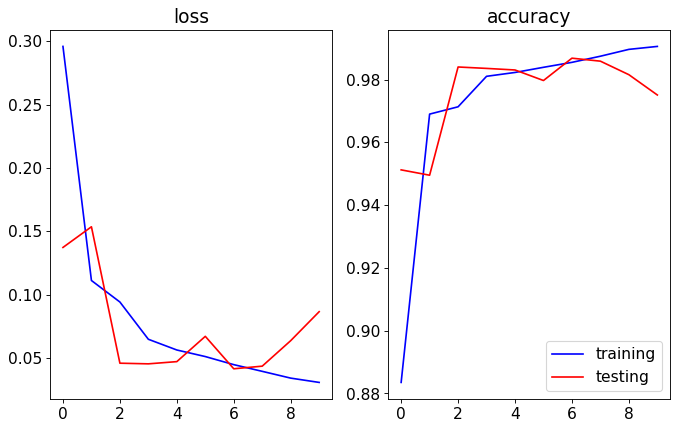

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.87it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


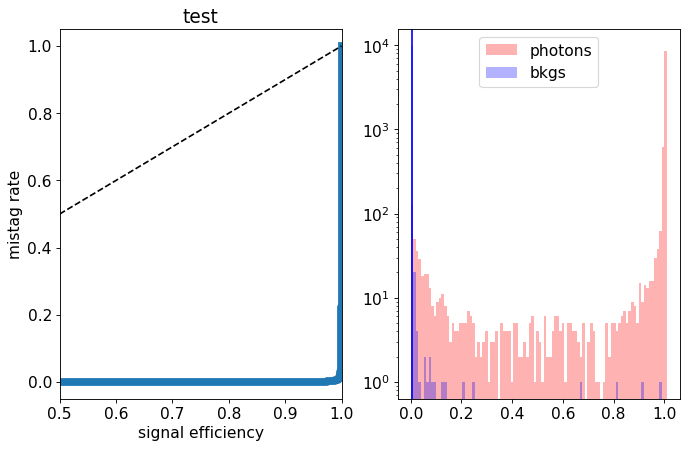

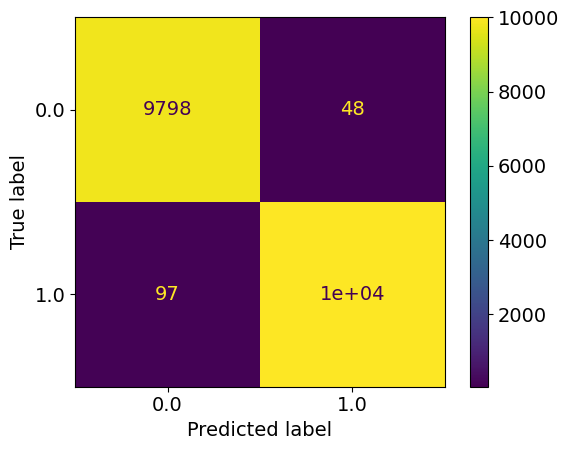

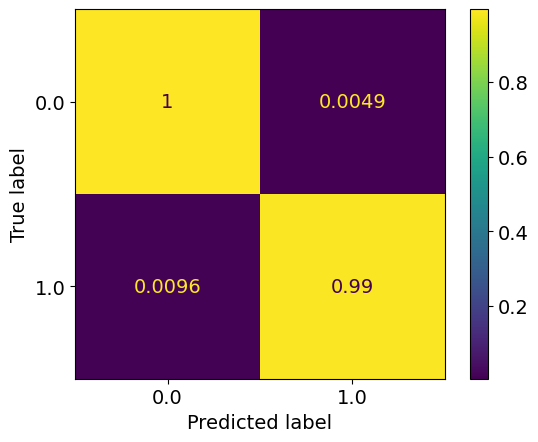

epoch: 10
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.030302952238968433
train acc: 0.9907152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.67it/s]


test loss: 0.056288068511468524
test acc: 0.9822082
epoch: 11
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.027599947858487132
train acc: 0.99111617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.74it/s]


test loss: 0.06815808386925389
test acc: 0.9816068
epoch: 12
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.02635464957678941
train acc: 0.99214363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.056267292567474
test acc: 0.9847141
epoch: 13
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.024298647971156596
train acc: 0.9927451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.81it/s]


test loss: 0.07812133486218312
test acc: 0.9814564
epoch: 14
Learning rate: 0.0008188926045137138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.024008040688236924
train acc: 0.99235666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.80it/s]


test loss: 0.06279524936176398
test acc: 0.9841628
epoch: 15
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.023103173328702573
train acc: 0.9928954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.1124727648737676
test acc: 0.9746404
epoch: 16
Learning rate: 0.0007681113183592135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.022433928368654824
train acc: 0.9929581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]


test loss: 0.027191248968901002
test acc: 0.9918809
new best acc: 0.9918809
epoch: 17
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.021888141972516706
train acc: 0.9929957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]


test loss: 0.03173294364515802
test acc: 0.9901268
epoch: 18
Learning rate: 0.0007131017565522499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.020284123652711955
train acc: 0.9936473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.03797109725350952
test acc: 0.9890242
epoch: 19
Learning rate: 0.0006842802396059903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.019443144142599917
train acc: 0.9940106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.78it/s]


test loss: 0.026690420848728323
test acc: 0.99213153
new best acc: 0.99213153


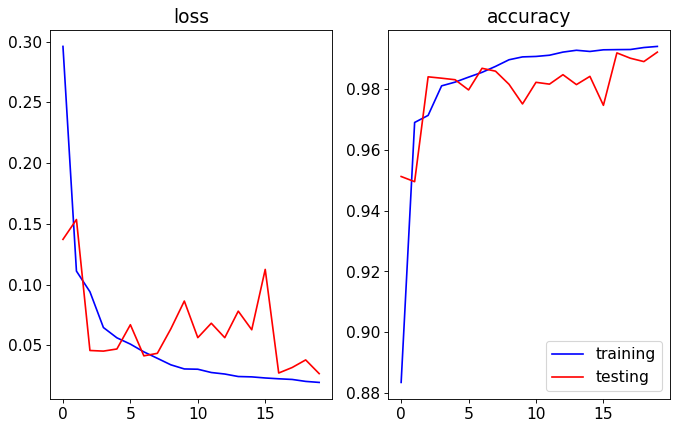

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


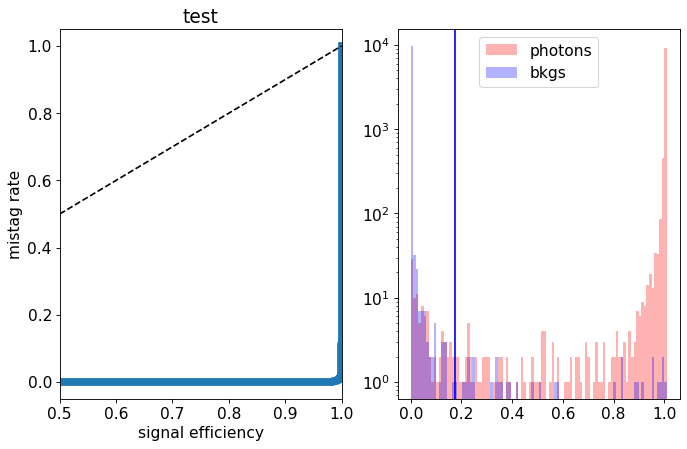

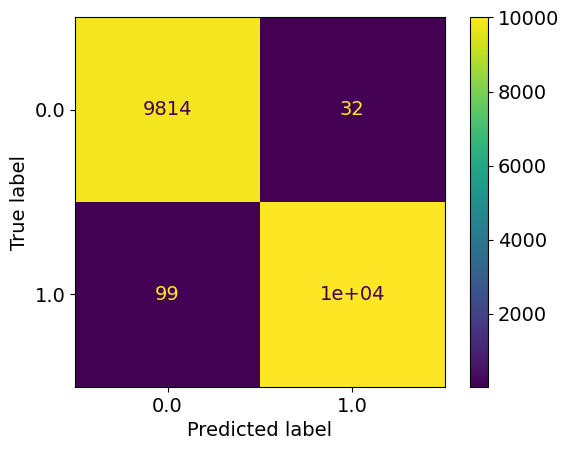

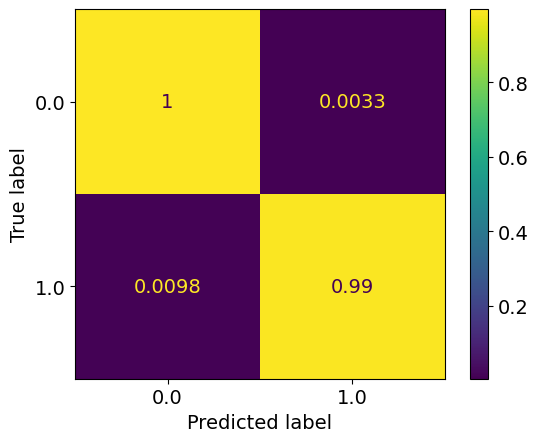

epoch: 20
Learning rate: 0.0006547314527436388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.02002067730766734
train acc: 0.99369735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.043540758656009156
test acc: 0.9884228
epoch: 21
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.018278354219397278
train acc: 0.9945494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.033292347270831024
test acc: 0.99052775
epoch: 22
Learning rate: 0.0005939209414931709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.01902756814535624
train acc: 0.9940858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]


test loss: 0.040287892971023476
test acc: 0.9892748
epoch: 23
Learning rate: 0.0005628992084112799


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.01794198142197817
train acc: 0.99432385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.80it/s]


test loss: 0.027320209274287608
test acc: 0.99273294
new best acc: 0.99273294
epoch: 24
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.017633240988804724
train acc: 0.9944993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.04570638766402707
test acc: 0.988523
epoch: 25
Learning rate: 0.0005002344472043634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.017148848133593443
train acc: 0.99438655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]


test loss: 0.044093933832996035
test acc: 0.98817223
epoch: 26
Learning rate: 0.0004688387282630152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.017158703193061554
train acc: 0.9946121


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.82it/s]


test loss: 0.022830989978769246
test acc: 0.9921816
epoch: 27
Learning rate: 0.0004375659886249822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.01549167504687029
train acc: 0.9950757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.16it/s]


test loss: 0.04572881536339136
test acc: 0.98832256
epoch: 28
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.01631165596260342
train acc: 0.994587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.05141011091387447
test acc: 0.98742044
epoch: 29
Learning rate: 0.0003758821517012554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.015681952963900382
train acc: 0.99493784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.03752787943984218
test acc: 0.99002653


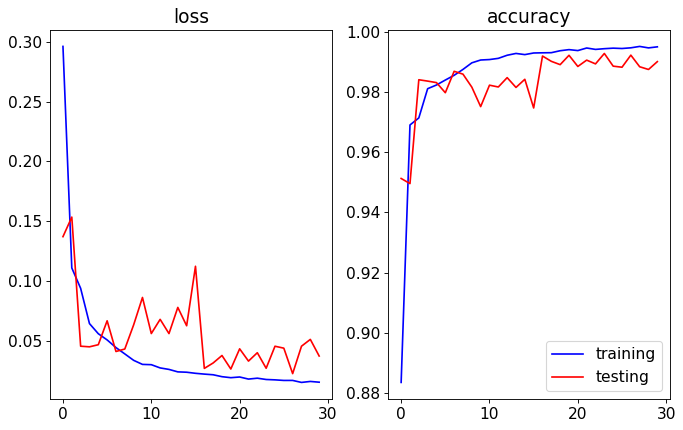

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


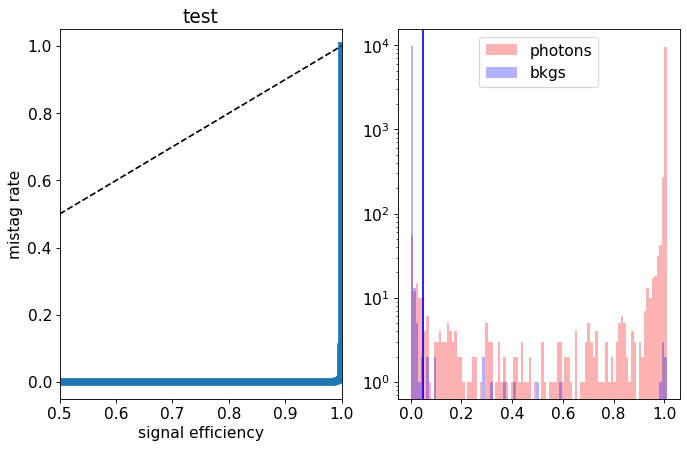

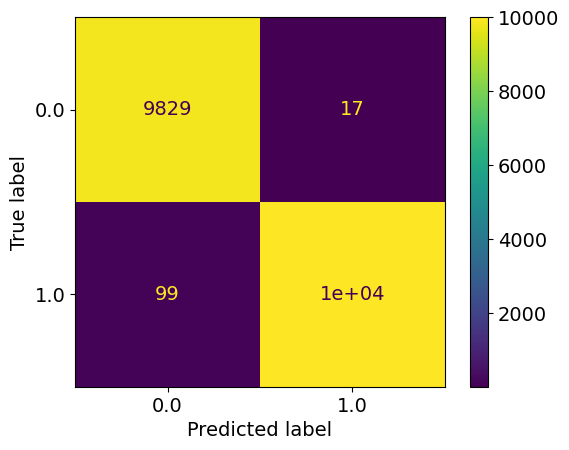

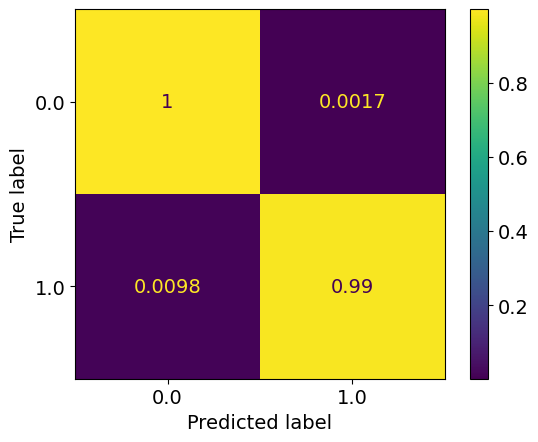

epoch: 30
Learning rate: 0.00034571449233923525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.014897458426004498
train acc: 0.99560195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.02194414794897003
test acc: 0.9938355
new best acc: 0.9938355
epoch: 31
Learning rate: 0.0003161557273896085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.015576783910831575
train acc: 0.99515086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.025585493148194954
test acc: 0.99253243
epoch: 32
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.015336901067631014
train acc: 0.9948877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]


test loss: 0.033132018452948504
test acc: 0.9912795
epoch: 33
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.01619655882189078
train acc: 0.9950631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.048602115198531574
test acc: 0.98862326
epoch: 34
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.014046662990542462
train acc: 0.9956771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.87it/s]


test loss: 0.03270058619091287
test acc: 0.9917807
epoch: 35
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.014400793990061948
train acc: 0.9952386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]


test loss: 0.029621592623537734
test acc: 0.99112916
epoch: 36
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.014223623784509167
train acc: 0.9955268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.80it/s]


test loss: 0.03280322396826437
test acc: 0.9916303
epoch: 37
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.014410583879242636
train acc: 0.995414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.029560720719232717
test acc: 0.9924823
epoch: 38
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.013544073549043134
train acc: 0.99563956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.99it/s]


test loss: 0.02754935307893902
test acc: 0.992332
epoch: 39
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.013702555396477367
train acc: 0.99561447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.035002390347311604
test acc: 0.9912294


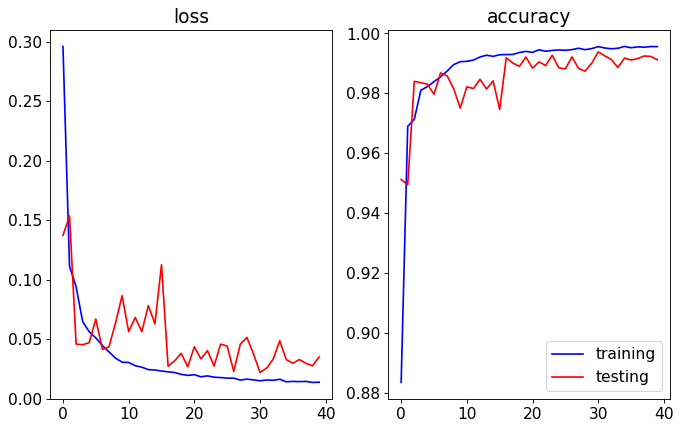

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


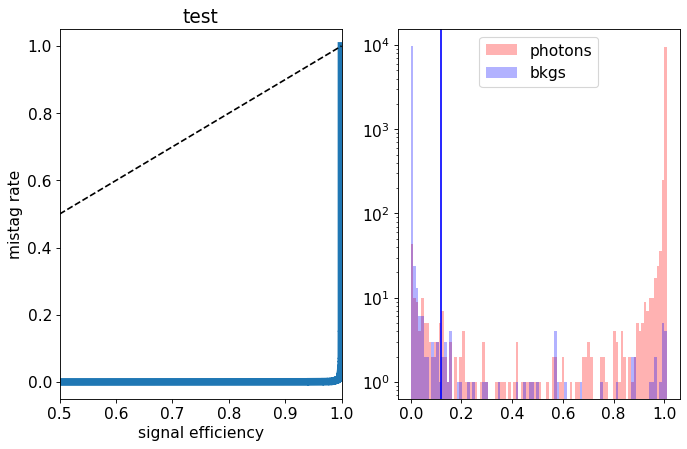

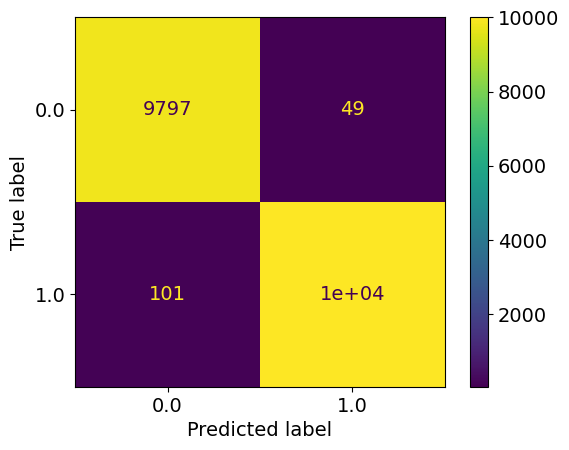

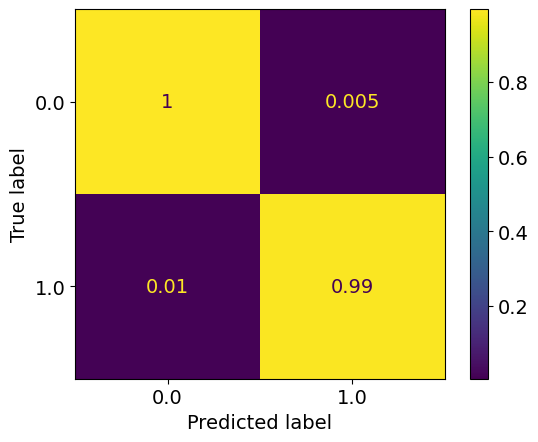

epoch: 40
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.015946365614880376
train acc: 0.99585253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.03156121804118704
test acc: 0.99168044
epoch: 41
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.014853578772171706
train acc: 0.9947374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.03555035138475325
test acc: 0.9917306
epoch: 42
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.012969042356960031
train acc: 0.99568963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.03159728040918708
test acc: 0.991931
epoch: 43
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.012813509753800984
train acc: 0.99560195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.95it/s]


test loss: 0.03895935154629543
test acc: 0.9909287
epoch: 44
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.013303152514871821
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.03439367054413785
test acc: 0.99168044
epoch: 45
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.013393542062101969
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.03146134788060889
test acc: 0.9920313
epoch: 46
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.013176953255193684
train acc: 0.9957022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.03429079154396758
test acc: 0.9916303
epoch: 47
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.012185135063951585
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.032203747849801886
test acc: 0.9920313
epoch: 48
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.013022958179814186
train acc: 0.9958024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.03230116809444392
test acc: 0.9917807
epoch: 49
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.53it/s]


train loss: 0.012484704782200966
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.67it/s]


test loss: 0.03341946197392912
test acc: 0.9917807


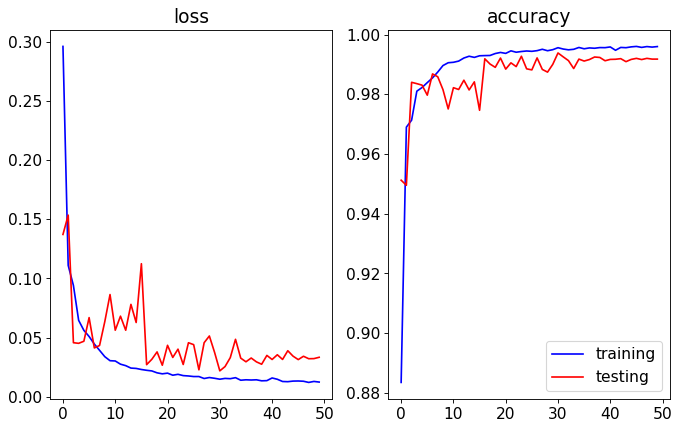

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


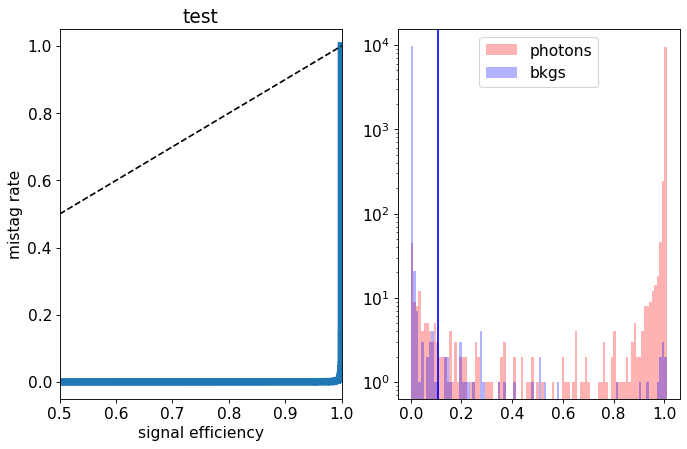

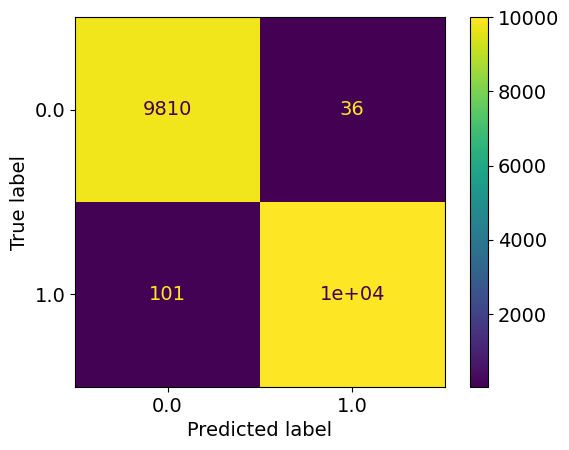

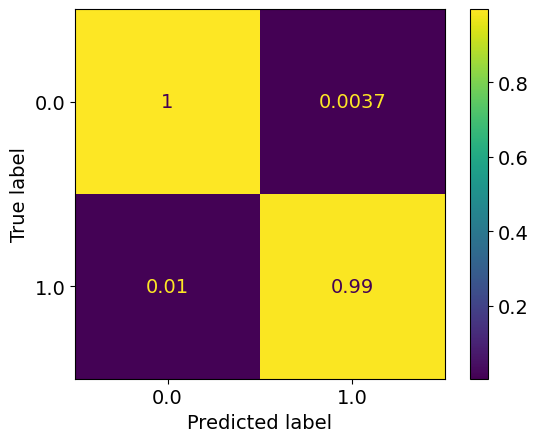

epoch: 50
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.0195020562282819
train acc: 0.9935094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.75it/s]


test loss: 0.015196395791409648
test acc: 0.9948379
new best acc: 0.9948379
epoch: 51
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.0199425851738553
train acc: 0.9936222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.0236859098487698
test acc: 0.9929835
epoch: 52
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.02232444166977292
train acc: 0.9935219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.79it/s]


test loss: 0.01932289856759941
test acc: 0.9930838
epoch: 53
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.022494096298521355
train acc: 0.9932087


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.027414257227278808
test acc: 0.99037737
epoch: 54
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.017197606609022215
train acc: 0.9943364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.82it/s]


test loss: 0.022976992076591533
test acc: 0.9929334
epoch: 55
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.01690255902506022
train acc: 0.9944617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.87it/s]


test loss: 0.028430254383505705
test acc: 0.99228185
epoch: 56
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.018078921095176198
train acc: 0.99389786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.75it/s]


test loss: 0.01868159433498102
test acc: 0.9945372
epoch: 57
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.02169907427524953
train acc: 0.9933465


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.78it/s]


test loss: 0.025868939148494974
test acc: 0.9923821
epoch: 58
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.021909373944430655
train acc: 0.9927326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.02006266313016086
test acc: 0.9941362
epoch: 59
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.015359606541069434
train acc: 0.99480003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.028658148099887457
test acc: 0.9929334


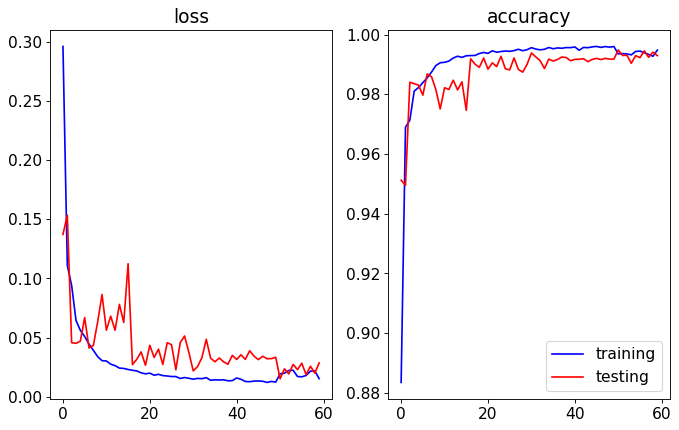

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


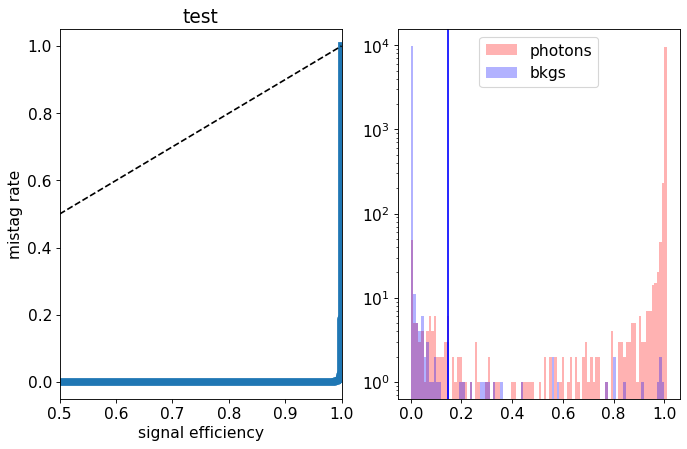

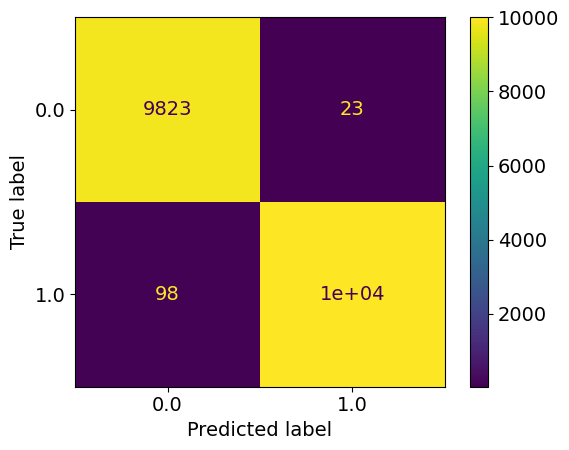

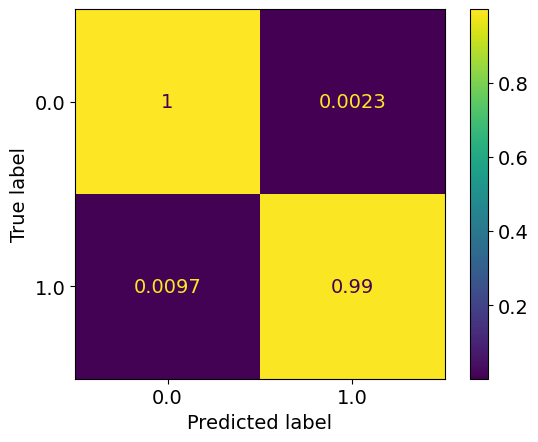

epoch: 60
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.016076055824506417
train acc: 0.9948877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.03145710309036076
test acc: 0.99137974
epoch: 61
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.016770302404913662
train acc: 0.9943991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.61it/s]


test loss: 0.017566961180658407
test acc: 0.99448705
epoch: 62
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.015560677482915083
train acc: 0.9950631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.80it/s]


test loss: 0.016966029830441317
test acc: 0.99508846
new best acc: 0.99508846
epoch: 63
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.015149916994816331
train acc: 0.9950381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.0180507790954674
test acc: 0.9937854
epoch: 64
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.01575663757722029
train acc: 0.99482507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.87it/s]


test loss: 0.01220189059527269
test acc: 0.9963414
new best acc: 0.9963414
epoch: 65
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.014962133072723231
train acc: 0.995201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.01688375905573861
test acc: 0.9948379
epoch: 66
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.015247357480246191
train acc: 0.99512583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.014801430074251531
test acc: 0.99533904
epoch: 67
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.01579116515245344
train acc: 0.99497545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.019424749771133065
test acc: 0.9938355
epoch: 68
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.01454408737972631
train acc: 0.9950631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.016413148602142054
test acc: 0.99478775
epoch: 69
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.014181223647571656
train acc: 0.99576485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.79it/s]


test loss: 0.01177771545789095
test acc: 0.996592
new best acc: 0.996592


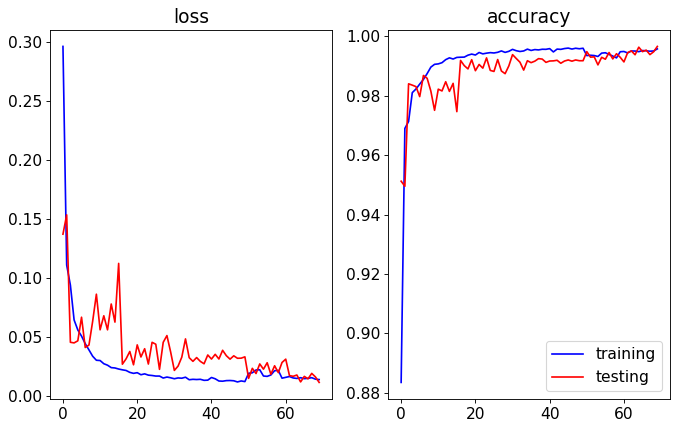

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


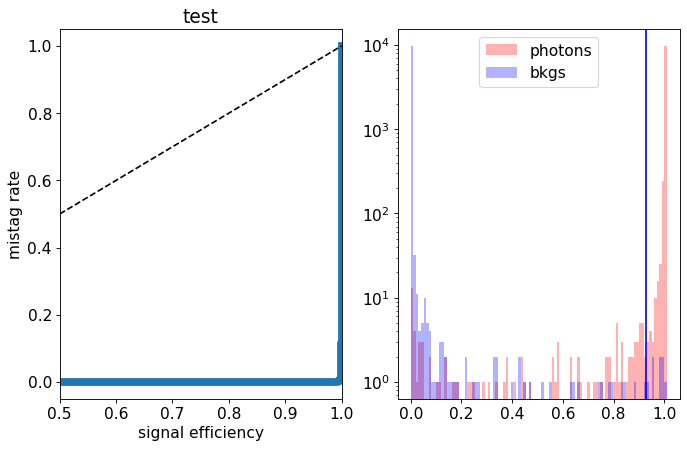

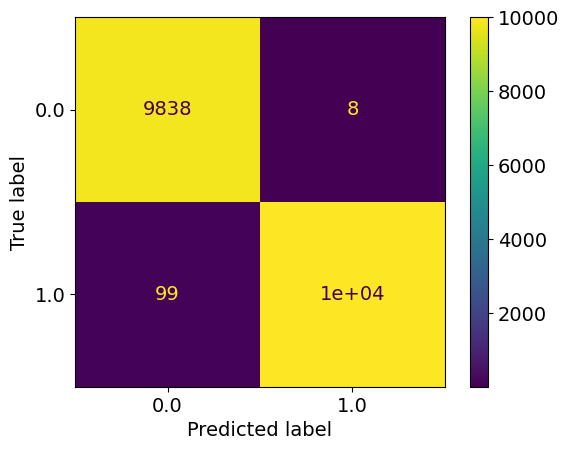

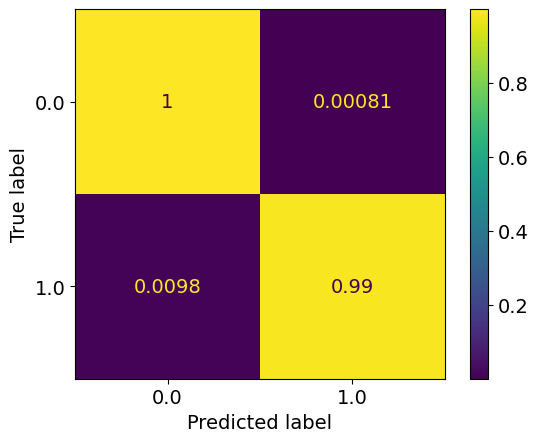

epoch: 70
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.013288504635083746
train acc: 0.99560195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.0176433635478508
test acc: 0.99423647
epoch: 71
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.013163216939431807
train acc: 0.99545157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.03260063740548075
test acc: 0.99343455
epoch: 72
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.014650237896562633
train acc: 0.9952386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.01511489279801026
test acc: 0.99584025
epoch: 73
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.01270227427763774
train acc: 0.9957022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.028622443294700456
test acc: 0.9932842
epoch: 74
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.013057157864669032
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.79it/s]


test loss: 0.02150250125594218
test acc: 0.99433666
epoch: 75
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.013238400352920567
train acc: 0.99575233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.80it/s]


test loss: 0.011496728959815194
test acc: 0.99649173
epoch: 76
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.013362485348978196
train acc: 0.99543905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.018801591659533132
test acc: 0.99478775
epoch: 77
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.012846279552261893
train acc: 0.99563956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.015699491129078737
test acc: 0.99533904
epoch: 78
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.012998649633783629
train acc: 0.9956521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.018379043574575062
test acc: 0.9945873
epoch: 79
Learning rate: 0.0003758821517012555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.012264280640798162
train acc: 0.99594027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.79it/s]


test loss: 0.020320930833216098
test acc: 0.99463737


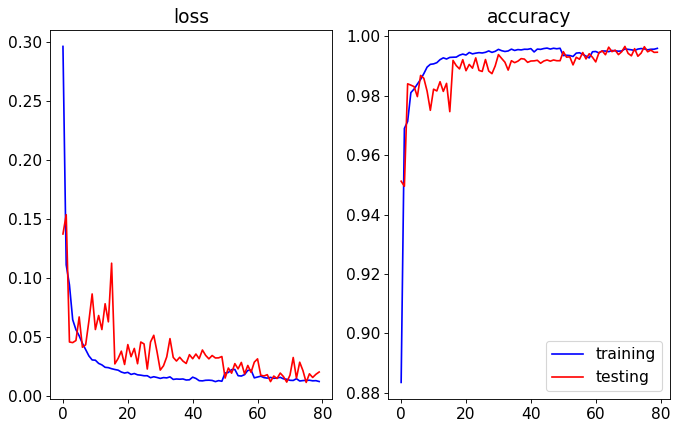

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


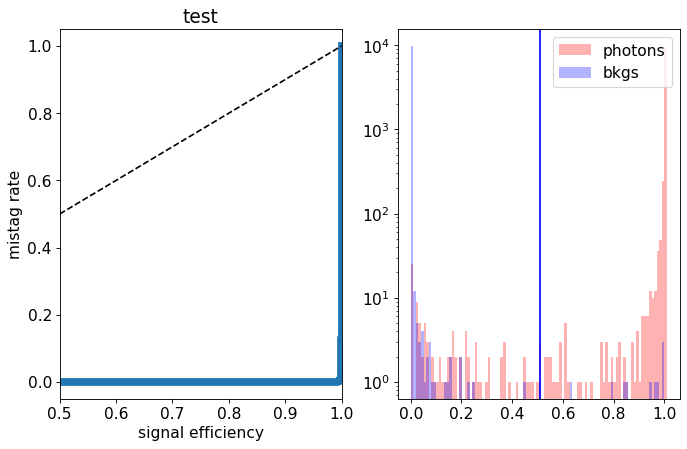

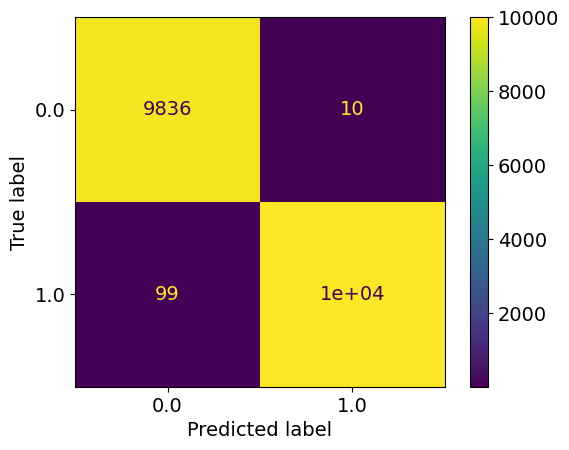

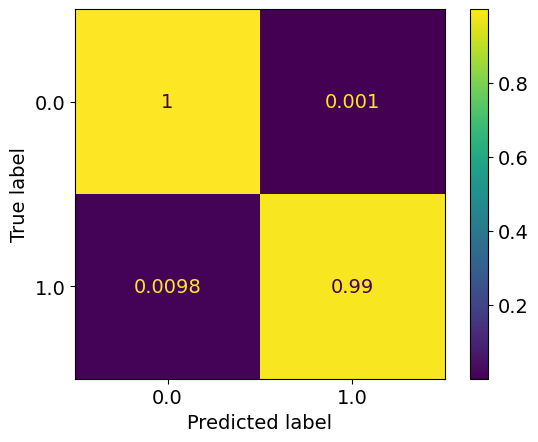

epoch: 80
Learning rate: 0.00034571449233923536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.012100397520125218
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.79it/s]


test loss: 0.01646276002825556
test acc: 0.994888
epoch: 81
Learning rate: 0.00031615572738960855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.01237228162214855
train acc: 0.9957899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.015336537416955894
test acc: 0.99594045
epoch: 82
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.01299269495168336
train acc: 0.99592775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.016216263359905603
test acc: 0.99478775
epoch: 83
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.011934875505420365
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.014949403528108259
test acc: 0.99563974
epoch: 84
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.01372500355251189
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.77it/s]


test loss: 0.021893172907071216
test acc: 0.99403596
epoch: 85
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.014339462906094407
train acc: 0.995414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.016858604445587844
test acc: 0.99538916
epoch: 86
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.010952571681709334
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.89it/s]


test loss: 0.016815371118033964
test acc: 0.99508846
epoch: 87
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.010583763915189283
train acc: 0.99651664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.014653289575482417
test acc: 0.99594045
epoch: 88
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.0113074116742433
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.01488003645242904
test acc: 0.9957901
epoch: 89
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.010806552837006668
train acc: 0.9962786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.015810683100854102
test acc: 0.9955896


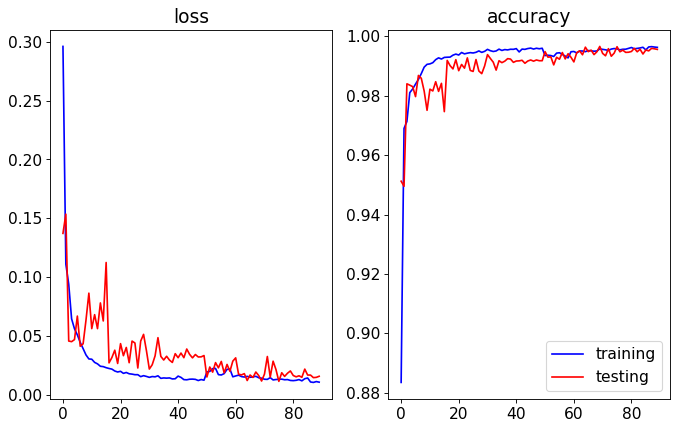

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


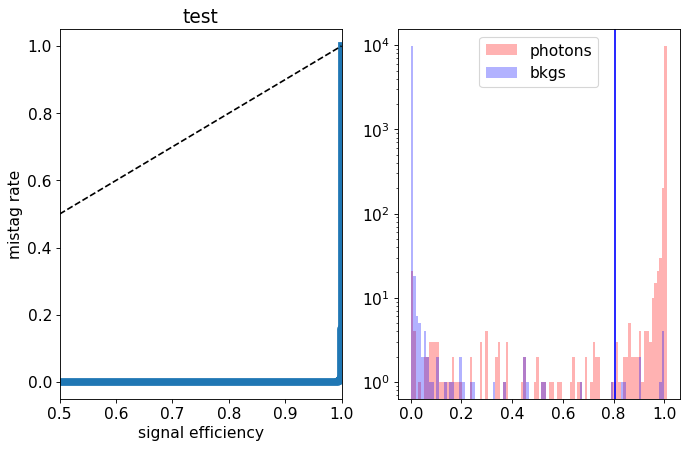

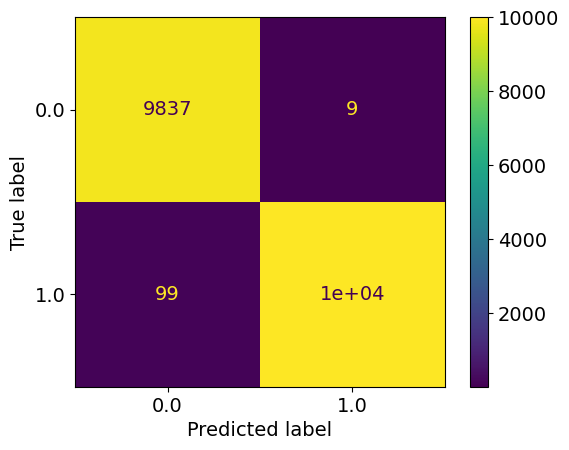

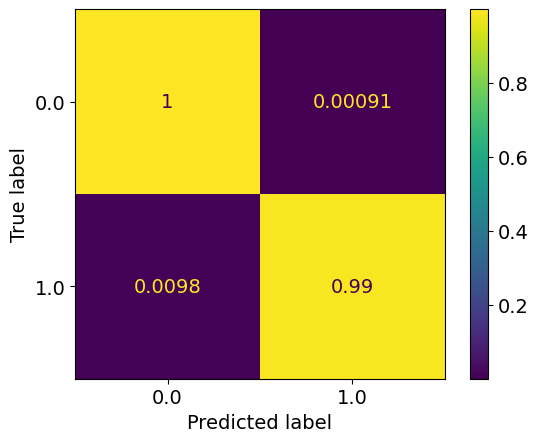

epoch: 90
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.01086845528817633
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.61it/s]


test loss: 0.01580900590017657
test acc: 0.9954894
epoch: 91
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.010784578660794937
train acc: 0.99649155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.022406283902990466
test acc: 0.9945372
epoch: 92
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.010382636604872323
train acc: 0.9966043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.015540523351827526
test acc: 0.99563974
epoch: 93
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.010305337437581438
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.01947419126244152
test acc: 0.9949381
epoch: 94
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.010589075962370634
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.01892761596649079
test acc: 0.9949882
epoch: 95
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.010164511694208851
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.01820989918718731
test acc: 0.9949882
epoch: 96
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.010377111704846316
train acc: 0.9966043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.01855300163194496
test acc: 0.9949882
epoch: 97
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.010689692891466974
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.66it/s]


test loss: 0.017788973421214476
test acc: 0.9951887
epoch: 98
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.010335508706187135
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.017701987594859126
test acc: 0.9951386
epoch: 99
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.010216060079766243
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.01772900435881799
test acc: 0.9951386


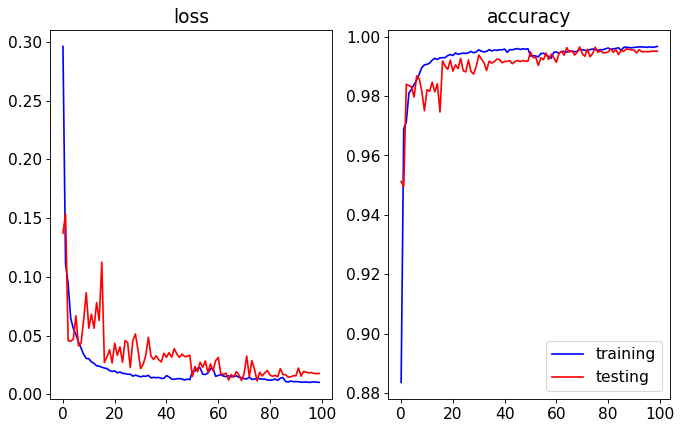

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.74it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


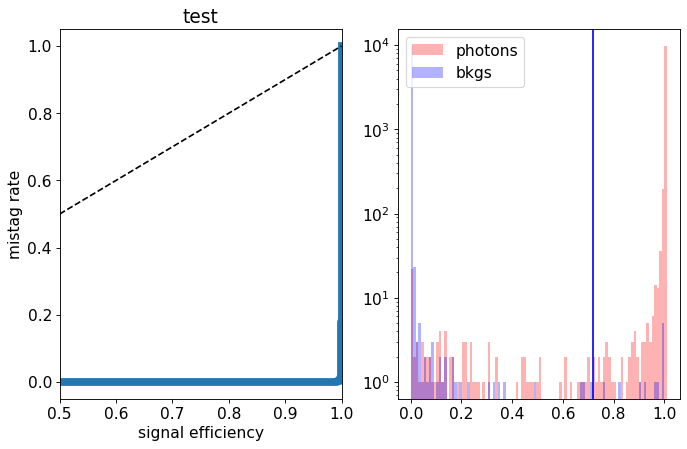

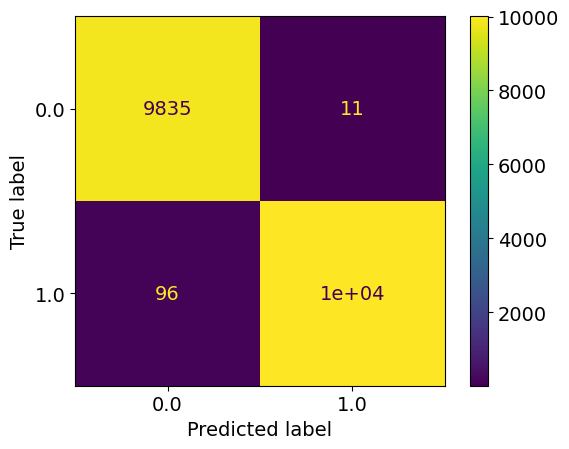

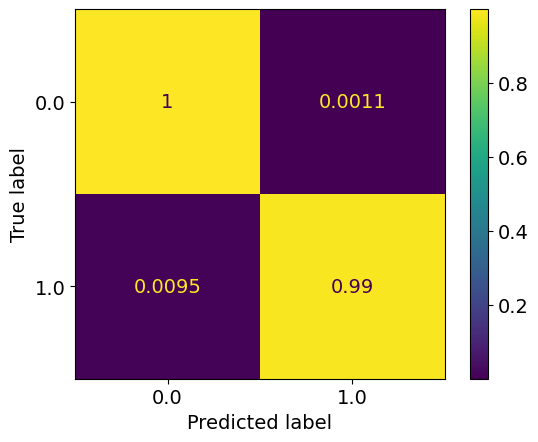

epoch: 100
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.0172464667164387
train acc: 0.9943991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.011135038401013897
test acc: 0.99639153
epoch: 101
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.017121687453281857
train acc: 0.99436146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.03319991686764885
test acc: 0.9929334
epoch: 102
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.01628422036501162
train acc: 0.99451184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.87it/s]


test loss: 0.016003396469065647
test acc: 0.9954393
epoch: 103
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.014834087381987318
train acc: 0.99496293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.02405304093297352
test acc: 0.9932341
epoch: 104
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.016517653912211216
train acc: 0.994587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.78it/s]


test loss: 0.021186655876911518
test acc: 0.99448705
epoch: 105
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.013926895218901336
train acc: 0.99515086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.015027512691791771
test acc: 0.9958903
epoch: 106
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.01698938082146055
train acc: 0.994374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.01371855620870038
test acc: 0.99563974
epoch: 107
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.013573409921277675
train acc: 0.99526364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.027497897554627237
test acc: 0.99198115
epoch: 108
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.014153966332226297
train acc: 0.9953764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.63it/s]


test loss: 0.01397655384532888
test acc: 0.9957901
epoch: 109
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.014651878342491143
train acc: 0.9948376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.020789726212730304
test acc: 0.9939859


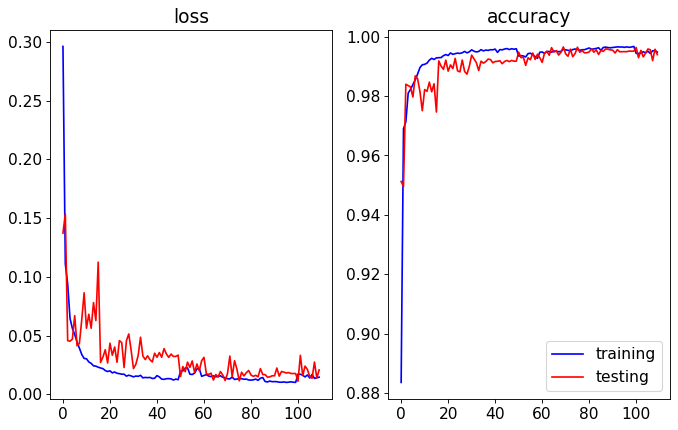

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


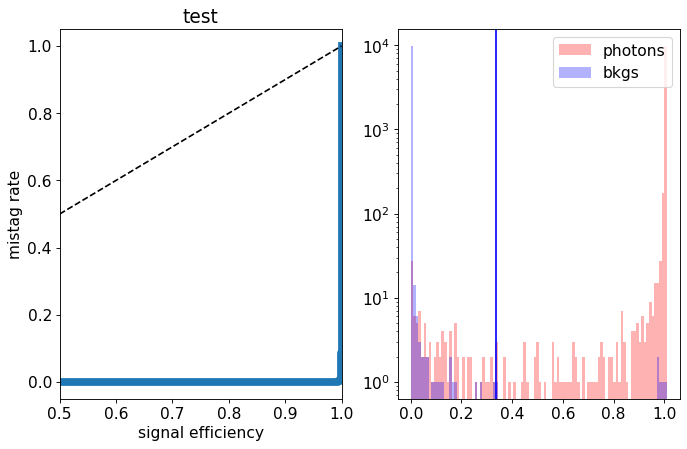

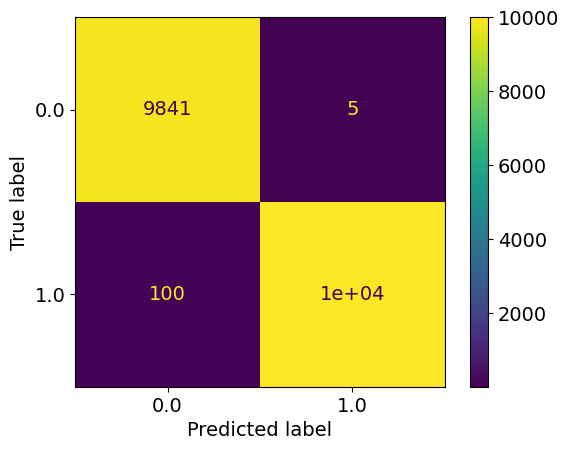

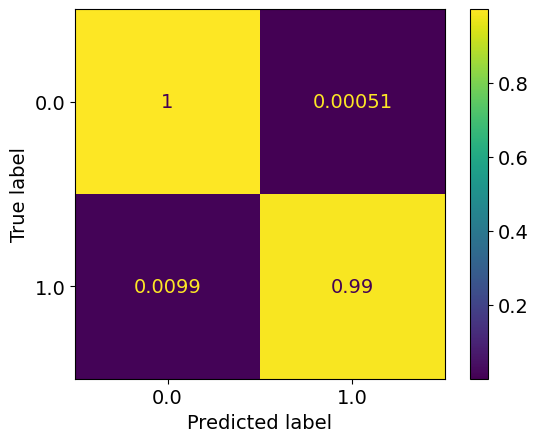

epoch: 110
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.014449113524490903
train acc: 0.9953513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.01622662747360985
test acc: 0.9951386
epoch: 111
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.014129621107061742
train acc: 0.9953388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.020728727952433367
test acc: 0.9949381
epoch: 112
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.013021213183207299
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.01392228909630563
test acc: 0.9957901
epoch: 113
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.0153877348969204
train acc: 0.9951634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.03314349315512706
test acc: 0.9920313
epoch: 114
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.013967688805284673
train acc: 0.995226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.01789846106644558
test acc: 0.99423647
epoch: 115
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.013765126882023665
train acc: 0.99540144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.03189849381091977
test acc: 0.99213153
epoch: 116
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.013553868726403243
train acc: 0.995627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.026175673346923597
test acc: 0.99313384
epoch: 117
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.01331839407957072
train acc: 0.9956771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.87it/s]


test loss: 0.016296468177803464
test acc: 0.99614096
epoch: 118
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.012425113766481961
train acc: 0.99592775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.011407429550137535
test acc: 0.9959906
epoch: 119
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.012339238454954406
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.16it/s]


test loss: 0.029617641841896865
test acc: 0.99228185


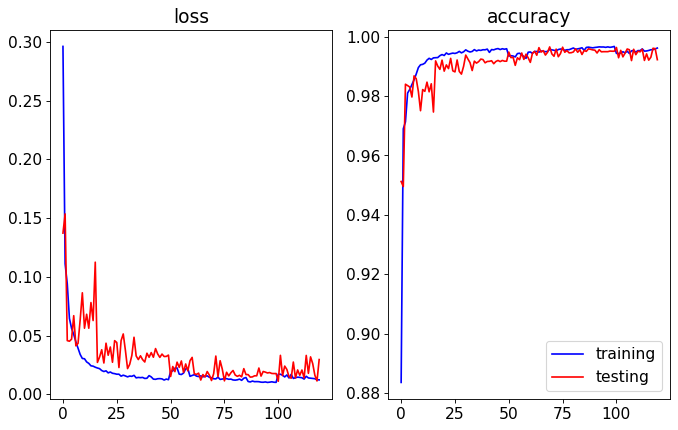

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


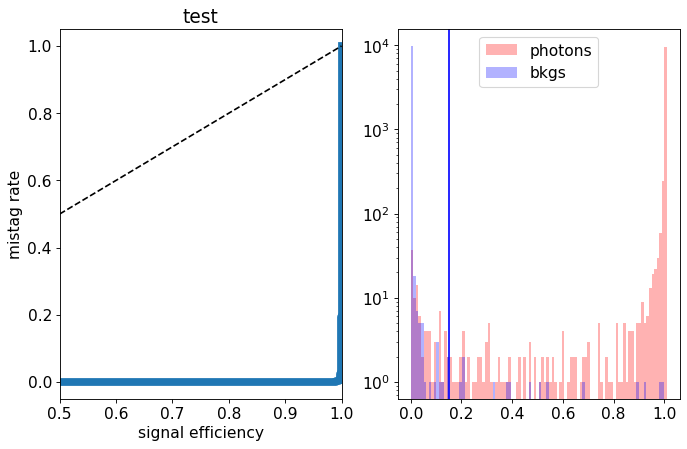

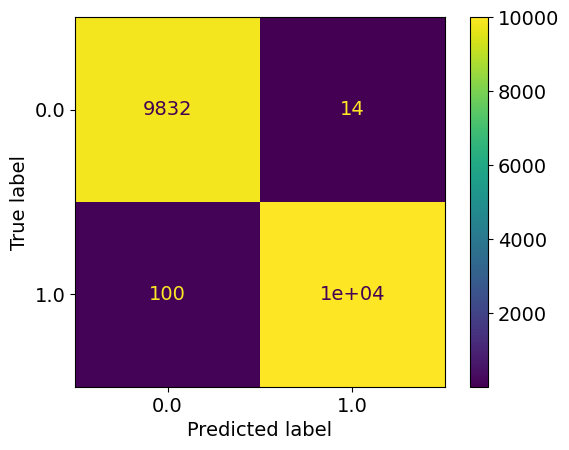

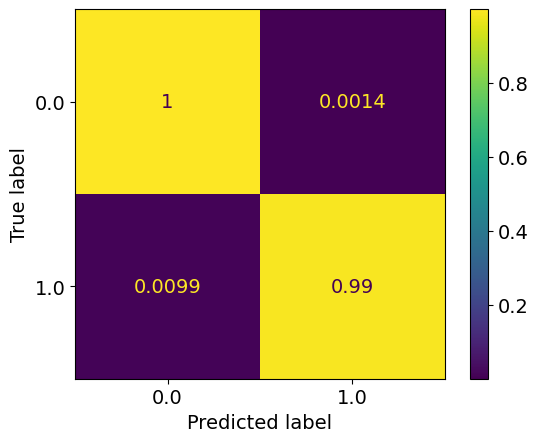

epoch: 120
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.012540260355498463
train acc: 0.99577737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.87it/s]


test loss: 0.014101640280654571
test acc: 0.99614096
epoch: 121
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.012688338617123525
train acc: 0.99572724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.0254613021889407
test acc: 0.9937854
epoch: 122
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.012650386588439456
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.022866615291123334
test acc: 0.9943868
epoch: 123
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.011588144057936713
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.65it/s]


test loss: 0.01590028270455899
test acc: 0.99584025
epoch: 124
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.01193496219653963
train acc: 0.995815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.94it/s]


test loss: 0.014914464381838436
test acc: 0.9955896
epoch: 125
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.53it/s]


train loss: 0.012217417352401944
train acc: 0.99594027


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.16it/s]


test loss: 0.02182754256800228
test acc: 0.99463737
epoch: 126
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.011024128152196533
train acc: 0.9963412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.73it/s]


test loss: 0.016100632228806394
test acc: 0.9960407
epoch: 127
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.012453040359159515
train acc: 0.9960906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.79it/s]


test loss: 0.01302696201395627
test acc: 0.9962913
epoch: 128
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.011941527327480935
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.76it/s]


test loss: 0.0218798389122479
test acc: 0.99423647
epoch: 129
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.010663507096190442
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.012194083650041754
test acc: 0.99649173


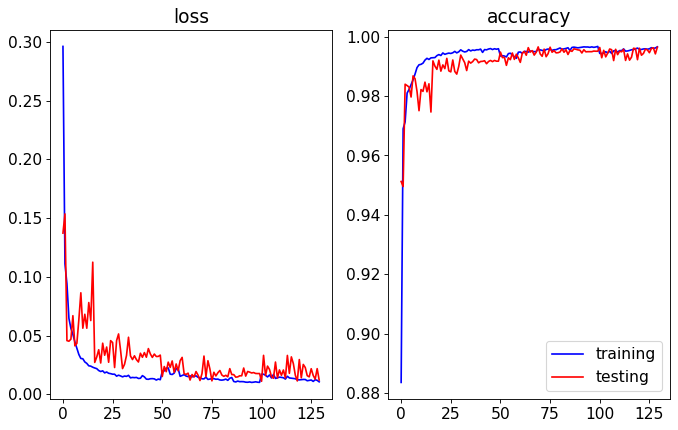

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.95it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


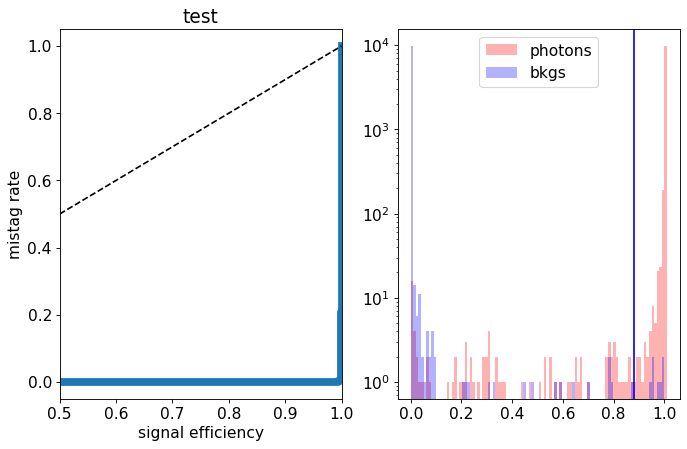

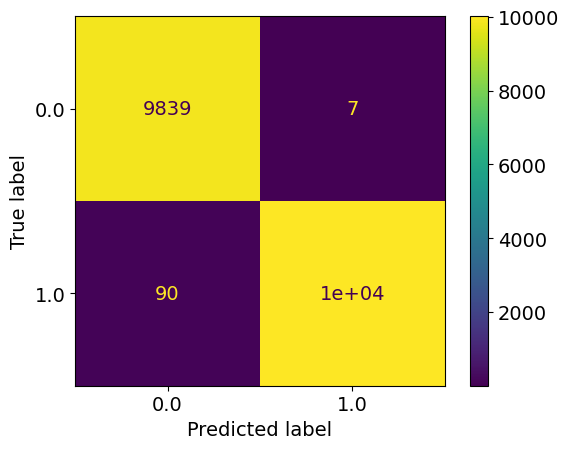

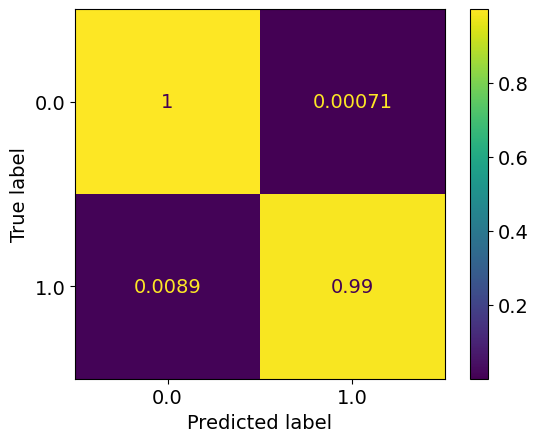

epoch: 130
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.01128495086398818
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.75it/s]


test loss: 0.023009683224646485
test acc: 0.99433666
epoch: 131
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.01029142715528159
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.025582402663798454
test acc: 0.9944369
epoch: 132
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.010615447277217102
train acc: 0.996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.87it/s]


test loss: 0.018965479637271902
test acc: 0.99568987
epoch: 133
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.01045289321521509
train acc: 0.9964665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.82it/s]


test loss: 0.01573147613688728
test acc: 0.99594045
epoch: 134
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.01097559499428948
train acc: 0.9964289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.88it/s]


test loss: 0.025507162537370974
test acc: 0.9939859
epoch: 135
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.011051997114728733
train acc: 0.99626607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.026140220839913714
test acc: 0.99388564
epoch: 136
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.010503961628219
train acc: 0.9963412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.01964670535594718
test acc: 0.99478775
epoch: 137
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.00955187099805074
train acc: 0.99664193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.015487409910693875
test acc: 0.9958903
epoch: 138
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.010572868712514
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.80it/s]


test loss: 0.02035314868151224
test acc: 0.9951386
epoch: 139
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.010029123132134467
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.020396388318324493
test acc: 0.9951887


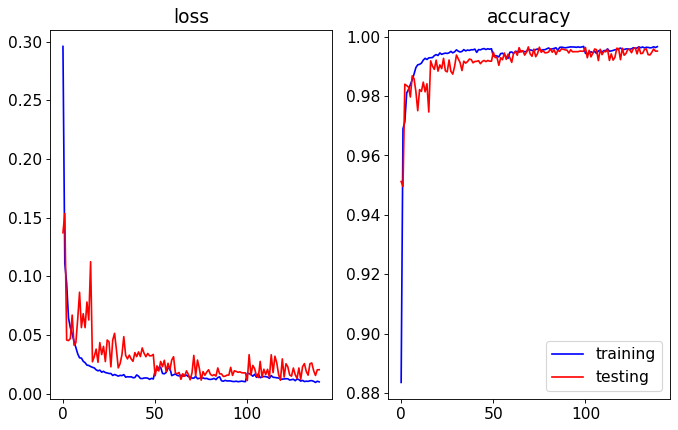

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


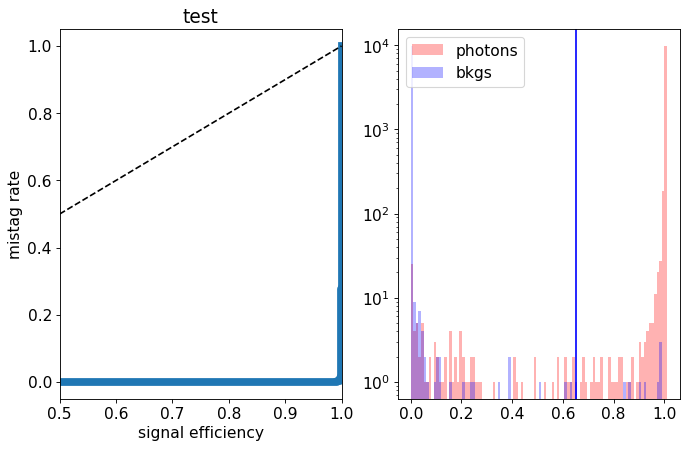

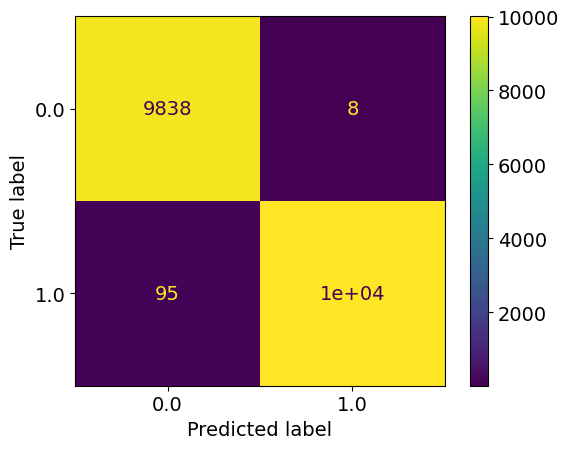

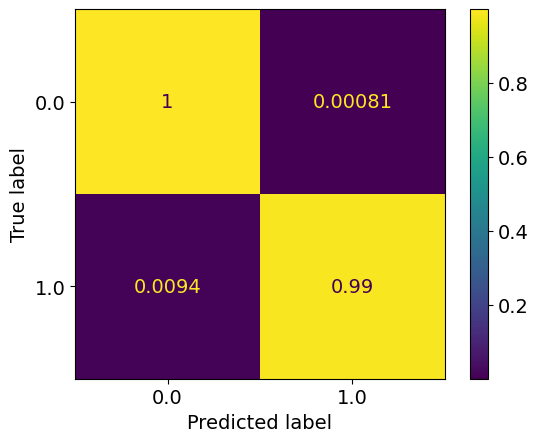

epoch: 140
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.009802726161694015
train acc: 0.9969051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.018135842080750187
test acc: 0.99563974
epoch: 141
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.01000603500223908
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.019078399527215344
test acc: 0.99508846
epoch: 142
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.00995647772206619
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.021743925654257455
test acc: 0.9945873
epoch: 143
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.009425792632860813
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.82it/s]


test loss: 0.02183565324059386
test acc: 0.99448705
epoch: 144
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.00962992937959133
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.01900643457466846
test acc: 0.9952889
epoch: 145
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.009356193499875936
train acc: 0.99664193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.99it/s]


test loss: 0.019244936568772093
test acc: 0.99523884
epoch: 146
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.009272849941348185
train acc: 0.99698025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.021995273669103078
test acc: 0.9951386
epoch: 147
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.00942274437373054
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.019899117548073476
test acc: 0.9951887
epoch: 148
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.009545471775218922
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.018490964652541794
test acc: 0.99533904
epoch: 149
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.009732183710198046
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.89it/s]


test loss: 0.018521061058837565
test acc: 0.99533904


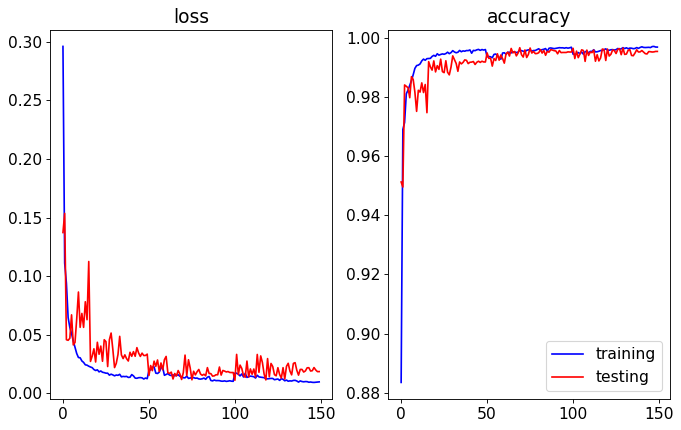

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


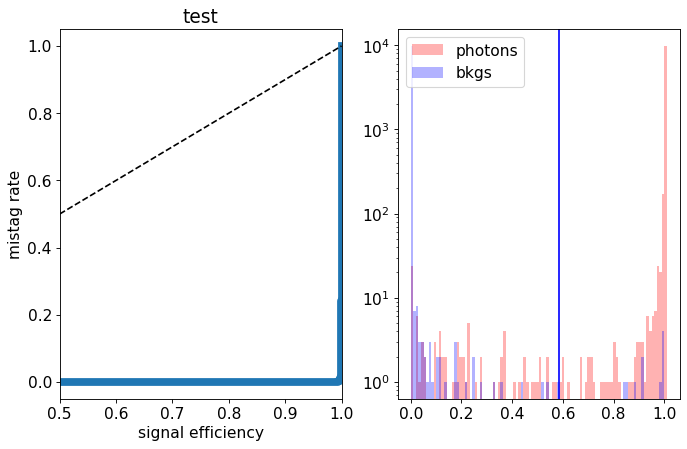

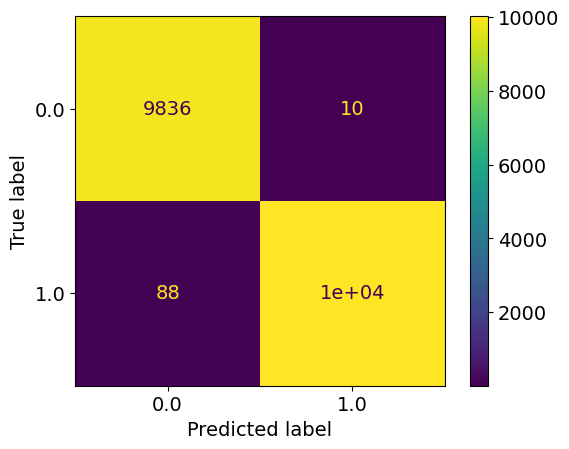

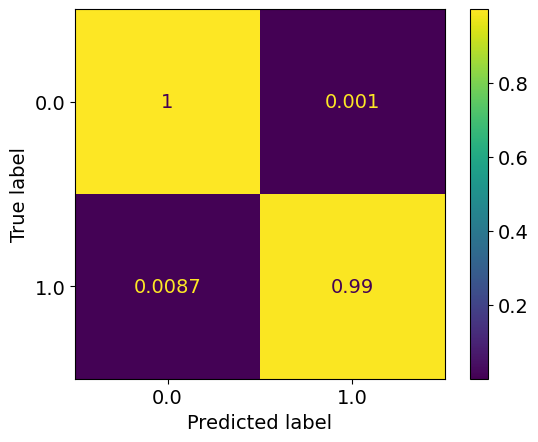

epoch: 150
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.017802022435744084
train acc: 0.9950256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.12454500016482438
test acc: 0.97819877
epoch: 151
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.04521774107228909
train acc: 0.98384875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.031124519143143996
test acc: 0.98967576
epoch: 152
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.025492204624261397
train acc: 0.99124146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.94it/s]


test loss: 0.02206182693514754
test acc: 0.99228185
epoch: 153
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.01957984138713453
train acc: 0.9933215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.02068623120773255
test acc: 0.99258256
epoch: 154
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.015781462871605548
train acc: 0.99510074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.016507290159043966
test acc: 0.99533904
epoch: 155
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.014791306732068231
train acc: 0.995226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.0340404174537124
test acc: 0.9915301
epoch: 156
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.015485795980996907
train acc: 0.99495035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.75it/s]


test loss: 0.016458778911756407
test acc: 0.9955896
epoch: 157
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.013156289737993059
train acc: 0.9956646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.02it/s]


test loss: 0.03211235586444244
test acc: 0.9920814
epoch: 158
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.01387037083579561
train acc: 0.995414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.017425095162573543
test acc: 0.9955896
epoch: 159
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.013104699601579124
train acc: 0.99557686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.021955890943953657
test acc: 0.9936852


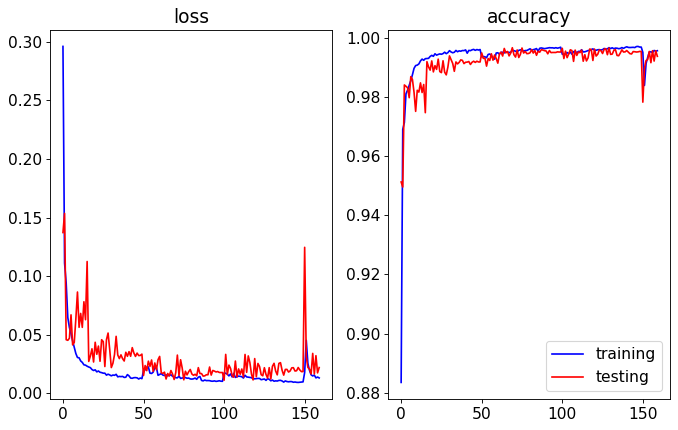

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


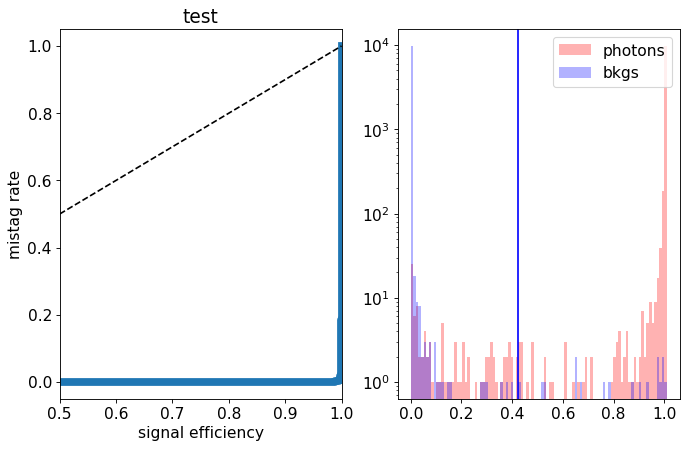

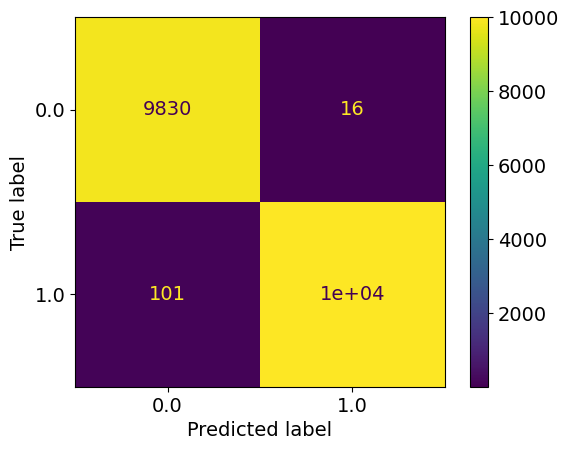

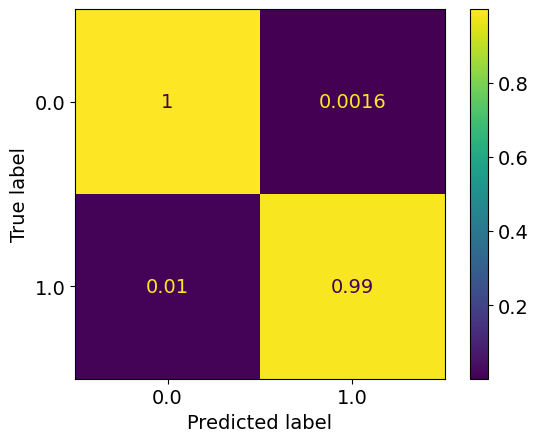

epoch: 160
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.013437830479708635
train acc: 0.9954892


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.013808369610855794
test acc: 0.99594045
epoch: 161
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.013051391739064633
train acc: 0.9955518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.025224703885375194
test acc: 0.9939859
epoch: 162
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.013116828087680093
train acc: 0.995815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.02108360708841835
test acc: 0.9945372
epoch: 163
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.011779238164993995
train acc: 0.99606556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.017946148554555667
test acc: 0.99563974
epoch: 164
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011258920107328737
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.018376460464102875
test acc: 0.9951386
epoch: 165
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.012765213201663442
train acc: 0.99573976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.027580240535933304
test acc: 0.9929835
epoch: 166
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.01155749184718799
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.03817430316378116
test acc: 0.9926327
epoch: 167
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.01209743640937455
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.95it/s]


test loss: 0.026751330889323178
test acc: 0.9932341
epoch: 168
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.011621542761389067
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.02it/s]


test loss: 0.01538496681913624
test acc: 0.99568987
epoch: 169
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.012435532069014413
train acc: 0.99568963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.0221921080014641
test acc: 0.994888


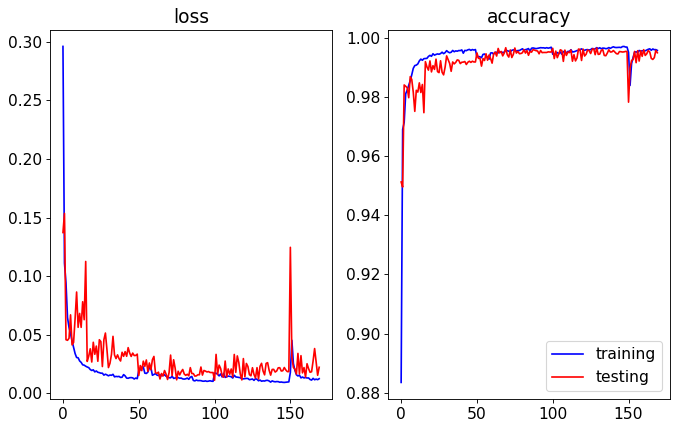

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.31it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


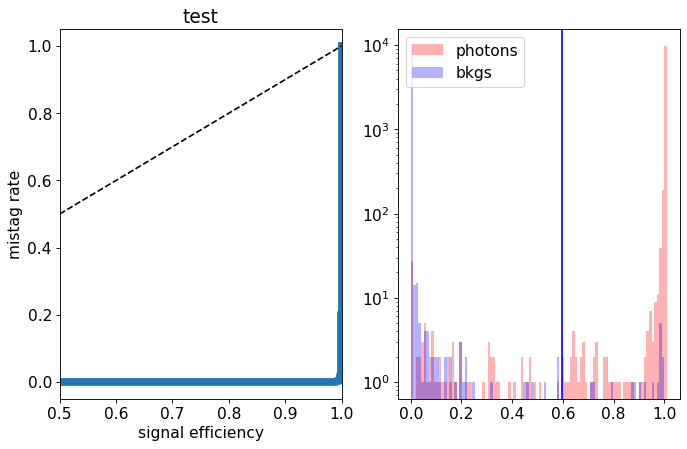

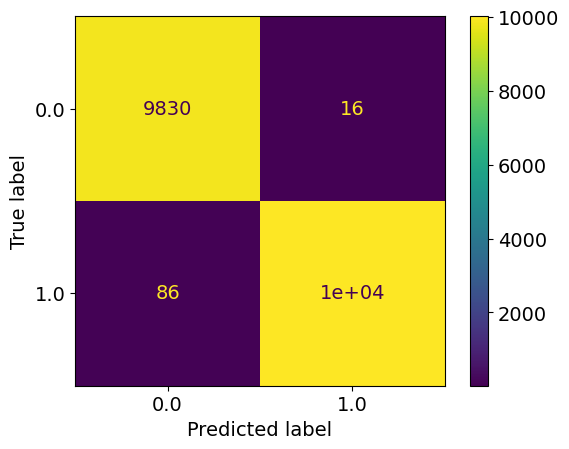

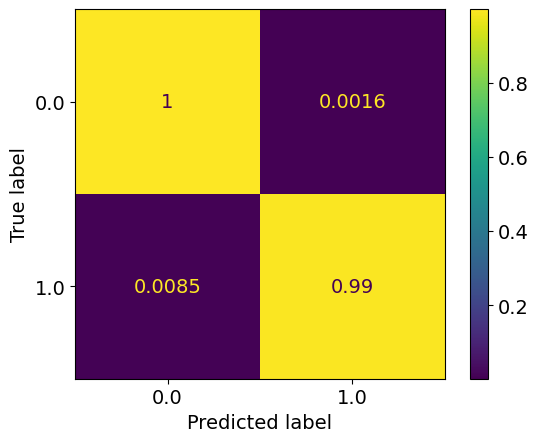

epoch: 170
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.011042404900749784
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]


test loss: 0.025885642184328067
test acc: 0.9948379
epoch: 171
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.012708116221978372
train acc: 0.99592775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.016213232565753383
test acc: 0.996592
epoch: 172
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.01305864114529773
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.01690750486929627
test acc: 0.99538916
epoch: 173
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.011334800991314852
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.020101496200368274
test acc: 0.9949381
epoch: 174
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.010754626908045744
train acc: 0.9962786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.88it/s]


test loss: 0.02171622697941904
test acc: 0.9945873
epoch: 175
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.011375482537285765
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.01960474204593886
test acc: 0.99448705
epoch: 176
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.011548119707633793
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.02860498827345402
test acc: 0.99373525
epoch: 177
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.010564161679647088
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.018893063910688984
test acc: 0.99538916
epoch: 178
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.58it/s]


train loss: 0.010352306299905446
train acc: 0.9964665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.68it/s]


test loss: 0.024696164330902427
test acc: 0.99423647
epoch: 179
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.01042839658527297
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.00it/s]


test loss: 0.013727222000906134
test acc: 0.996191


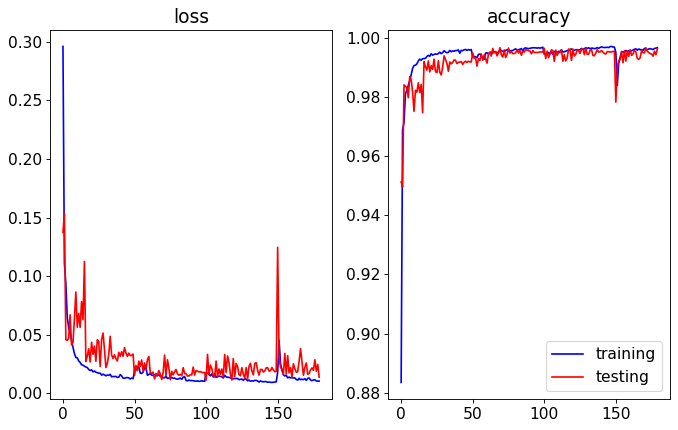

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


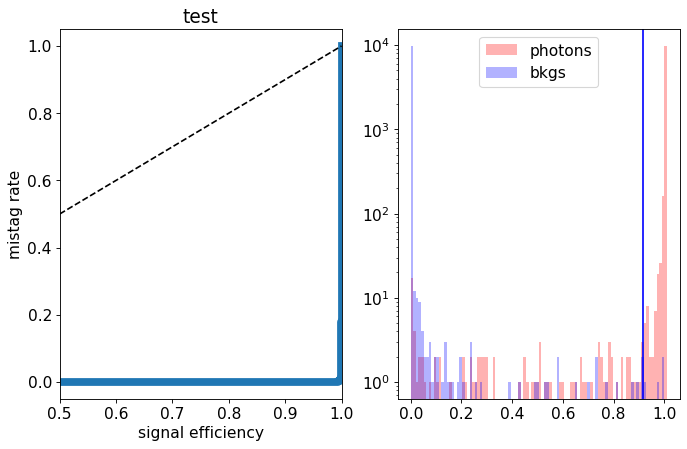

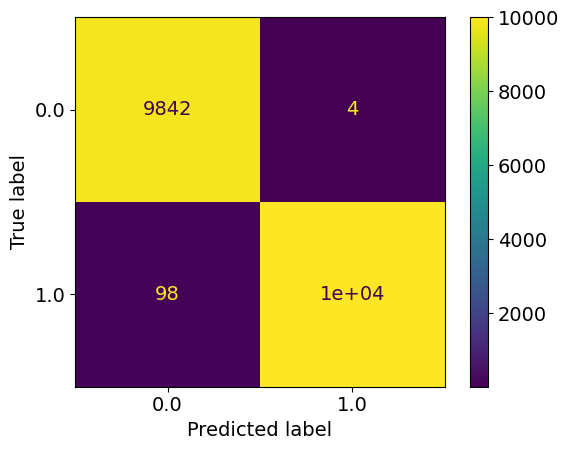

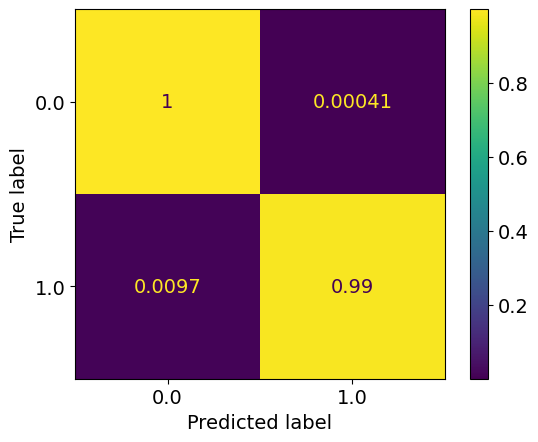

epoch: 180
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.009748071037621169
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.015350595209490754
test acc: 0.9958903
epoch: 181
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.009647323120100451
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.015821296108804422
test acc: 0.99594045
epoch: 182
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.01040077164122807
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.20it/s]


test loss: 0.009755421817638254
test acc: 0.99714327
new best acc: 0.99714327
epoch: 183
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010372348803046869
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.013968911862962962
test acc: 0.99644166
epoch: 184
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.0101352648100635
train acc: 0.99664193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.012228245864154066
test acc: 0.9968927
epoch: 185
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.009746035844422457
train acc: 0.9966294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.024331331544090062
test acc: 0.9943868
epoch: 186
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.012296857558183872
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.012535814117975807
test acc: 0.9970431
epoch: 187
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.020062628824180355
train acc: 0.99218124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.01758720270385418
test acc: 0.9945372
epoch: 188
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.013109335711329658
train acc: 0.9953513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.016023983280105954
test acc: 0.99508846
epoch: 189
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.011131389186684557
train acc: 0.99626607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.018127001945258063
test acc: 0.9951887


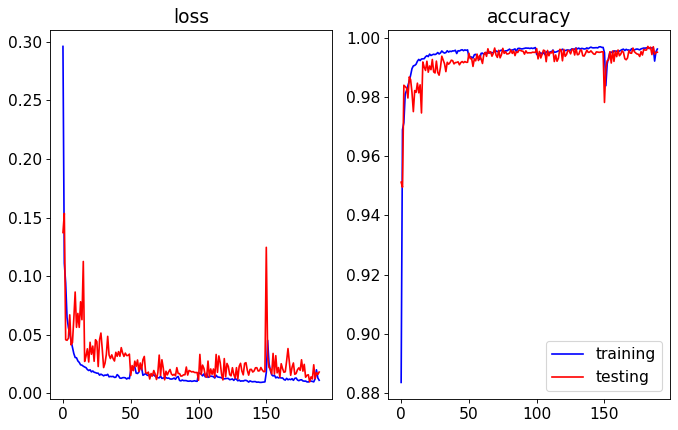

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


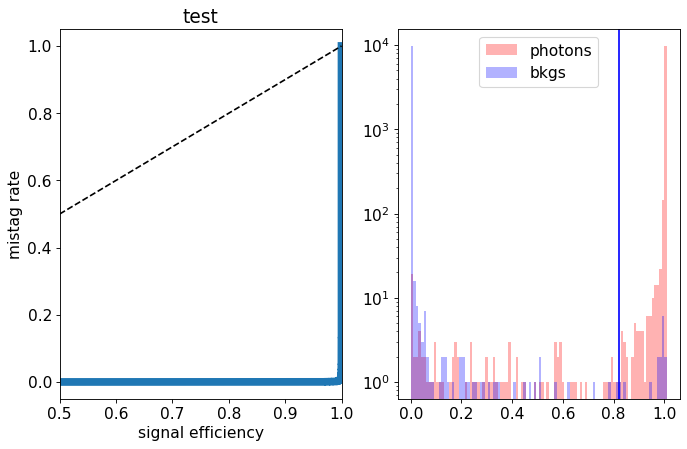

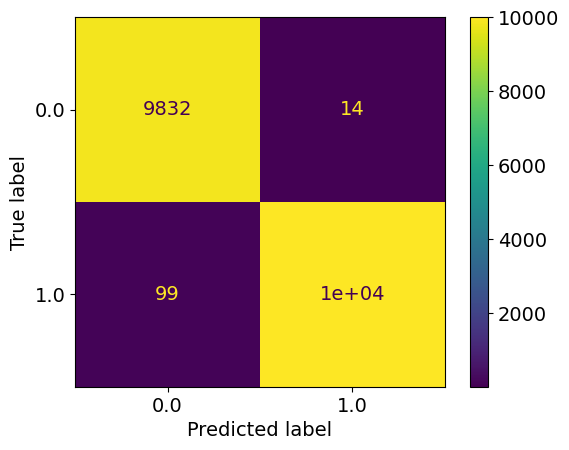

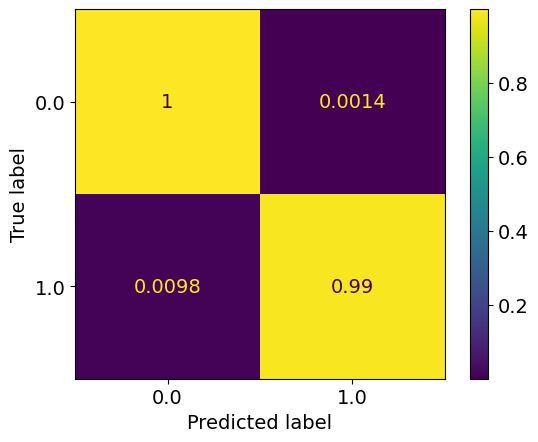

epoch: 190
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.010433631980402478
train acc: 0.9964665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


test loss: 0.016322230676237
test acc: 0.9954393
epoch: 191
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.010079526340198198
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.82it/s]


test loss: 0.017274843509820878
test acc: 0.99574
epoch: 192
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.0100169770012144
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.01770445099014871
test acc: 0.99568987
epoch: 193
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.009353899426928568
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.63it/s]


test loss: 0.017806317369189962
test acc: 0.99563974
epoch: 194
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.009598509966718979
train acc: 0.99649155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.80it/s]


test loss: 0.019949515062548658
test acc: 0.9951887
epoch: 195
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.009517883686452094
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.01913494262878564
test acc: 0.9954894
epoch: 196
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.009737679863404205
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.72it/s]


test loss: 0.018149905041140942
test acc: 0.9954894
epoch: 197
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.009254791395505254
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.82it/s]


test loss: 0.018511711306179197
test acc: 0.99538916
epoch: 198
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.00968747801771179
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.81it/s]


test loss: 0.018693600274512872
test acc: 0.99538916
epoch: 199
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.00981834424354006
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.74it/s]


test loss: 0.018651975019191226
test acc: 0.99538916


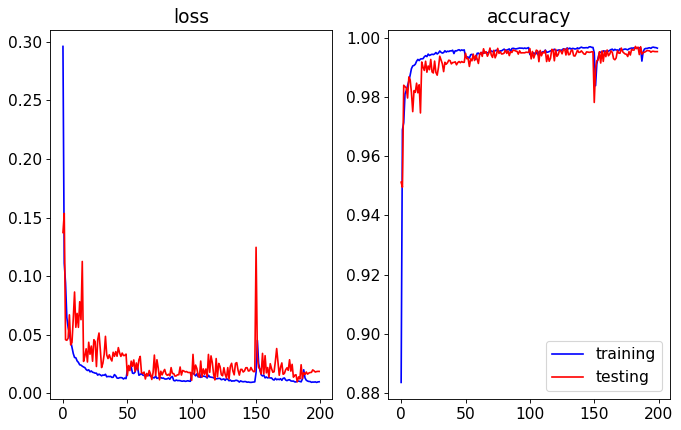

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.79it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


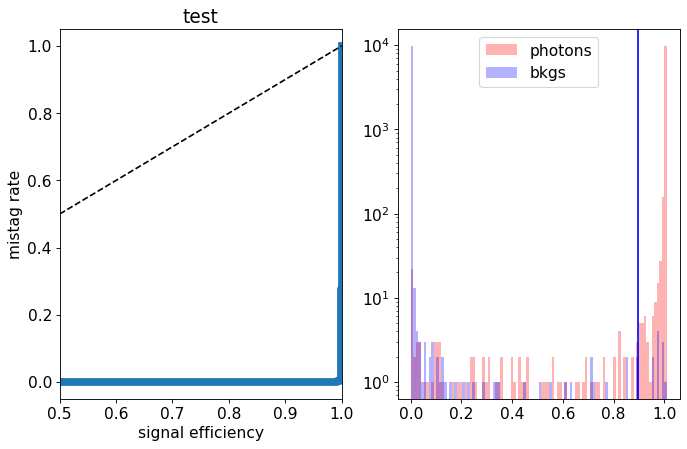

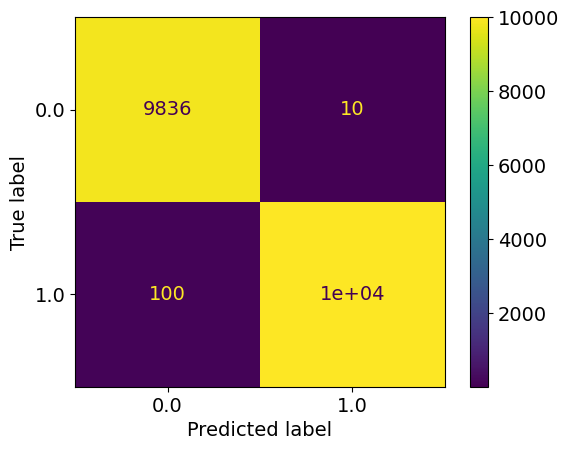

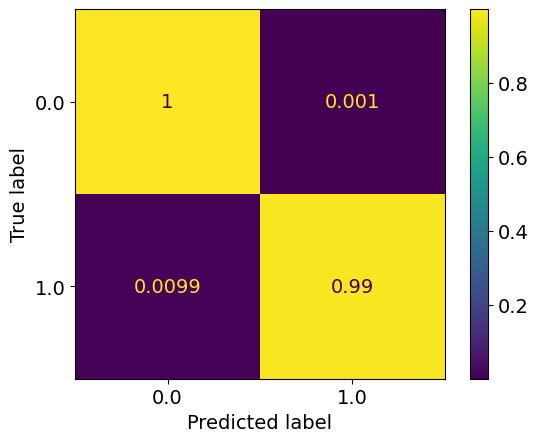

epoch: 200
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.01324167158324273
train acc: 0.9955142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.02463023881907301
test acc: 0.99478775
epoch: 201
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.012411187247394014
train acc: 0.9961407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.72it/s]


test loss: 0.022670474351958975
test acc: 0.99433666
epoch: 202
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.01188628341640027
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.73it/s]


test loss: 0.02324431447093101
test acc: 0.99393576
epoch: 203
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.50it/s]


train loss: 0.01204757651810642
train acc: 0.99575233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.52it/s]


test loss: 0.01620453836649711
test acc: 0.99649173
epoch: 204
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.53it/s]


train loss: 0.011858499734036958
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.41it/s]


test loss: 0.018736631554715773
test acc: 0.99538916
epoch: 205
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.012190624735310537
train acc: 0.9955393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.69it/s]


test loss: 0.026593061218805173
test acc: 0.9940861
epoch: 206
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.011797737948546088
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.72it/s]


test loss: 0.03061940852785483
test acc: 0.99363506
epoch: 207
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.012794246441539578
train acc: 0.99557686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.76it/s]


test loss: 0.02285315552472532
test acc: 0.99393576
epoch: 208
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.012006547110497956
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.63it/s]


test loss: 0.01426335217205205
test acc: 0.9959906
epoch: 209
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.01178087967920548
train acc: 0.99586505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.76it/s]


test loss: 0.017320532974896625
test acc: 0.99614096


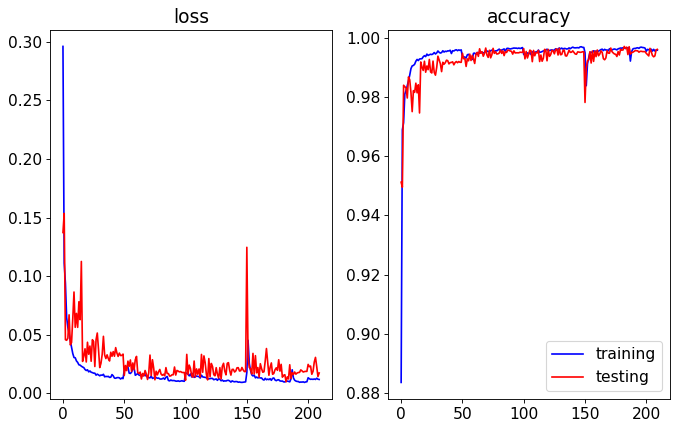

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.80it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


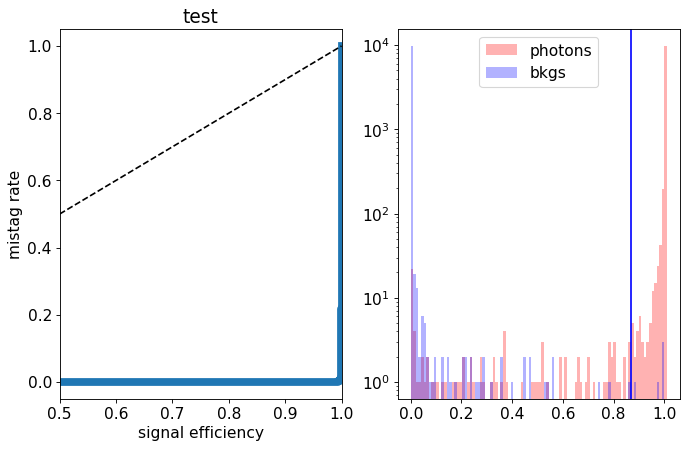

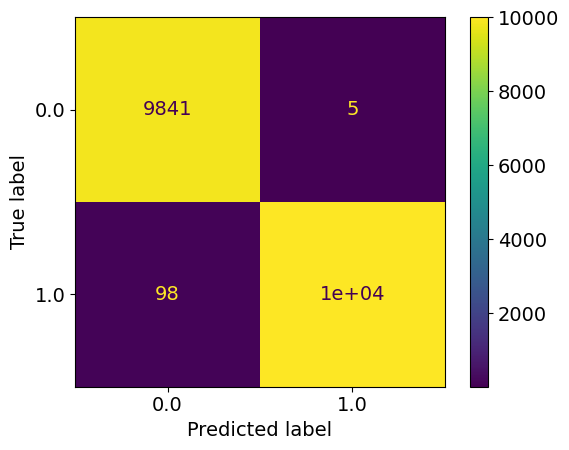

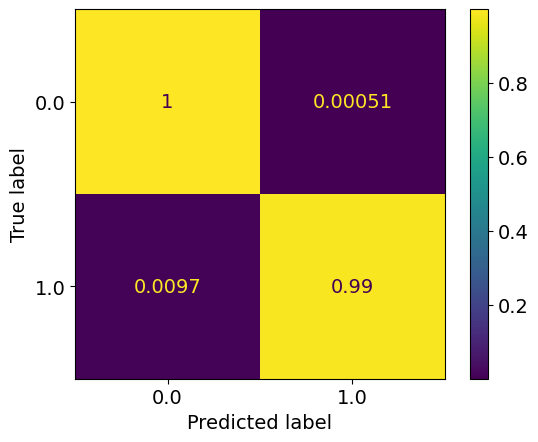

epoch: 210
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.011704930575189195
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.39it/s]


test loss: 0.024161531763692276
test acc: 0.99463737
epoch: 211
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:26<00:00,  5.15it/s]


train loss: 0.012357763187184847
train acc: 0.99584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.55it/s]


test loss: 0.01715799590216621
test acc: 0.99538916
epoch: 212
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.01140528882040517
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.66it/s]


test loss: 0.01514700247999452
test acc: 0.99553955
epoch: 213
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.27it/s]


train loss: 0.011282271968805468
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.69it/s]


test loss: 0.02100987596478423
test acc: 0.99403596
epoch: 214
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.012100311550450748
train acc: 0.9959653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.78it/s]


test loss: 0.017620193142005625
test acc: 0.9957901
epoch: 215
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.01107354683444467
train acc: 0.9961783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.55it/s]


test loss: 0.01686206959643374
test acc: 0.9958903
epoch: 216
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.012238419565212315
train acc: 0.9956521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.41it/s]


test loss: 0.014825713114559595
test acc: 0.9959906
epoch: 217
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.010106209049361008
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.79it/s]


test loss: 0.014763979605477824
test acc: 0.99614096
epoch: 218
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.011261553504387414
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.72it/s]


test loss: 0.03508425336878966
test acc: 0.9923821
epoch: 219
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.011374064228937017
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.82it/s]


test loss: 0.014046405347043593
test acc: 0.9971934
new best acc: 0.9971934


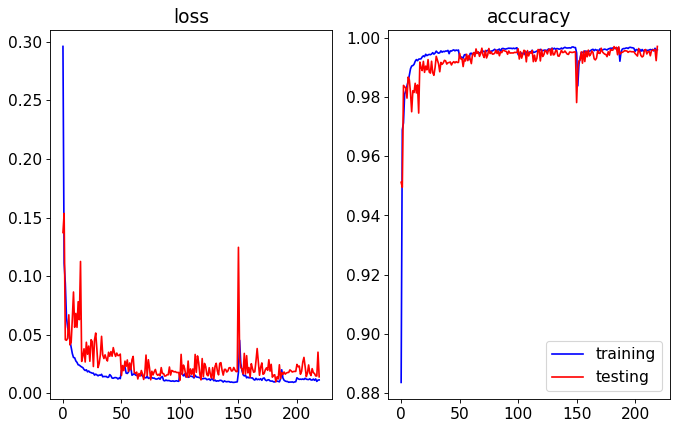

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.87it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


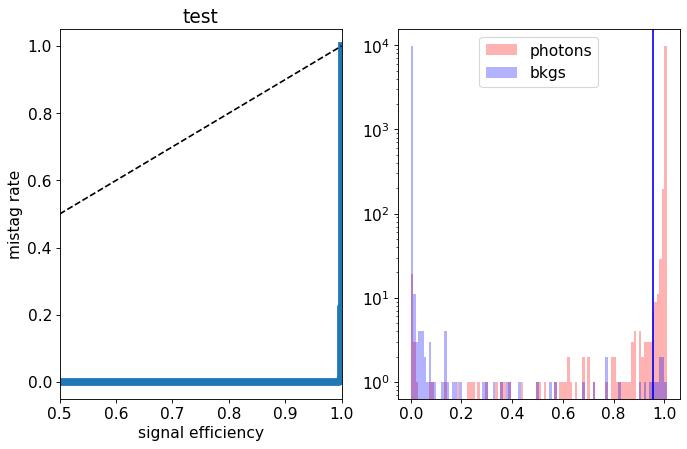

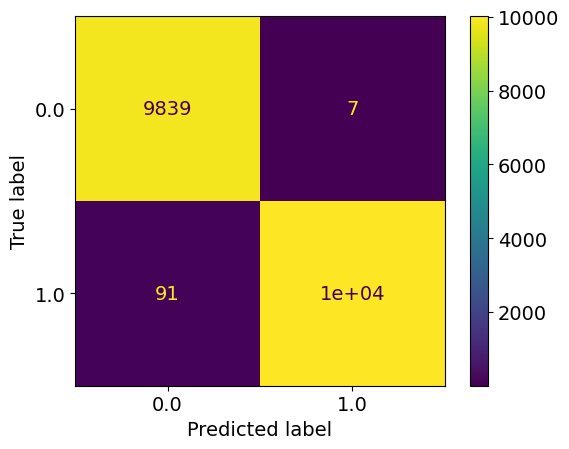

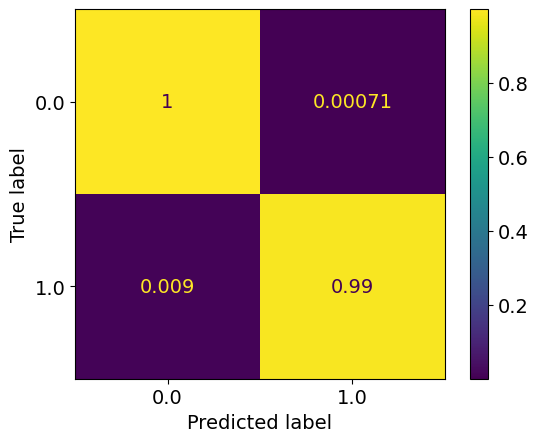

epoch: 220
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.012296283649760228
train acc: 0.99635375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.62it/s]


test loss: 0.020174142112784253
test acc: 0.99533904
epoch: 221
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.027205519829946224
train acc: 0.9901138


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.08it/s]


test loss: 0.01871009256608565
test acc: 0.9941362
epoch: 222
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.01393913120246812
train acc: 0.9953388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.75it/s]


test loss: 0.02555897638804334
test acc: 0.99388564
epoch: 223
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.012599037135056387
train acc: 0.99568963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.78it/s]


test loss: 0.014672737832263331
test acc: 0.99553955
epoch: 224
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.012360585673621841
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.82it/s]


test loss: 0.022256770356119993
test acc: 0.9945372
epoch: 225
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.011914187190480185
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.76it/s]


test loss: 0.015414497038043063
test acc: 0.9960908
epoch: 226
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.011558935582227727
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.66it/s]


test loss: 0.021575261568025726
test acc: 0.9949381
epoch: 227
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.01215268417788016
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]


test loss: 0.02051742491654723
test acc: 0.99533904
epoch: 228
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.010282998496263442
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.024057190349969247
test acc: 0.99533904
epoch: 229
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.010144472292037125
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.027416626926424215
test acc: 0.9945873


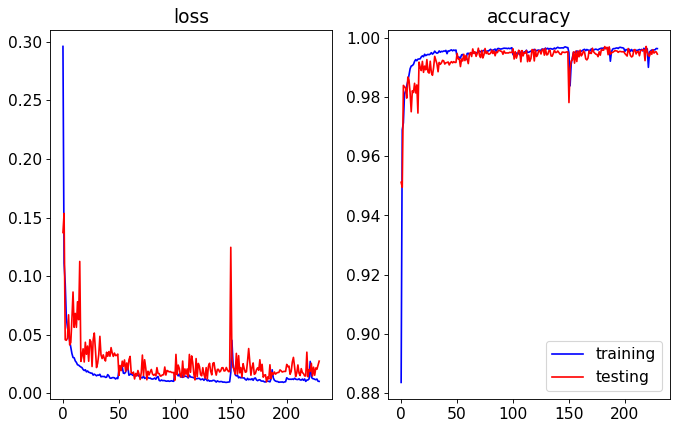

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.92it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


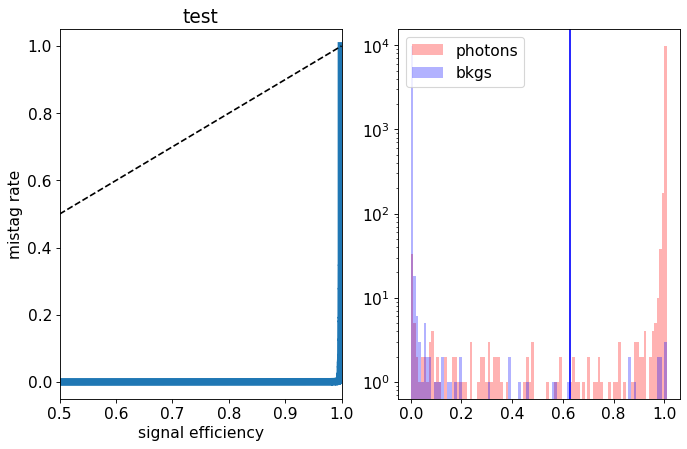

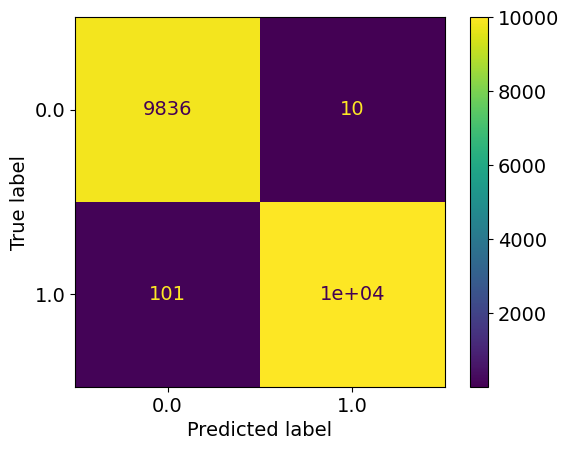

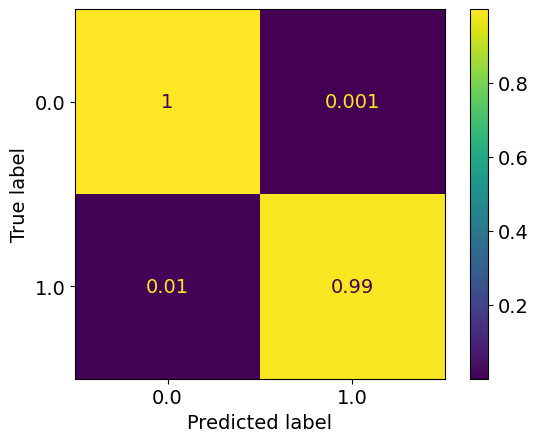

epoch: 230
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.010817369584835989
train acc: 0.99619085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.34it/s]


test loss: 0.028214592753690395
test acc: 0.9946875
epoch: 231
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.011200117343452885
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.019931309077946935
test acc: 0.99533904
epoch: 232
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.010470197866442191
train acc: 0.99619085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.025276795479893574
test acc: 0.99503833
epoch: 233
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.010201107304015043
train acc: 0.9967046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.021065635981572354
test acc: 0.99553955
epoch: 234
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.010371516439930142
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.021079343967892995
test acc: 0.9957901
epoch: 235
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.010545869084180324
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.55it/s]


test loss: 0.019245275195263437
test acc: 0.9957901
epoch: 236
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.53it/s]


train loss: 0.00902575753866925
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.68it/s]


test loss: 0.01907540189430994
test acc: 0.99594045
epoch: 237
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.009785102187297933
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.35it/s]


test loss: 0.017054397992015927
test acc: 0.9962913
epoch: 238
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.52it/s]


train loss: 0.00948634018689504
train acc: 0.99664193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.018338905171035817
test acc: 0.9959906
epoch: 239
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.009519745214362671
train acc: 0.99688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.017911694408907993
test acc: 0.9960908


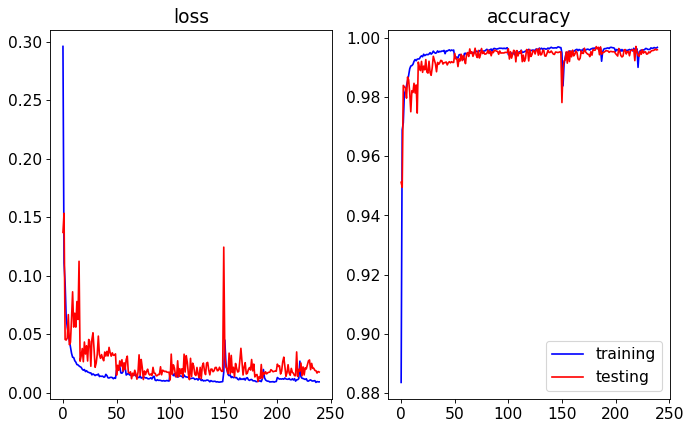

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.55it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


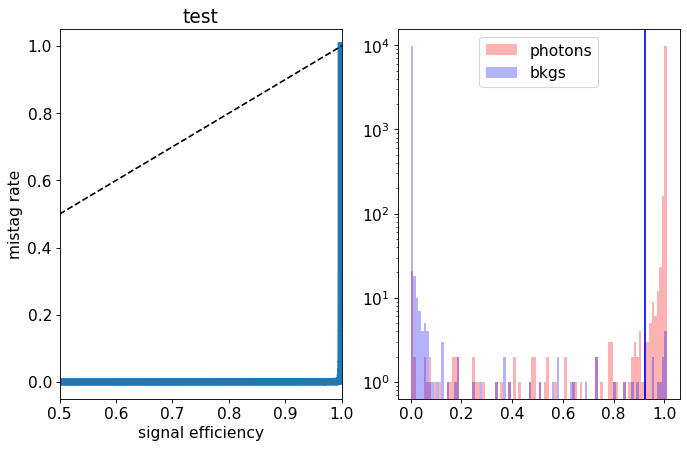

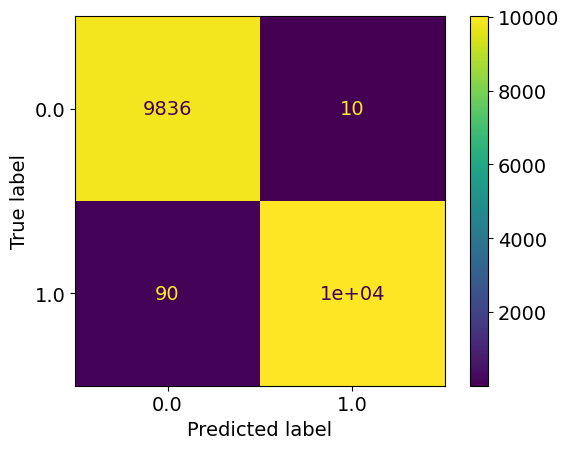

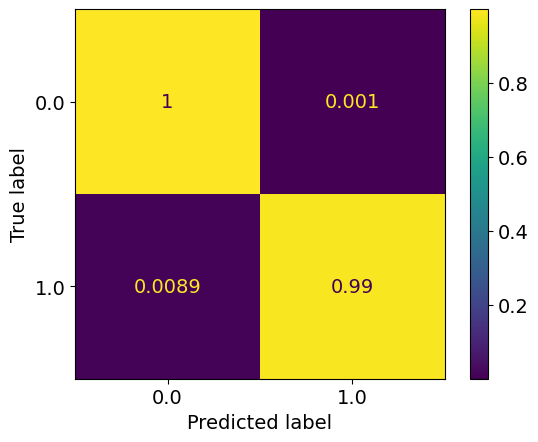

epoch: 240
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.009025428881133862
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.018258819236721405
test acc: 0.9960908
epoch: 241
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.009636339649849975
train acc: 0.9967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.52it/s]


test loss: 0.02097688231151551
test acc: 0.9958903
epoch: 242
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008915327032809728
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.94it/s]


test loss: 0.017205101264955697
test acc: 0.9962913
epoch: 243
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.009641706228075603
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.00it/s]


test loss: 0.02166304425918497
test acc: 0.99574
epoch: 244
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.009369441809796436
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.020988866257967483
test acc: 0.9960908
epoch: 245
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008606416097338174
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.020050414755293306
test acc: 0.9959906
epoch: 246
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.009109534164230382
train acc: 0.9969552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.020747844910468247
test acc: 0.9957901
epoch: 247
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009584670537151396
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.0203347673831398
test acc: 0.9957901
epoch: 248
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.00919477771767832
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.0229173600078759
test acc: 0.99584025
epoch: 249
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009168868704174242
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.020356223921065546
test acc: 0.9958903


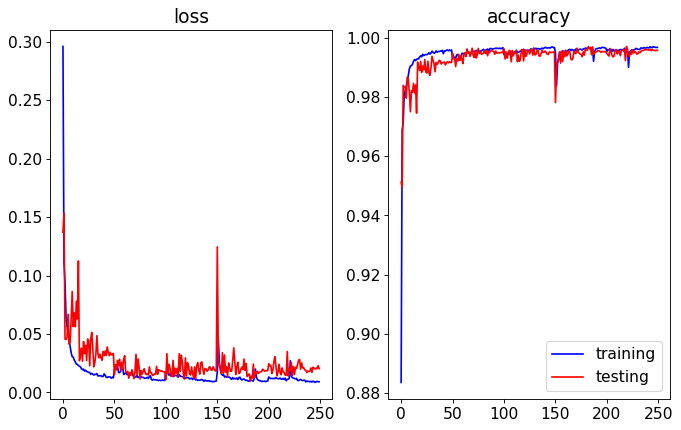

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


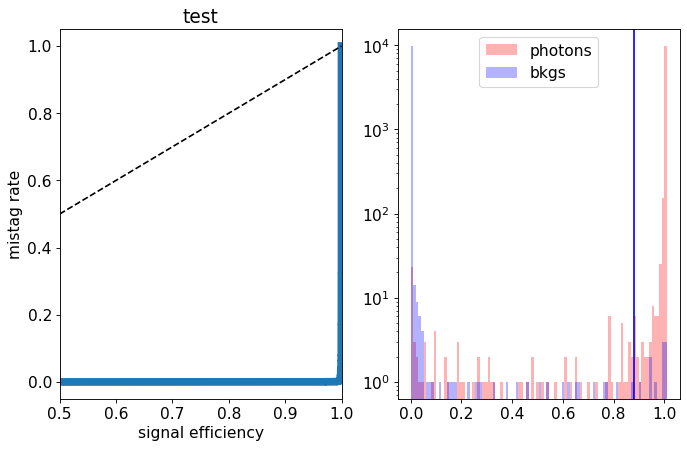

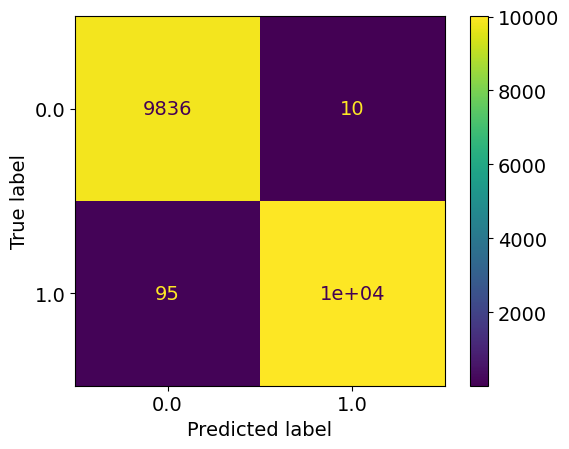

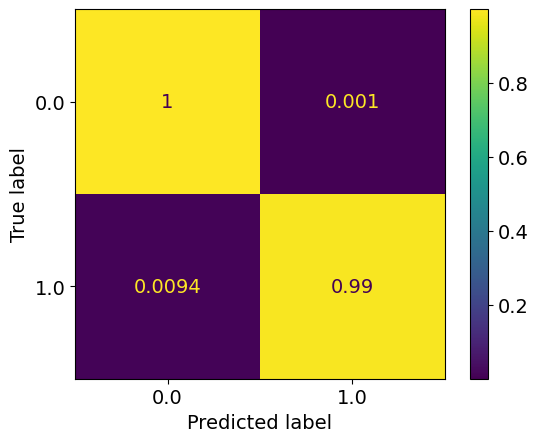

epoch: 250
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.01335759087528255
train acc: 0.9955017


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.00it/s]


test loss: 0.03008558214573628
test acc: 0.99418634
epoch: 251
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.013208860873745116
train acc: 0.995627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.02974006941761164
test acc: 0.99343455
epoch: 252
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.012916951178991819
train acc: 0.9957147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.33it/s]


test loss: 0.023393515100264373
test acc: 0.99418634
epoch: 253
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.012373459679178838
train acc: 0.9957899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.00it/s]


test loss: 0.02207929956699338
test acc: 0.994888
epoch: 254
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.01286333564251015
train acc: 0.9958024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.018612981947679894
test acc: 0.9954393
epoch: 255
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.011320427737768684
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.027302315948284504
test acc: 0.994888
epoch: 256
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.012157762554124929
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.03210365764093962
test acc: 0.9920814
epoch: 257
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.012689810652814028
train acc: 0.99547666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.020523704882875523
test acc: 0.9959906
epoch: 258
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.012092447192877281
train acc: 0.99561447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.01790178834755138
test acc: 0.9954894
epoch: 259
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.012138584394458814
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.49it/s]


test loss: 0.025907095134564715
test acc: 0.99388564


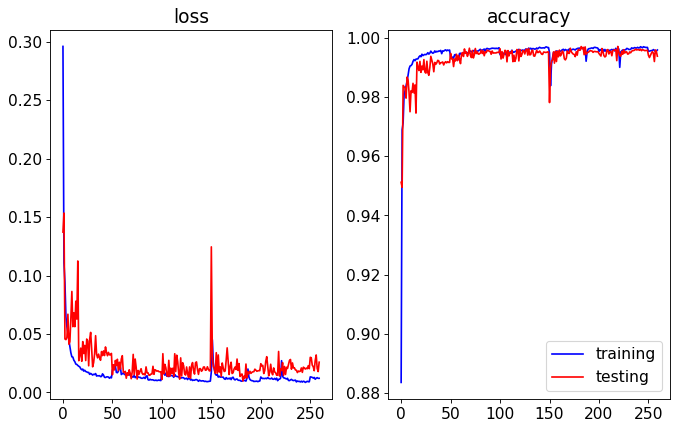

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


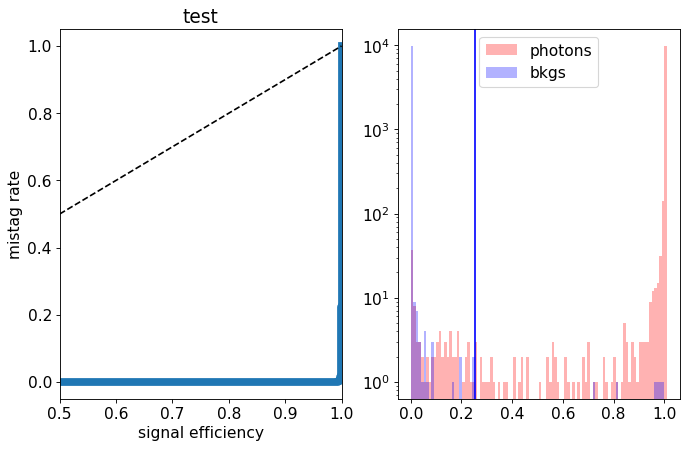

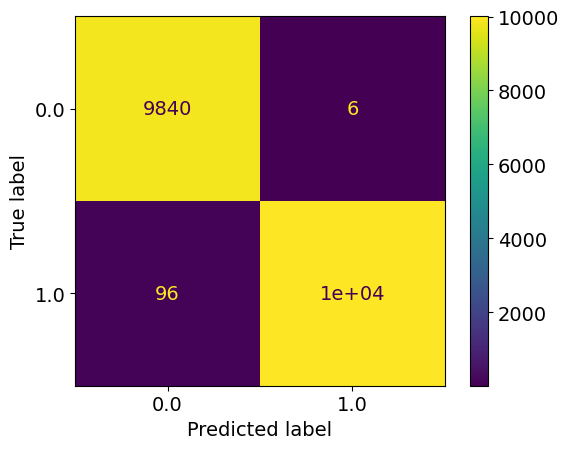

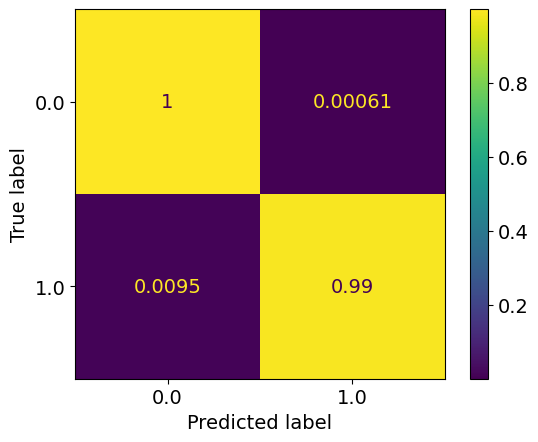

epoch: 260
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.012281707911960663
train acc: 0.99610317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.86it/s]


test loss: 0.02397701399262159
test acc: 0.994888
epoch: 261
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.012780762732996772
train acc: 0.99568963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.021641184277969468
test acc: 0.99478775
epoch: 262
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.012067743735178462
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.02761881607790094
test acc: 0.99243224
epoch: 263
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.012431045231381518
train acc: 0.99576485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.58it/s]


test loss: 0.026029789690202212
test acc: 0.9942866
epoch: 264
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.01141424886117532
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.03004457862858972
test acc: 0.99418634
epoch: 265
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.01061542154769341
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.98it/s]


test loss: 0.027964494094864196
test acc: 0.99388564
epoch: 266
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.010901316769377445
train acc: 0.9962911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.030525003303088907
test acc: 0.99423647
epoch: 267
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.013715206857005429
train acc: 0.99577737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]


test loss: 0.019184029715902665
test acc: 0.9951386
epoch: 268
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.011175020538640883
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.020089206454084726
test acc: 0.9946875
epoch: 269
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.0106889583872381
train acc: 0.9963412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.018965382377673985
test acc: 0.99594045


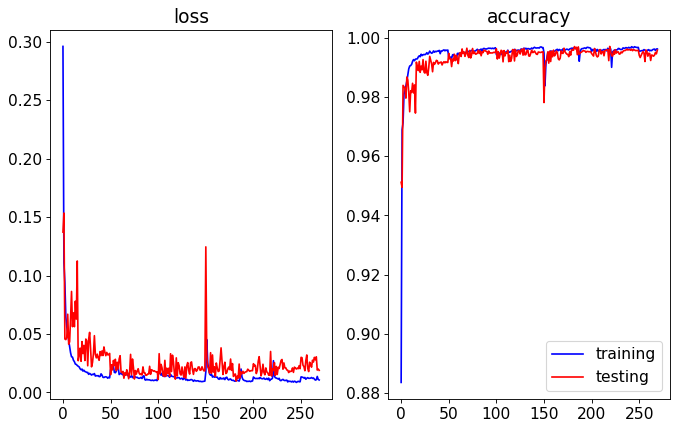

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.93it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


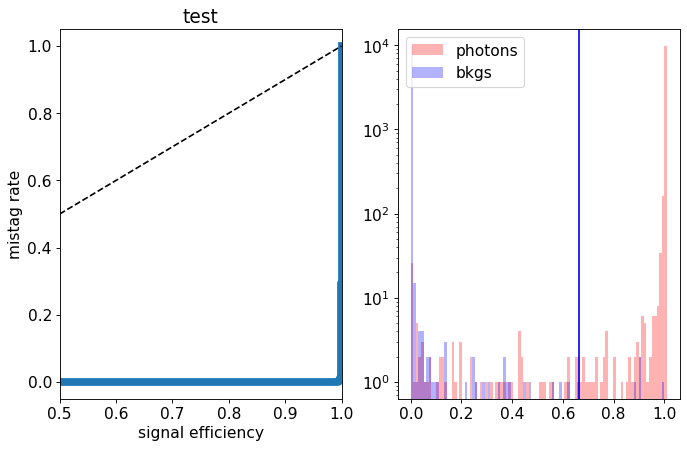

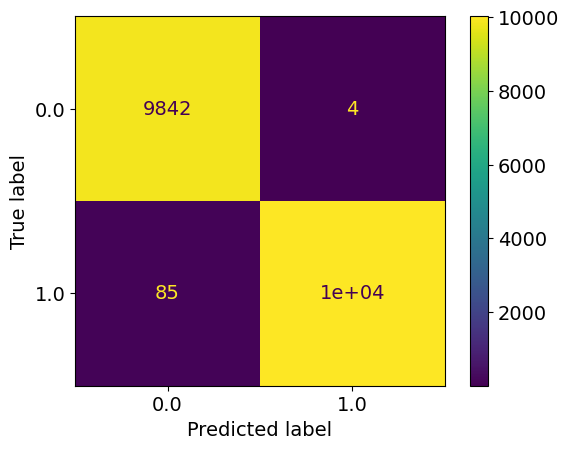

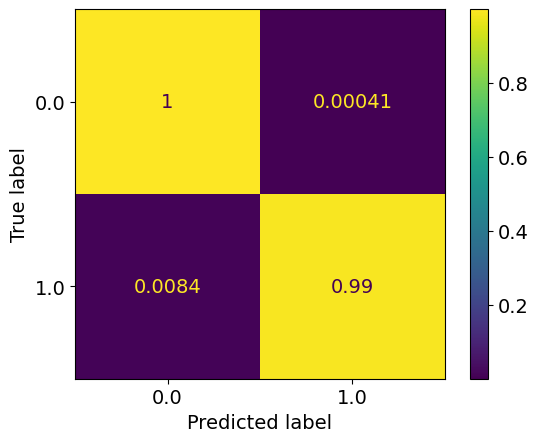

epoch: 270
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.010385691851049716
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.053217185715980386
test acc: 0.9907282
epoch: 271
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.010937435361348204
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.02it/s]


test loss: 0.024441170138957472
test acc: 0.9951386
epoch: 272
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.012112321269545537
train acc: 0.99636626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.012222454545896171
test acc: 0.99644166
epoch: 273
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.58it/s]


train loss: 0.017198449423807716
train acc: 0.993948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.0216752955739674
test acc: 0.9951887
epoch: 274
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.010740985930549786
train acc: 0.9961407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.031871712198207044
test acc: 0.9930838
epoch: 275
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.010713993813217013
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.02540456078884959
test acc: 0.99403596
epoch: 276
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.010307900791765372
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.014435642451965524
test acc: 0.99649173
epoch: 277
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.009396596426845998
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.023582005784299004
test acc: 0.99533904
epoch: 278
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010132514995456771
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.018090550413677086
test acc: 0.99574
epoch: 279
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.009558612732866123
train acc: 0.99664193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.022585022280669793
test acc: 0.9952889


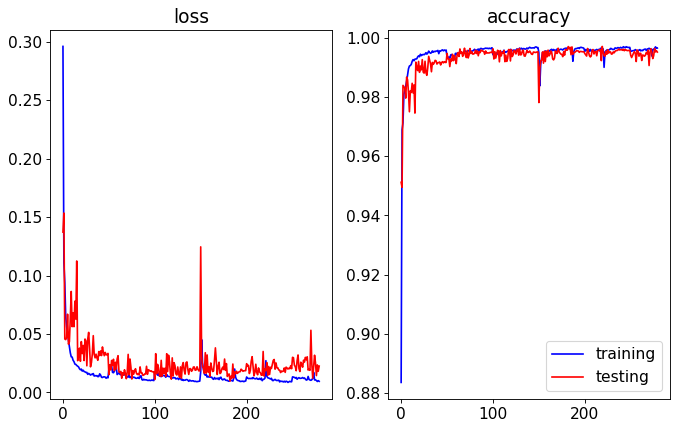

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


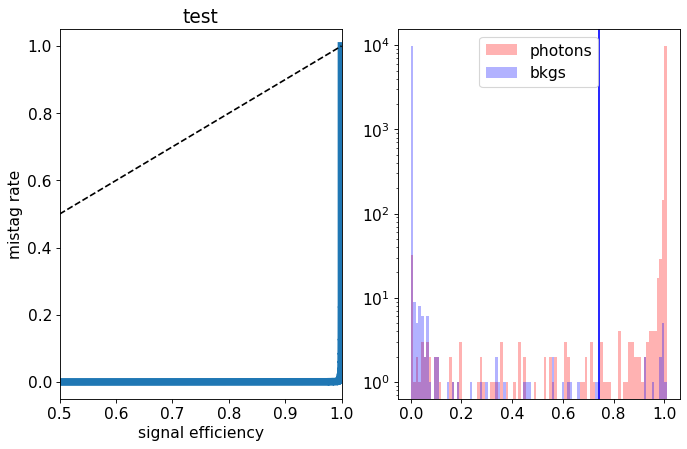

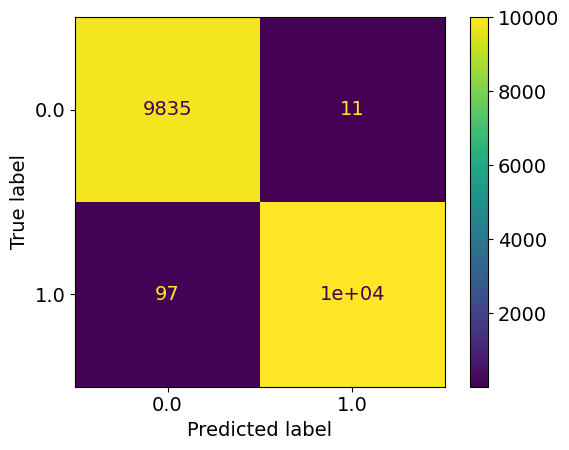

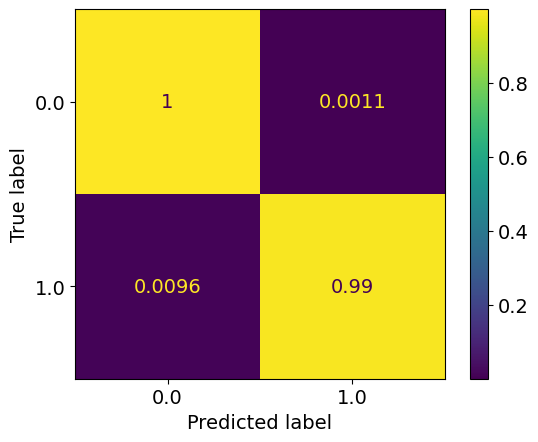

epoch: 280
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009787083272874328
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.021739839401347768
test acc: 0.9951386
epoch: 281
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.009256093274945752
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.015198336329216118
test acc: 0.99654186
epoch: 282
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008713194634303851
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.017038275266874254
test acc: 0.9963414
epoch: 283
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.00906870822367087
train acc: 0.99685496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.95it/s]


test loss: 0.027015737780910806
test acc: 0.99423647
epoch: 284
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008560055422379658
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.021700594890717184
test acc: 0.9955896
epoch: 285
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.009444791118182829
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.026083276451305103
test acc: 0.9952889
epoch: 286
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.009369551089467175
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.022256455235679717
test acc: 0.99538916
epoch: 287
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009255872680561413
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.022703768606855673
test acc: 0.9954393
epoch: 288
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.008639873015956472
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.026988556364599122
test acc: 0.9949381
epoch: 289
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008331525819757522
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.02415478176135366
test acc: 0.9954894


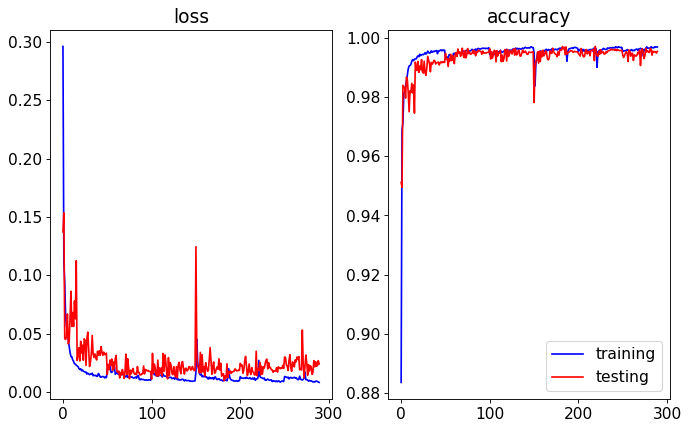

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


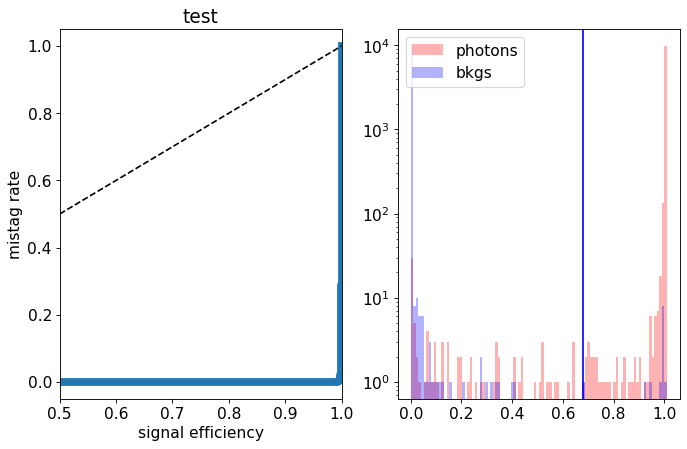

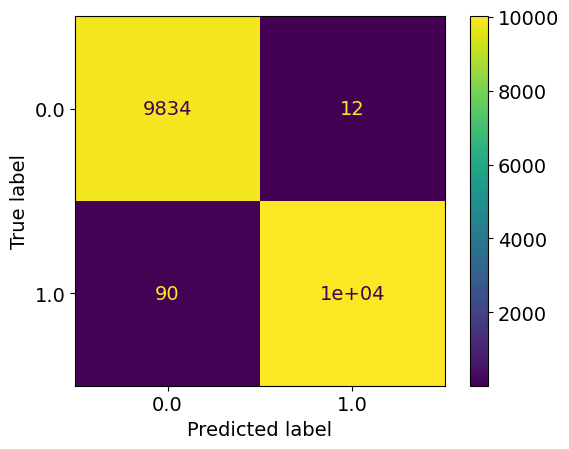

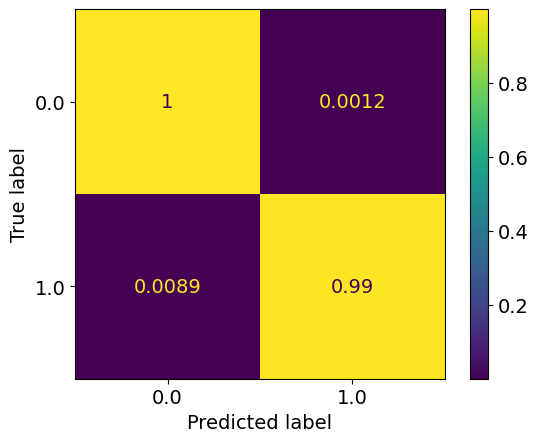

epoch: 290
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008829272778725613
train acc: 0.9971933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.01967659687215928
test acc: 0.9958903
epoch: 291
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008989997388822713
train acc: 0.99685496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.01905673557335189
test acc: 0.9959906
epoch: 292
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.008462273753030419
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.025851266836980358
test acc: 0.99538916
epoch: 293
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008232471422351369
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.020845589244666316
test acc: 0.99568987
epoch: 294
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.00846439230907035
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.020970160372277915
test acc: 0.99568987
epoch: 295
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008138626166654112
train acc: 0.99718076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.02089500394450785
test acc: 0.99568987
epoch: 296
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.008265848435257794
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.020944463333067046
test acc: 0.99574
epoch: 297
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008458996870131023
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.020702327548539925
test acc: 0.99563974
epoch: 298
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.58it/s]


train loss: 0.008387935704444887
train acc: 0.9972434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.02069622532957617
test acc: 0.99574
epoch: 299
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.008302892753315756
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.02it/s]


test loss: 0.020633746688177138
test acc: 0.99574


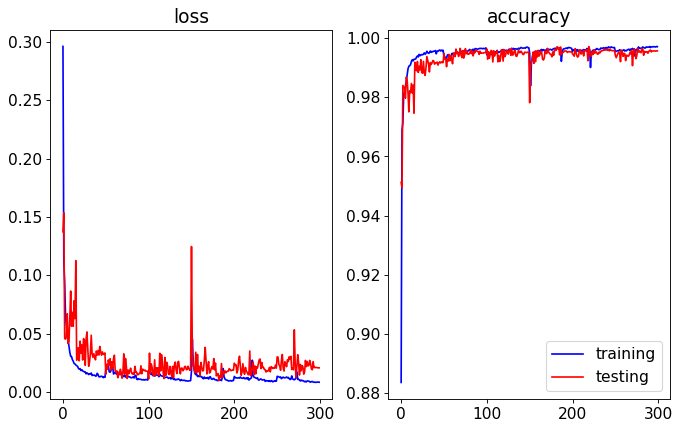

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


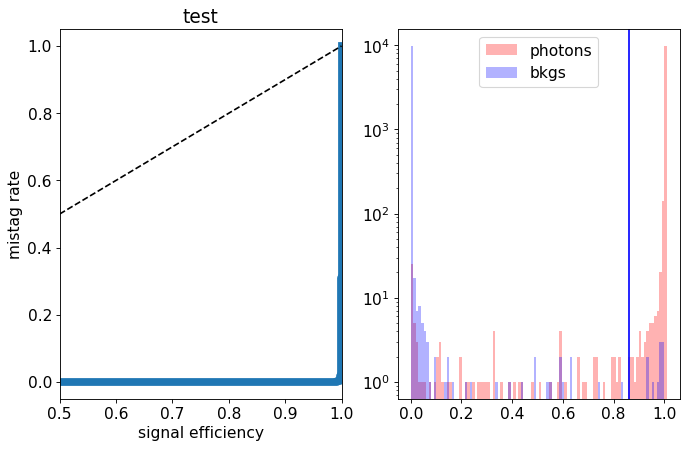

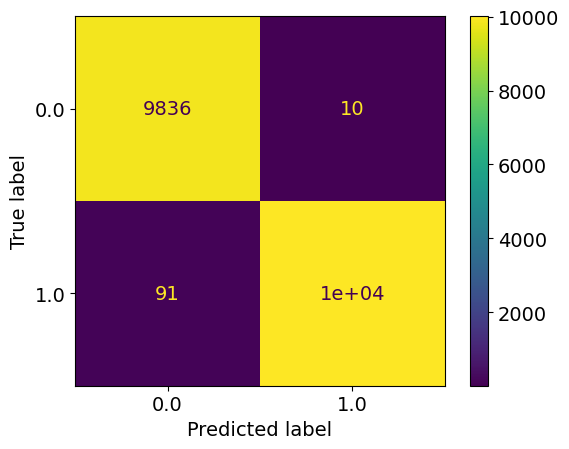

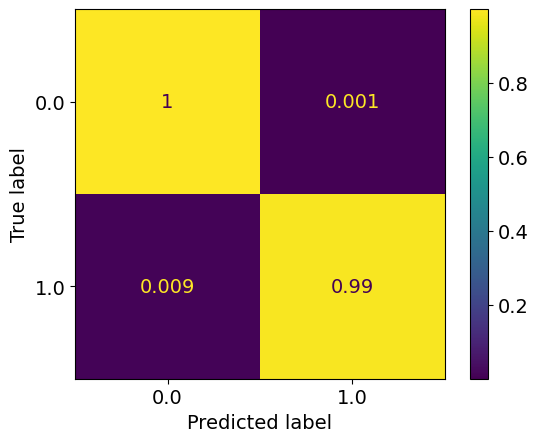

epoch: 300
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.011069253017542078
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.74it/s]


test loss: 0.04340572760317146
test acc: 0.9920814
epoch: 301
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.014655405208086178
train acc: 0.99530125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.63it/s]


test loss: 0.014665287116633193
test acc: 0.99568987
epoch: 302
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.013418840621866298
train acc: 0.9953513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.016711068803595158
test acc: 0.99644166
epoch: 303
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.011741558479329865
train acc: 0.9961282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.84it/s]


test loss: 0.03445138050558265
test acc: 0.992332
epoch: 304
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.010518291211210182
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.016036714675411692
test acc: 0.9955896
epoch: 305
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.010456883886293856
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.028753071656544362
test acc: 0.9943868
epoch: 306
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.011577039013561139
train acc: 0.9960906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.96it/s]


test loss: 0.016773790136486402
test acc: 0.9957901
epoch: 307
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.011127831916487993
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.022660265216686907
test acc: 0.99594045
epoch: 308
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.011538862953798275
train acc: 0.9962535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.017432238930589792
test acc: 0.9954393
epoch: 309
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.01105987485167514
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.03439168105422355
test acc: 0.9939859


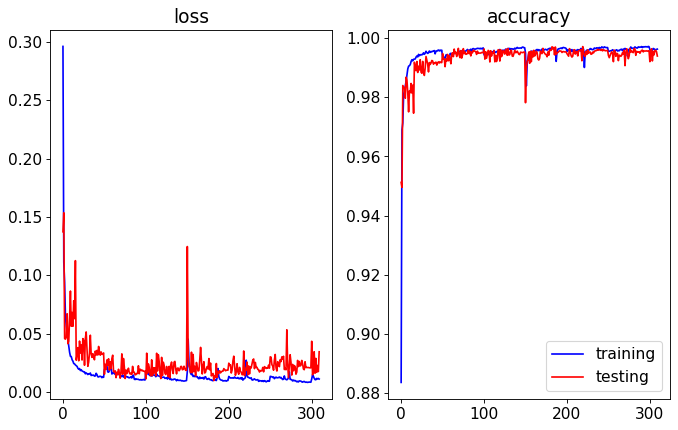

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


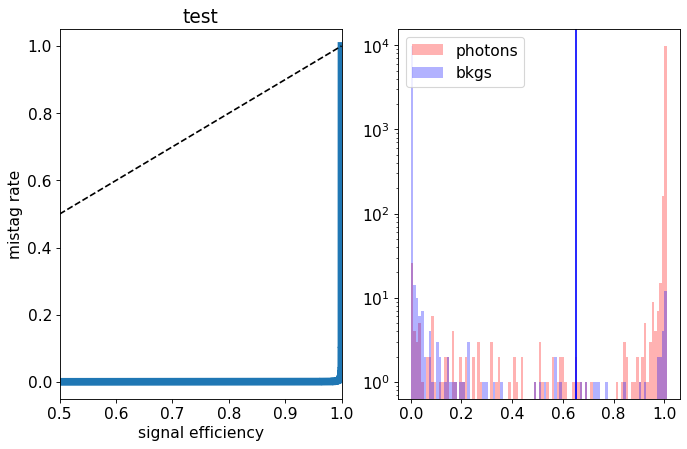

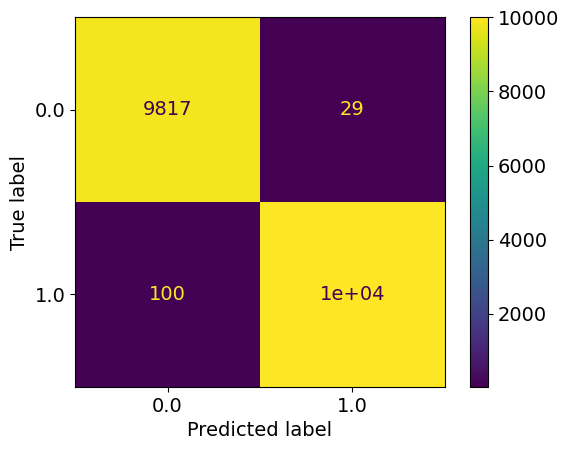

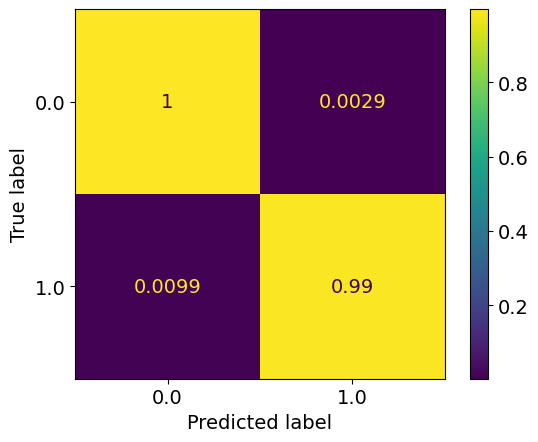

epoch: 310
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.011332953732565994
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.03495204662185108
test acc: 0.9930838
epoch: 311
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010844799194749056
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.60it/s]


test loss: 0.03497591690735563
test acc: 0.9940861
epoch: 312
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.010809080098814735
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.04922820970429765
test acc: 0.99243224
epoch: 313
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.011276062782151224
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.032116958369870725
test acc: 0.99463737
epoch: 314
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.010495451241627391
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.017495061067165807
test acc: 0.99624115
epoch: 315
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010180445422710316
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.03148028677327709
test acc: 0.9937854
epoch: 316
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.01044548029399741
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.01789372497210827
test acc: 0.9959906
epoch: 317
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010652571204730914
train acc: 0.996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.01993923132570618
test acc: 0.9954393
epoch: 318
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.010097360561604688
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.025309095994838143
test acc: 0.9945372
epoch: 319
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.010746273301183872
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.020263832089874673
test acc: 0.99538916


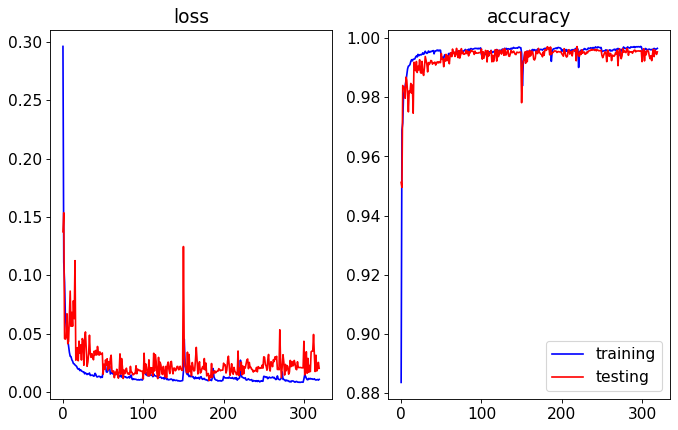

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


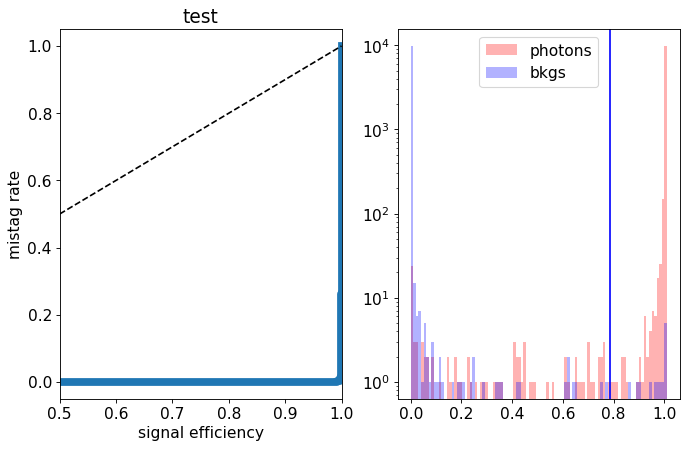

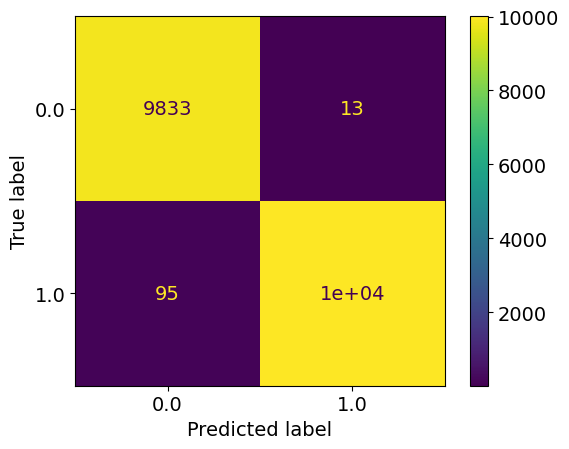

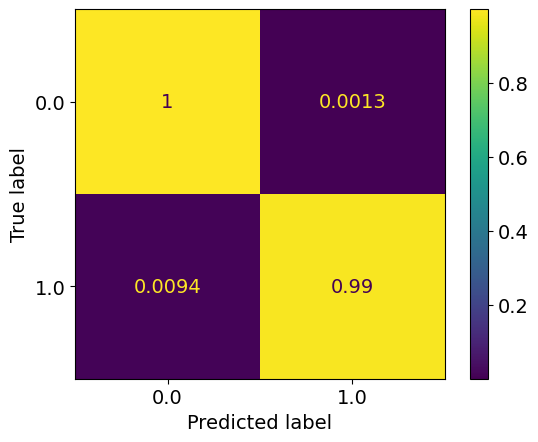

epoch: 320
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.009754387574937583
train acc: 0.99688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.032777644813690776
test acc: 0.99403596
epoch: 321
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.010339000246682162
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.044262230047024786
test acc: 0.99137974
epoch: 322
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009947472747151197
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.88it/s]


test loss: 0.025528162130098387
test acc: 0.99508846
epoch: 323
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.00916182658975638
train acc: 0.9969176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.02838450134731829
test acc: 0.99418634
epoch: 324
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009595029165198025
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.018149107606886365
test acc: 0.996191
epoch: 325
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.008819465917209772
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.022139574891137753
test acc: 0.99553955
epoch: 326
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009165024211740017
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.025071696042526608
test acc: 0.99533904
epoch: 327
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.009519746298588979
train acc: 0.99698025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.031849648146068346
test acc: 0.9942866
epoch: 328
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009437802978190215
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.018232033012763542
test acc: 0.99574
epoch: 329
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.009017424541091158
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.02531339429140858
test acc: 0.9949381


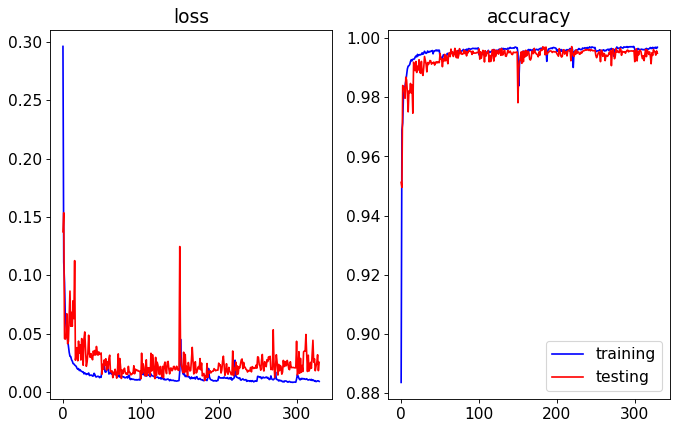

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


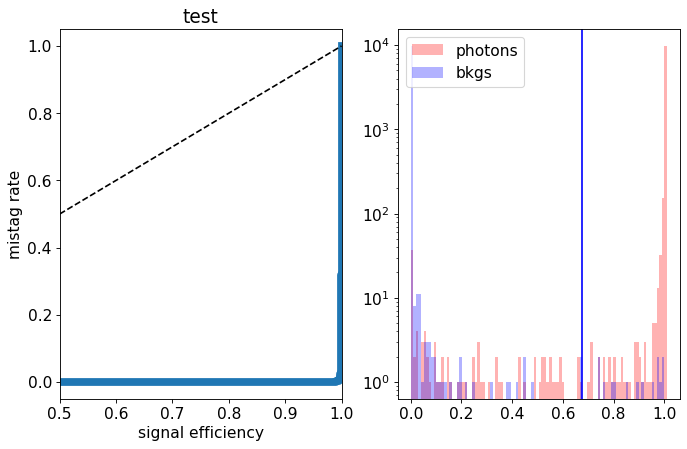

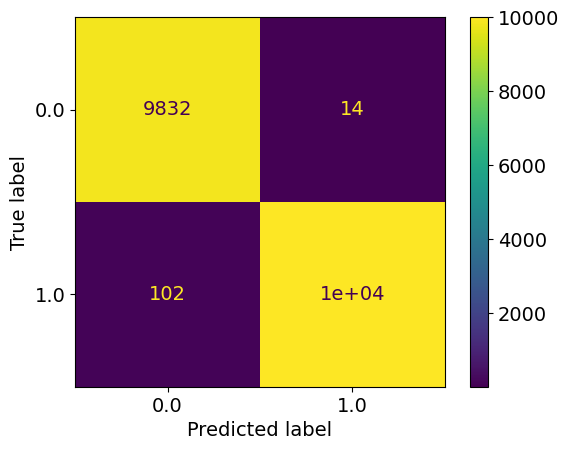

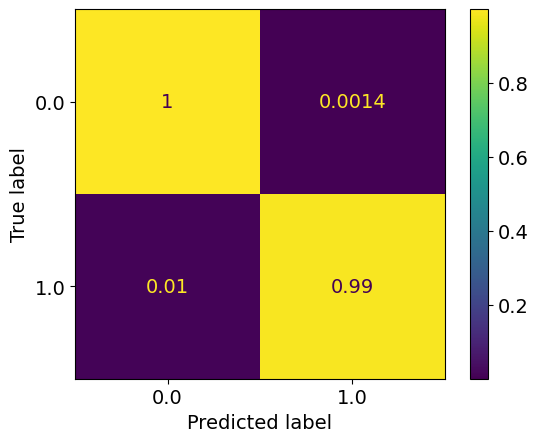

epoch: 330
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008749756748343248
train acc: 0.99698025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.02225500059156569
test acc: 0.99563974
epoch: 331
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.008702710164891584
train acc: 0.99714315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.023494237340534765
test acc: 0.9952889
epoch: 332
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.00910092023421846
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.00it/s]


test loss: 0.020437446867992336
test acc: 0.9954393
epoch: 333
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008152943765640314
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.76it/s]


test loss: 0.02447854883126531
test acc: 0.99503833
epoch: 334
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.00880426883782432
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.02371105811342953
test acc: 0.9955896
epoch: 335
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.008143279964274362
train acc: 0.99714315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.021951545138589983
test acc: 0.9954894
epoch: 336
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.008031923540193699
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.027234704920213997
test acc: 0.9949381
epoch: 337
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008686976344411526
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.026302924932304662
test acc: 0.9945873
epoch: 338
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.00898198922574798
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.024674648155376094
test acc: 0.99523884
epoch: 339
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008204977571922564
train acc: 0.99710554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.02689089991754907
test acc: 0.99533904


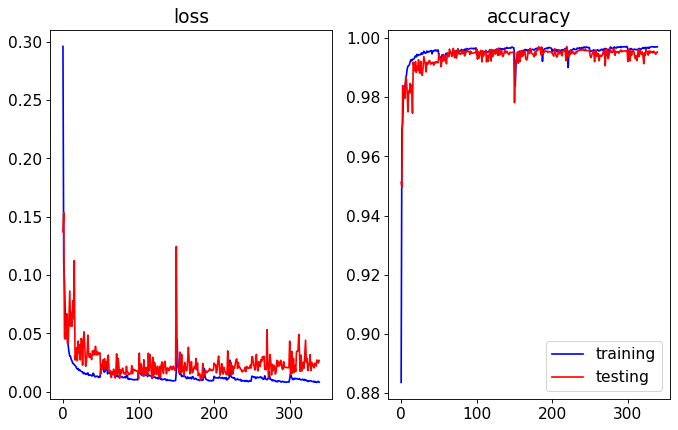

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


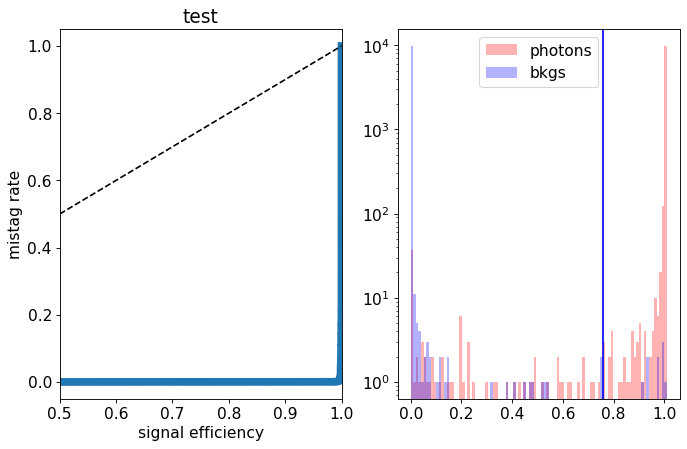

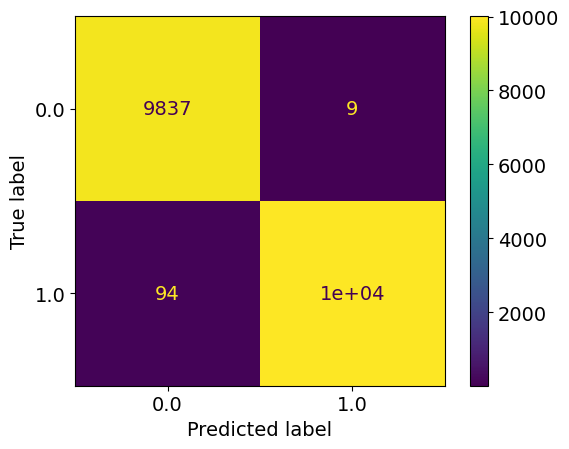

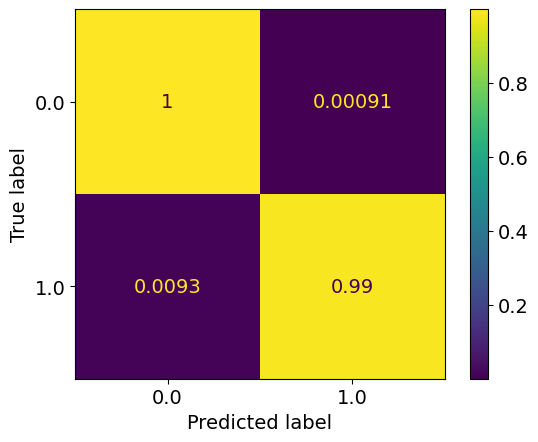

epoch: 340
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.00794150761967735
train acc: 0.99729353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.77it/s]


test loss: 0.02169725885751712
test acc: 0.99614096
epoch: 341
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.008748001696145745
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.31it/s]


test loss: 0.020938919033249154
test acc: 0.99614096
epoch: 342
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.19it/s]


train loss: 0.008338397087741282
train acc: 0.99726844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.021113439528990592
test acc: 0.99624115
epoch: 343
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.007738955178186854
train acc: 0.99748147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.94it/s]


test loss: 0.022727091283152676
test acc: 0.9957901
epoch: 344
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.007362381375304409
train acc: 0.9974188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.02276321723251626
test acc: 0.99584025
epoch: 345
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.00812634619241937
train acc: 0.9973687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.022580166119630176
test acc: 0.99584025
epoch: 346
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008334509132659313
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.95it/s]


test loss: 0.021316441286163515
test acc: 0.9960407
epoch: 347
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.007783026961736942
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.023591575248086454
test acc: 0.99614096
epoch: 348
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.007430382409492906
train acc: 0.99748147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.023506496885709244
test acc: 0.99614096
epoch: 349
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.007907602797355247
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.02095054225227453
test acc: 0.99614096


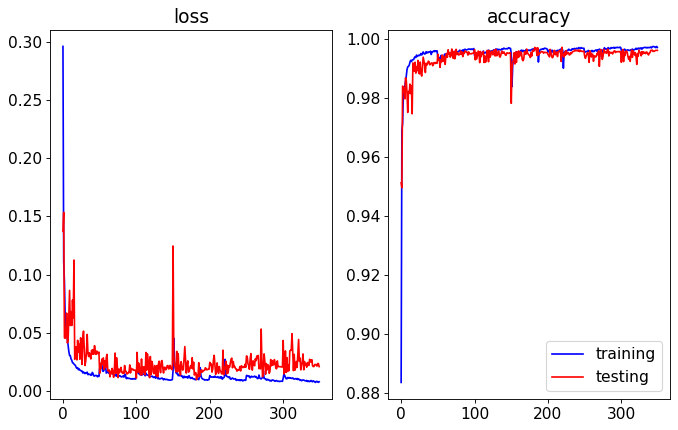

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


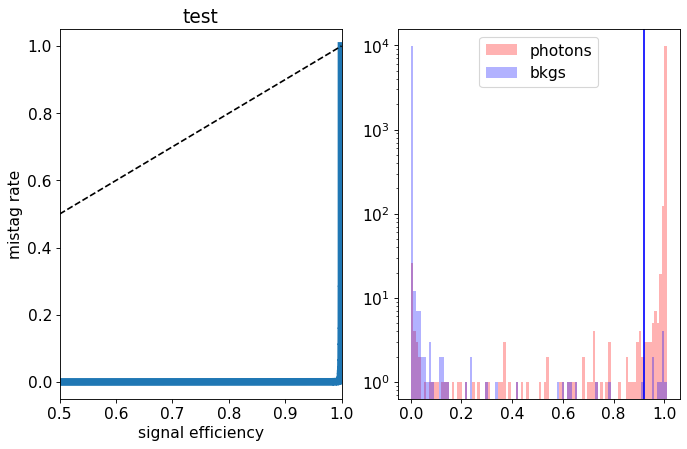

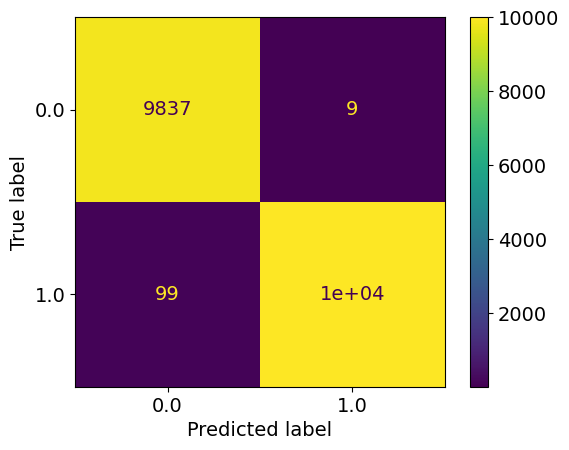

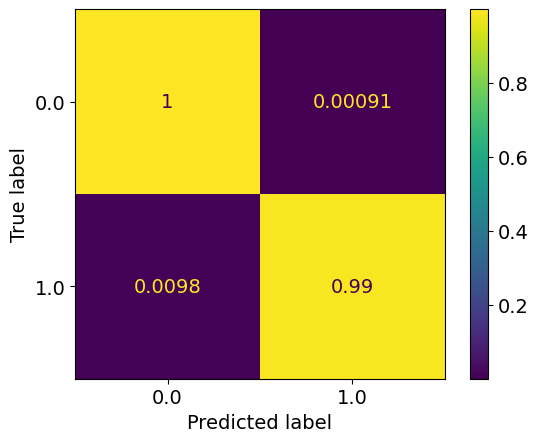

epoch: 350
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009994246350573515
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.028163898994748974
test acc: 0.9952889
epoch: 351
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.01273286297792263
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.03594988799373181
test acc: 0.99423647
epoch: 352
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.012530991260247017
train acc: 0.9957147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.01877602132384816
test acc: 0.9963414
epoch: 353
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.27it/s]


train loss: 0.011498235750755767
train acc: 0.9960405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.017644032507258302
test acc: 0.9957901
epoch: 354
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.011062626348141192
train acc: 0.9962535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.016661525002906703
test acc: 0.99614096
epoch: 355
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.010962171164695729
train acc: 0.9960906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.016151077964904663
test acc: 0.99669224
epoch: 356
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.01060479761928552
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.03880415042016573
test acc: 0.99358493
epoch: 357
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010992095652800038
train acc: 0.9961783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.94it/s]


test loss: 0.015635534711798432
test acc: 0.9962913
epoch: 358
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.28it/s]


train loss: 0.009375169468390296
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.67it/s]


test loss: 0.02966309553834007
test acc: 0.99448705
epoch: 359
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.50it/s]


train loss: 0.011259363236006978
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.052223398507682275
test acc: 0.9932341


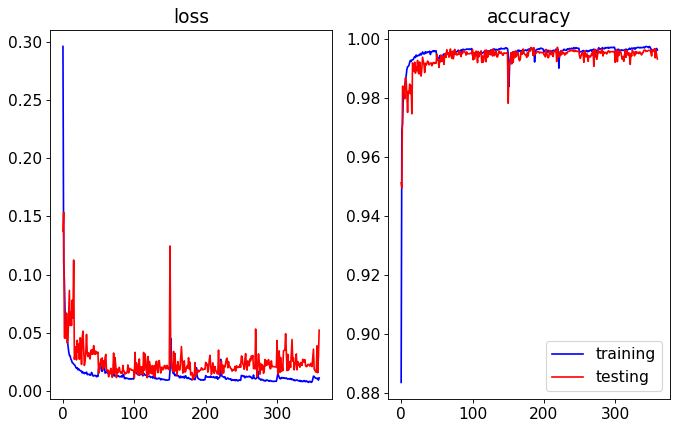

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


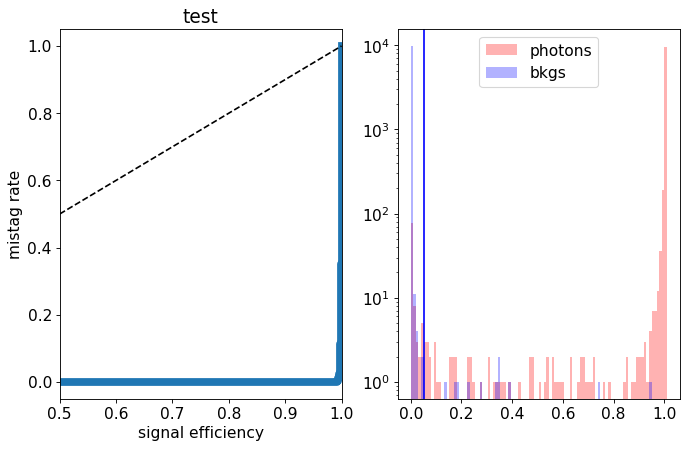

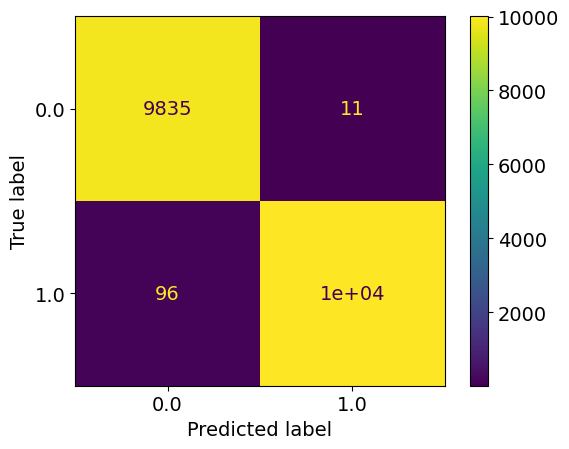

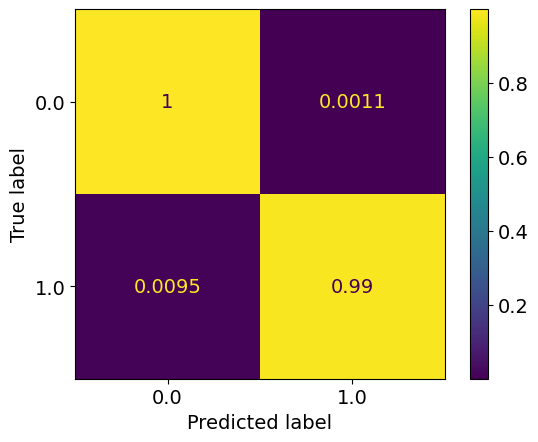

epoch: 360
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010849653343572768
train acc: 0.9961407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.02252937913598383
test acc: 0.99584025
epoch: 361
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.011543441875190508
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.01581702451221645
test acc: 0.9968927
epoch: 362
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009971378424114533
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.03765633522176787
test acc: 0.9939859
epoch: 363
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01142126570821754
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.017840306740254164
test acc: 0.99649173
epoch: 364
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.009777613761720367
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.02535438940685708
test acc: 0.99508846
epoch: 365
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.009654516771172609
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.03270422297817491
test acc: 0.9939859
epoch: 366
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0096549123409166
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.028577017861500603
test acc: 0.99538916
epoch: 367
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.00915630339229088
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.04551771542687407
test acc: 0.9924823
epoch: 368
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.012647186612289871
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.036320323918891305
test acc: 0.99303365
epoch: 369
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.013104271635507866
train acc: 0.9953639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.015529586026894
test acc: 0.9958903


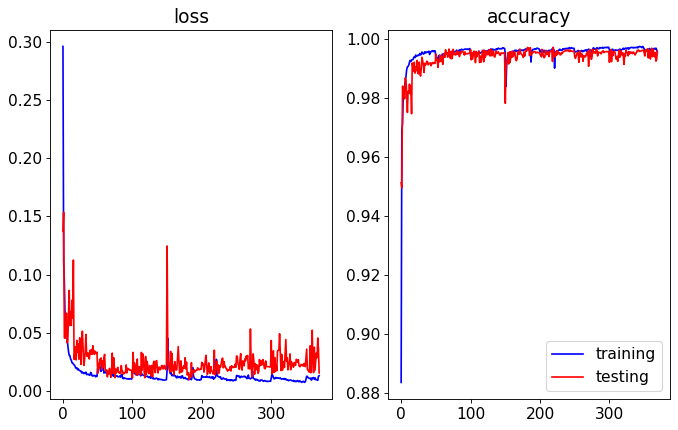

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


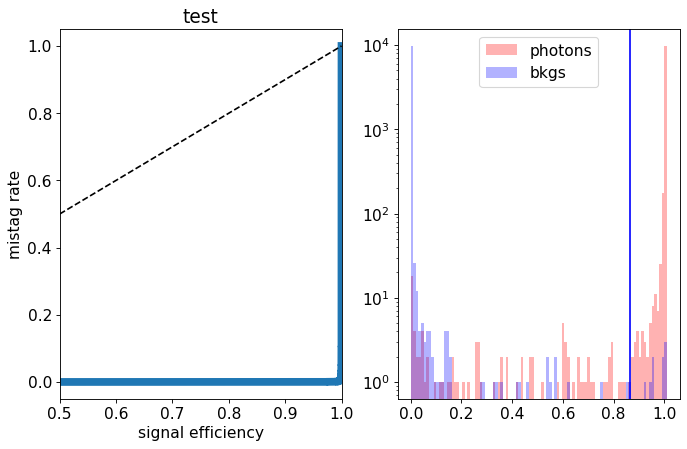

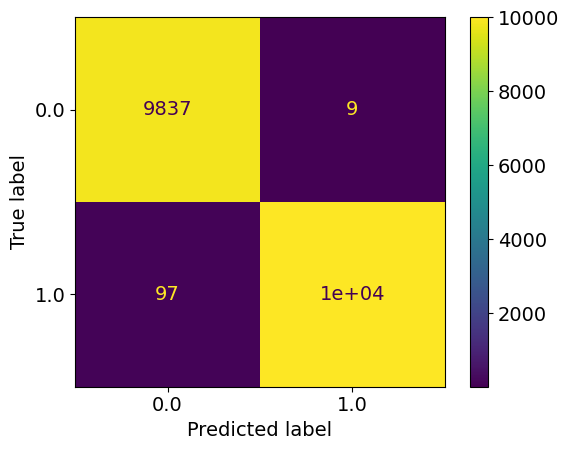

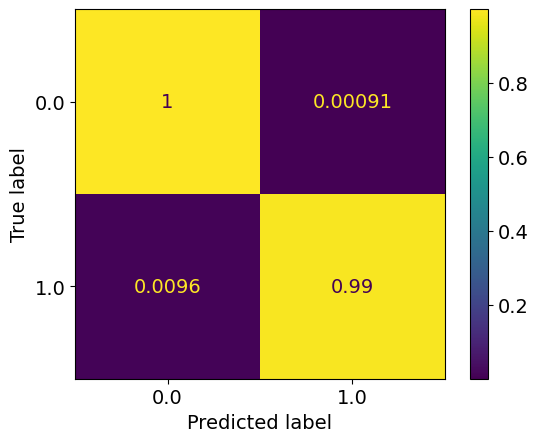

epoch: 370
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.009327980483805677
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.72it/s]


test loss: 0.020191683276446864
test acc: 0.9957901
epoch: 371
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009442013055442502
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.018362192830810434
test acc: 0.99644166
epoch: 372
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.010466476785950363
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.02864775655325502
test acc: 0.9940861
epoch: 373
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.008995222571087
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.020694408403120607
test acc: 0.99574
epoch: 374
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008729661114842595
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.024634053016437545
test acc: 0.99523884
epoch: 375
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.009053452635434136
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.017060373534845626
test acc: 0.9963414
epoch: 376
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.53it/s]


train loss: 0.009001290309894482
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.023676990599864545
test acc: 0.9955896
epoch: 377
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.00866683922645483
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.017680128514364374
test acc: 0.9966421
epoch: 378
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009118676702309498
train acc: 0.9969176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.023030732515240637
test acc: 0.9954393
epoch: 379
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008748526818730604
train acc: 0.99682987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.42it/s]


test loss: 0.019330742021231667
test acc: 0.99649173


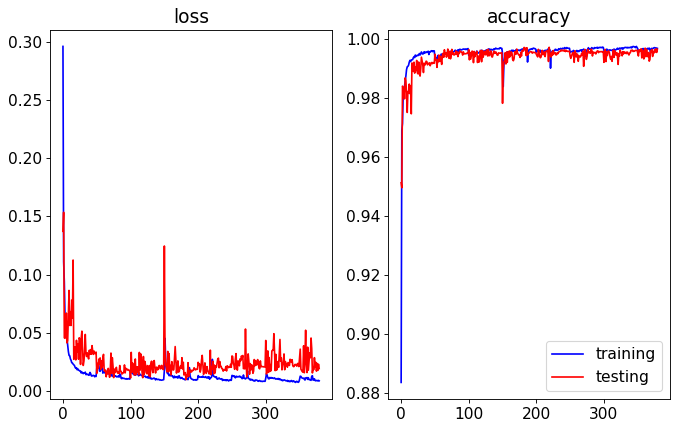

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


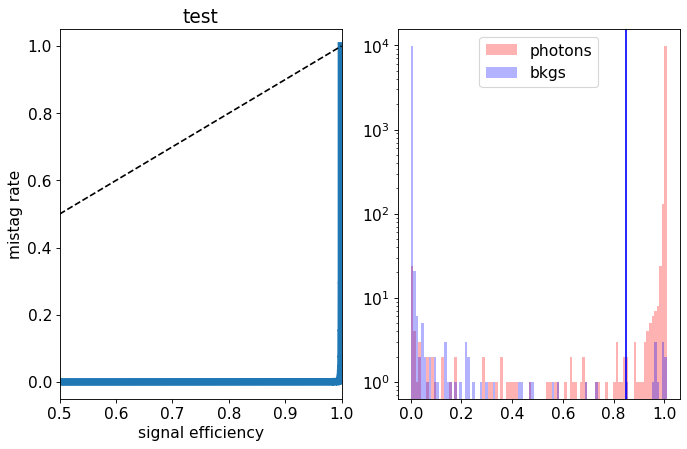

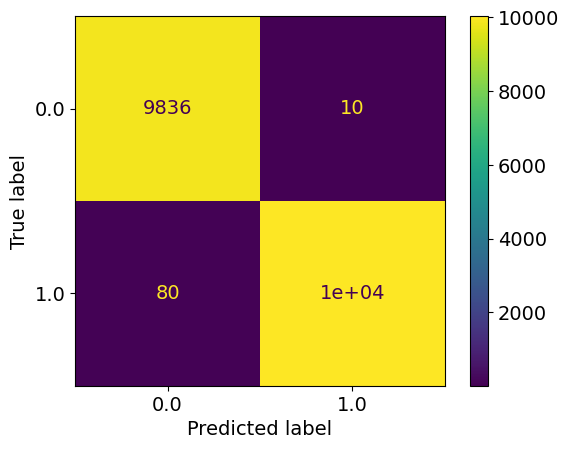

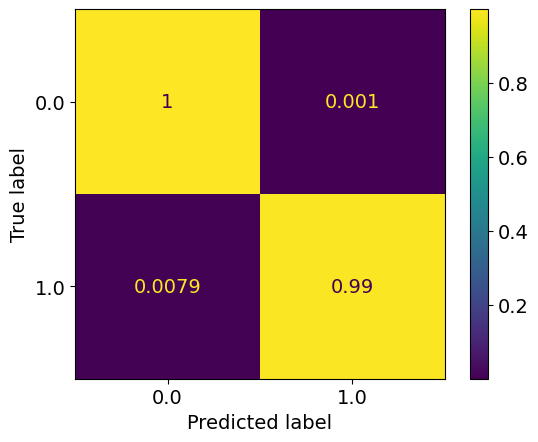

epoch: 380
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008235653968717116
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.019038428849479018
test acc: 0.99654186
epoch: 381
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008616641480818829
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.65it/s]


test loss: 0.028028774666702647
test acc: 0.99553955
epoch: 382
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009268522574446781
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.021779788372120547
test acc: 0.9960908
epoch: 383
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008704395912615443
train acc: 0.9972183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.02224100219695281
test acc: 0.99523884
epoch: 384
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.009850669193892556
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.02090053680791136
test acc: 0.99624115
epoch: 385
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.007755679459899226
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.80it/s]


test loss: 0.022275095774709958
test acc: 0.99563974
epoch: 386
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.008336929539253296
train acc: 0.9972058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.02010655574841782
test acc: 0.99614096
epoch: 387
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008644132260684926
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.80it/s]


test loss: 0.02657775684030425
test acc: 0.9952889
epoch: 388
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.007972720562703664
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.023184244931839845
test acc: 0.99574
epoch: 389
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.007895266953873128
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.022215505064677392
test acc: 0.9962913


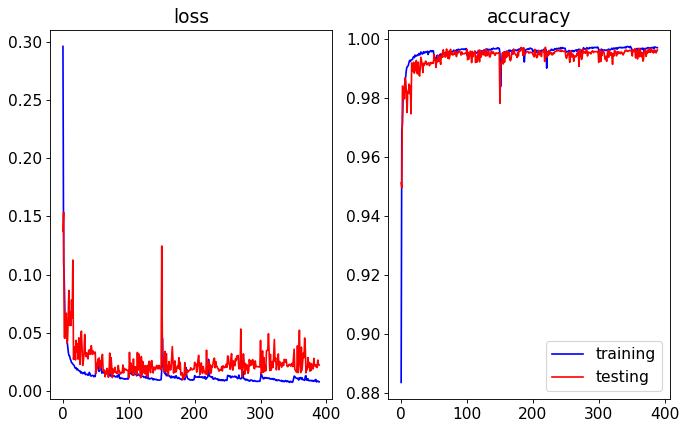

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.17it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


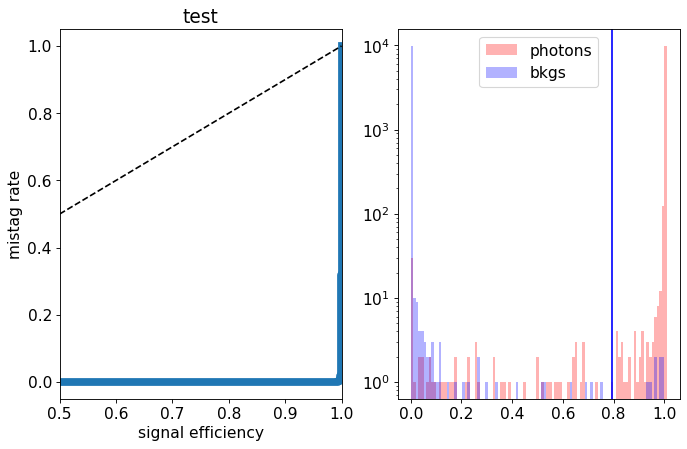

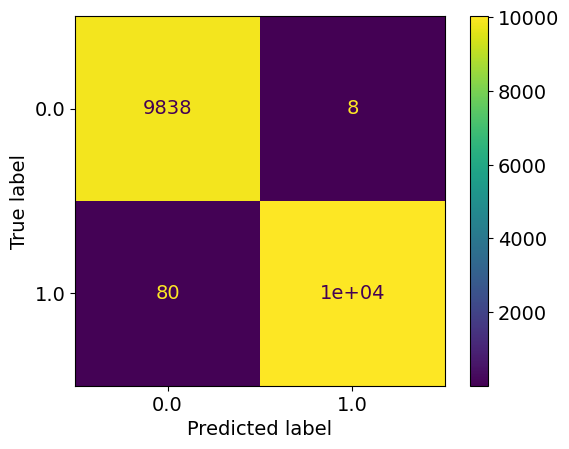

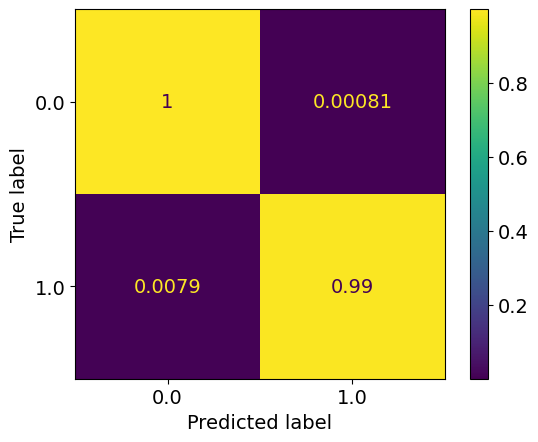

epoch: 390
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.007768070040950065
train acc: 0.9972058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.022929410367449984
test acc: 0.9958903
epoch: 391
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.007784452457015483
train acc: 0.9972434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.02083571625938502
test acc: 0.99614096
epoch: 392
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.007661336993819464
train acc: 0.9973311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.023121801656944788
test acc: 0.9962913
epoch: 393
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.008014420873169273
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.0214351141885345
test acc: 0.9960407
epoch: 394
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008047181395978889
train acc: 0.99710554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.023415602248004527
test acc: 0.9957901
epoch: 395
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.007497522979282445
train acc: 0.9973937


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.02238810043405358
test acc: 0.9958903
epoch: 396
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.007468762723276829
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.022000965882826302
test acc: 0.9960407
epoch: 397
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.00752384917777249
train acc: 0.9973687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.021320319486061206
test acc: 0.9960407
epoch: 398
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008057336326438323
train acc: 0.99729353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.02127994074715603
test acc: 0.9960908
epoch: 399
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.007613234263635965
train acc: 0.9972559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.021313672058835543
test acc: 0.9960908


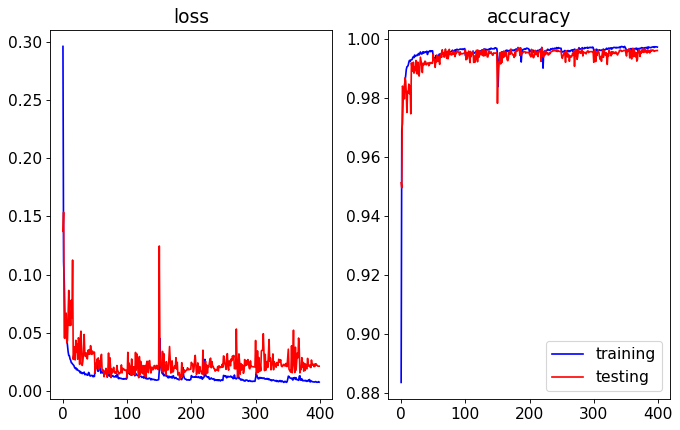

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


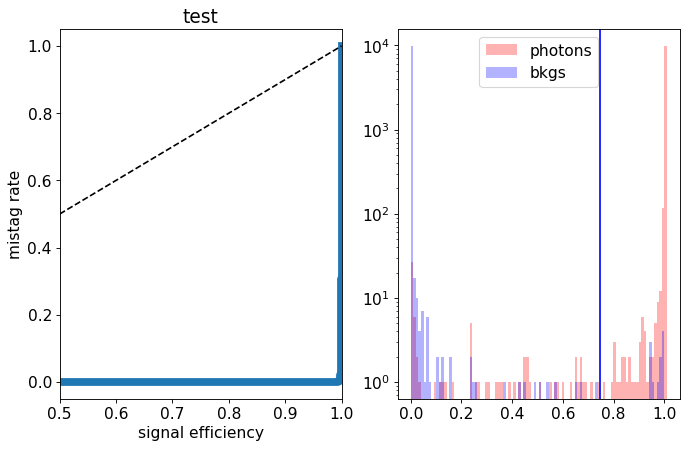

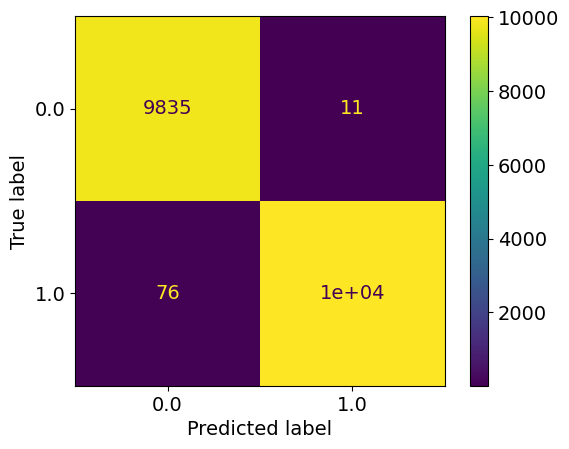

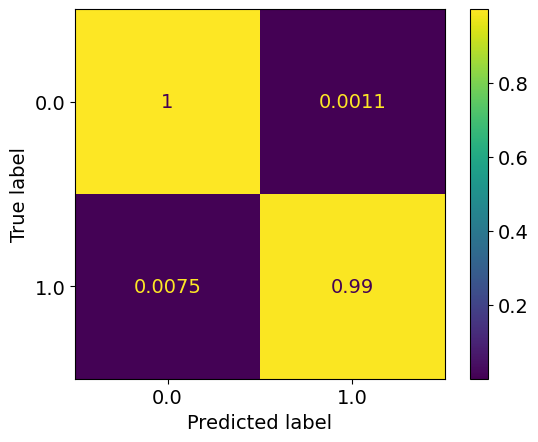

epoch: 400
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.011657805252844579
train acc: 0.9960906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.02422978614691494
test acc: 0.99508846
epoch: 401
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.01069847378730357
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.01401872405938989
test acc: 0.996592
epoch: 402
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.010973106417935271
train acc: 0.9964665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.03323846009066876
test acc: 0.993184
epoch: 403
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.010738727695710252
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.023338011780972865
test acc: 0.99403596
epoch: 404
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.009325769230803308
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.024212314913336953
test acc: 0.9941362
epoch: 405
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.011030656687472034
train acc: 0.9964289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.17it/s]


test loss: 0.020074090891284868
test acc: 0.9954393
epoch: 406
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.01014337879162518
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.04161233085152857
test acc: 0.9926327
epoch: 407
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.010565082580824173
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.017127351462664486
test acc: 0.99574
epoch: 408
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.011255330436536348
train acc: 0.9962911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.04785095229197074
test acc: 0.990628
epoch: 409
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.011135788594978593
train acc: 0.9966043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.0336840312467008
test acc: 0.99393576


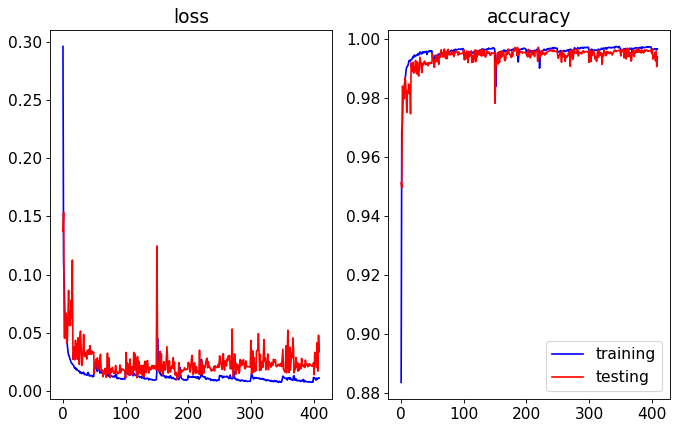

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


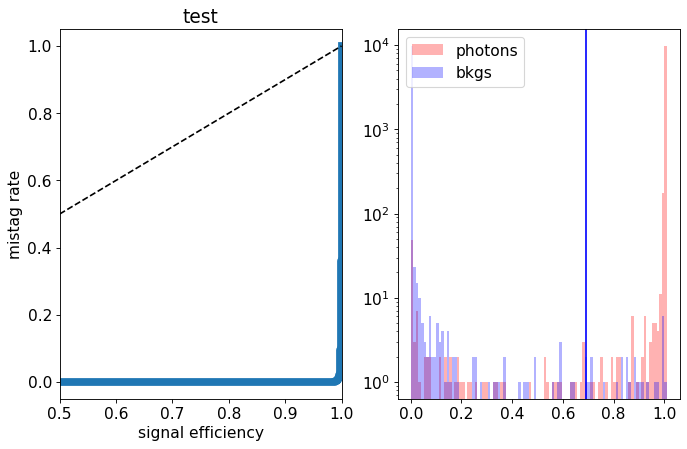

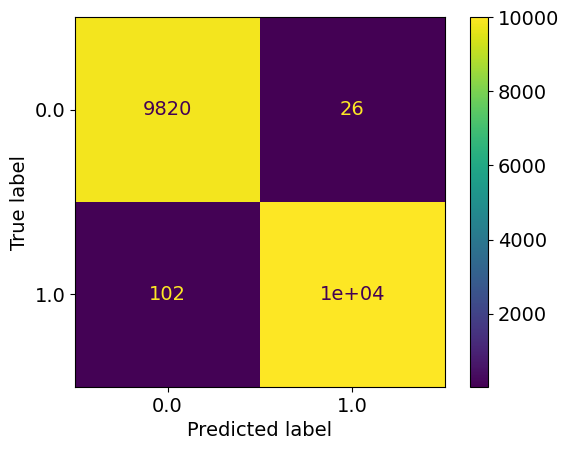

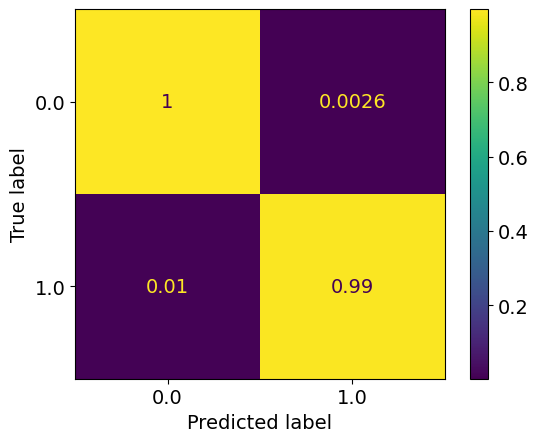

epoch: 410
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.009541517418962139
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.01817465914406485
test acc: 0.99624115
epoch: 411
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.00882754560535065
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.019456987322294426
test acc: 0.9962913
epoch: 412
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.00977555790667585
train acc: 0.9967046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.0296760478790127
test acc: 0.99463737
epoch: 413
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.010294490715587832
train acc: 0.99651664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.014580541255247012
test acc: 0.99699295
epoch: 414
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.010137629996951369
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.017087074418936133
test acc: 0.99584025
epoch: 415
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009159515113152779
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.011918441385633367
test acc: 0.99669224
epoch: 416
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.009560361031035495
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.03160120104289758
test acc: 0.99448705
epoch: 417
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.009279594346602906
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.027877315631485544
test acc: 0.99503833
epoch: 418
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008947116484427198
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.02047582337999141
test acc: 0.9960407
epoch: 419
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.008949517669438817
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.015201026135293753
test acc: 0.99699295


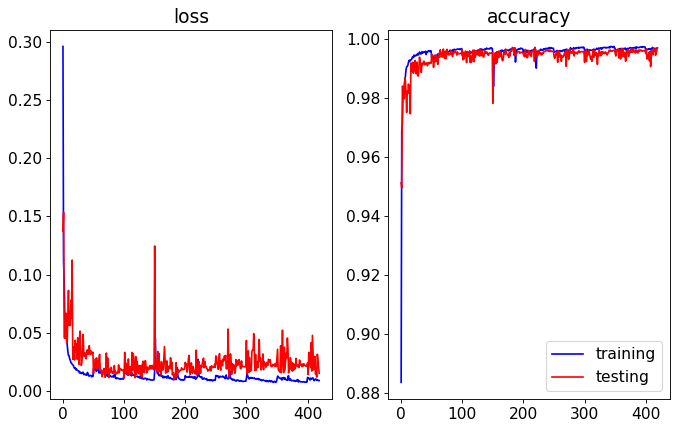

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.22it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


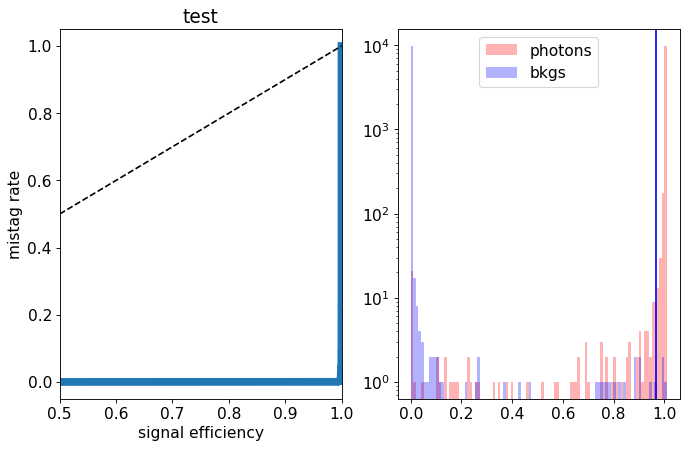

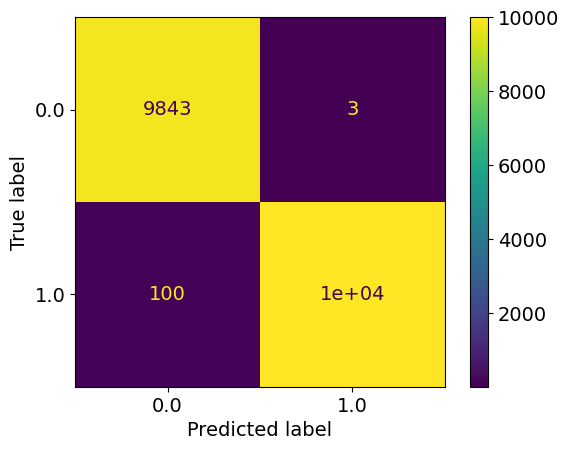

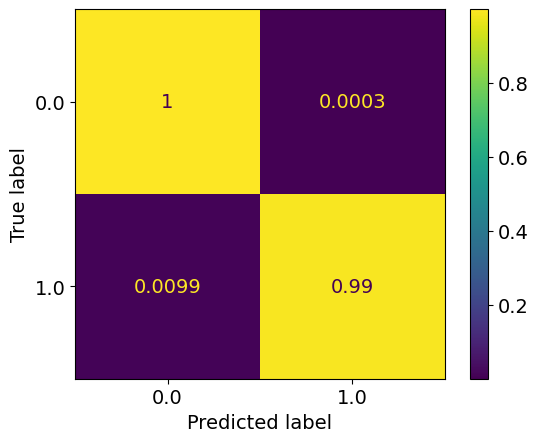

epoch: 420
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008758687709828268
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.027587651628035767
test acc: 0.99533904
epoch: 421
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.008865371777379897
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]


test loss: 0.02486228143200552
test acc: 0.99553955
epoch: 422
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.00898888371793602
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.028106164009145954
test acc: 0.99533904
epoch: 423
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.009357547774952627
train acc: 0.99685496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.025254404685256304
test acc: 0.99669224
epoch: 424
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.009044034445637476
train acc: 0.99718076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.020037197925643447
test acc: 0.9963414
epoch: 425
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.009093769069339494
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.03532332257600501
test acc: 0.9937854
epoch: 426
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.008483600822701328
train acc: 0.9969552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.029936345490140785
test acc: 0.99478775
epoch: 427
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008729601789738483
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.03437841433333233
test acc: 0.9949882
epoch: 428
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.009345096629807976
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.028092965744101948
test acc: 0.9951386
epoch: 429
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.00889002788792809
train acc: 0.99701786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.03083718115436461
test acc: 0.99533904


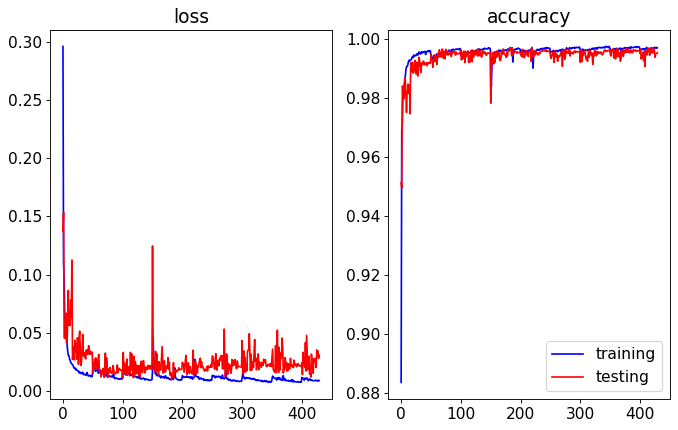

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


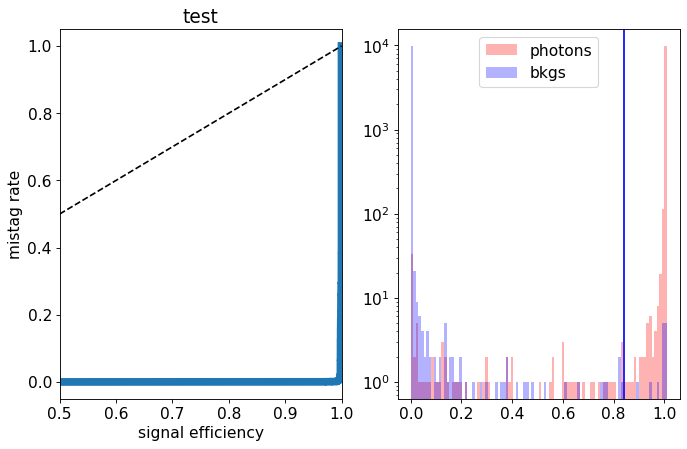

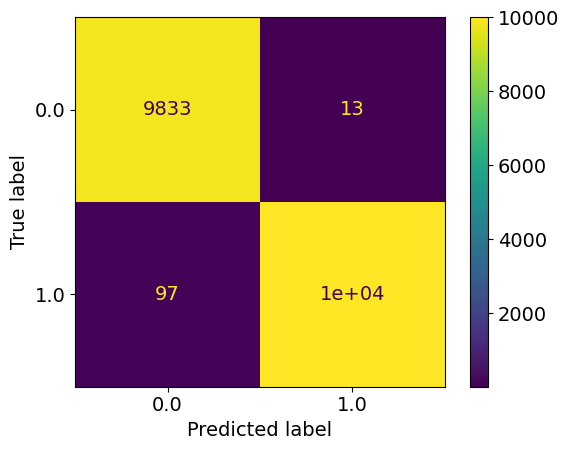

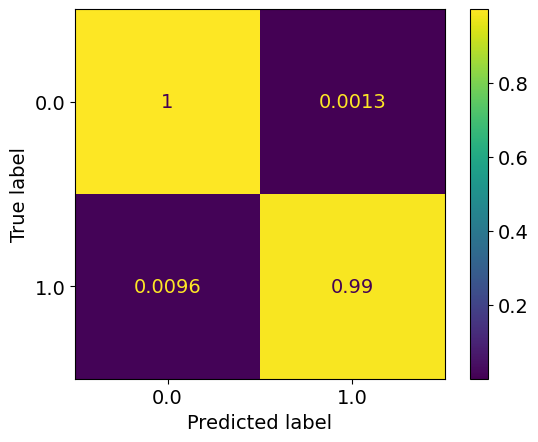

epoch: 430
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008442331576344572
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.036437792711213286
test acc: 0.99423647
epoch: 431
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.008742838389928271
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.17it/s]


test loss: 0.029794870257747415
test acc: 0.9949882
epoch: 432
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.007780089221955168
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.04225457558298812
test acc: 0.9942866
epoch: 433
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.007572603952782506
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.023488211774212474
test acc: 0.996191
epoch: 434
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.008420431237136112
train acc: 0.9972559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.0365109011900666
test acc: 0.9944369
epoch: 435
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.007989309667331626
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.040944521492158804
test acc: 0.99403596
epoch: 436
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.0073971501942375496
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.02736107976970208
test acc: 0.99553955
epoch: 437
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.007292564774263101
train acc: 0.99748147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.03404384306358064
test acc: 0.9952889
epoch: 438
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.008077827158667245
train acc: 0.9972434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.71it/s]


test loss: 0.030788070752083407
test acc: 0.99553955
epoch: 439
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.006960180844354014
train acc: 0.9974564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.03641669310437625
test acc: 0.9949381


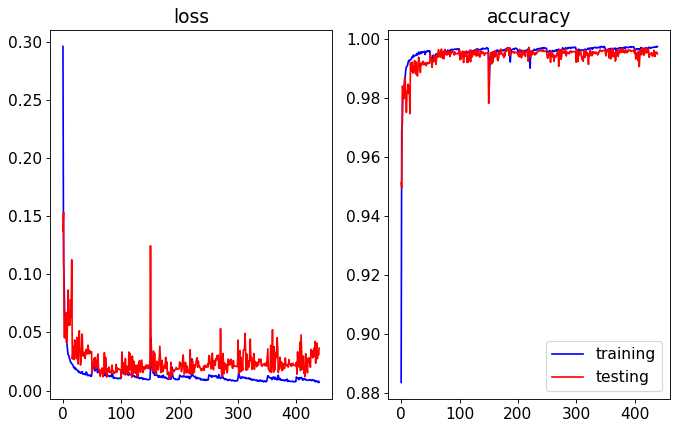

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


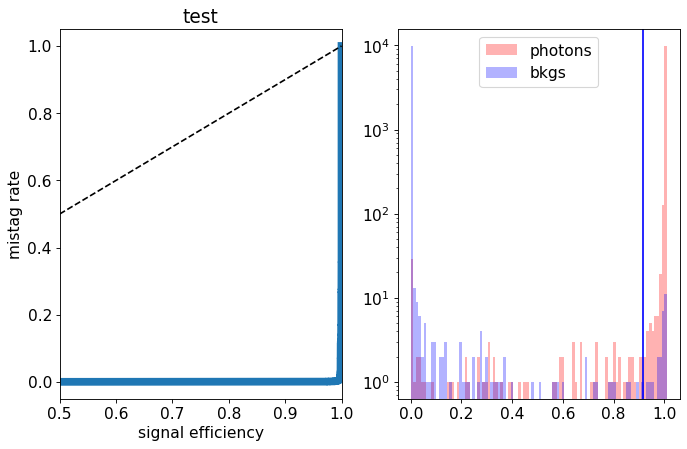

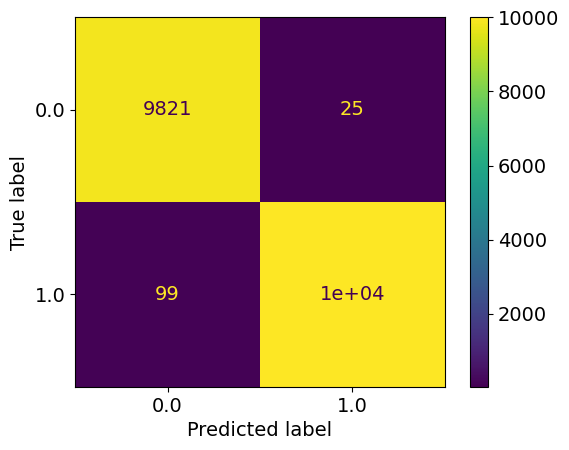

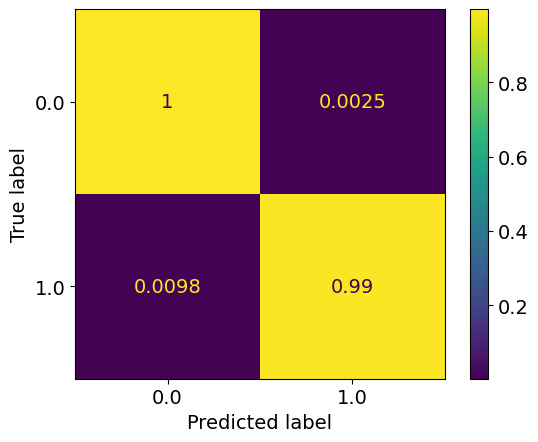

epoch: 440
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.007063316765116222
train acc: 0.9975441


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.87it/s]


test loss: 0.035767074930310415
test acc: 0.99503833
epoch: 441
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.0077771974962948095
train acc: 0.99729353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]


test loss: 0.03178915404714644
test acc: 0.9951887
epoch: 442
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.007502676779659399
train acc: 0.9973812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.03598044051528525
test acc: 0.9952889
epoch: 443
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.006947338932937484
train acc: 0.9975817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.029538020145564052
test acc: 0.99563974
epoch: 444
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.007058815505449424
train acc: 0.9975817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.03584149897291996
test acc: 0.99533904
epoch: 445
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.006966853080796887
train acc: 0.99748147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.03366251983200474
test acc: 0.9951887
epoch: 446
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.007840280822694777
train acc: 0.9973812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.033322003981618976
test acc: 0.9951386
epoch: 447
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.22it/s]


train loss: 0.007408760623989178
train acc: 0.99744385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.033000978373446045
test acc: 0.99523884
epoch: 448
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.007098491985136288
train acc: 0.99743134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.03253362638026695
test acc: 0.99523884
epoch: 449
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008080269165733246
train acc: 0.997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.30it/s]


test loss: 0.03433243731064174
test acc: 0.99523884


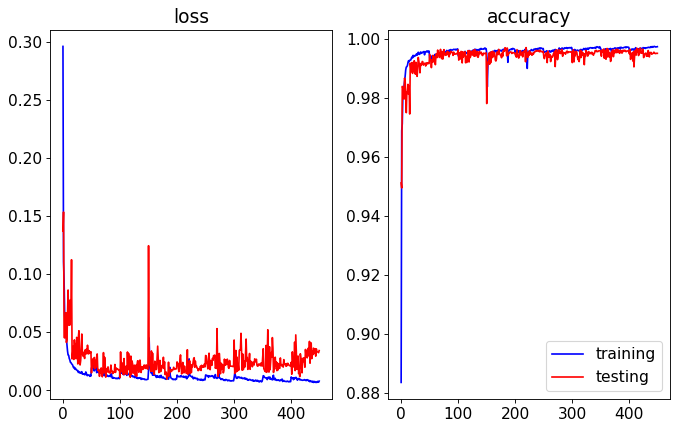

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


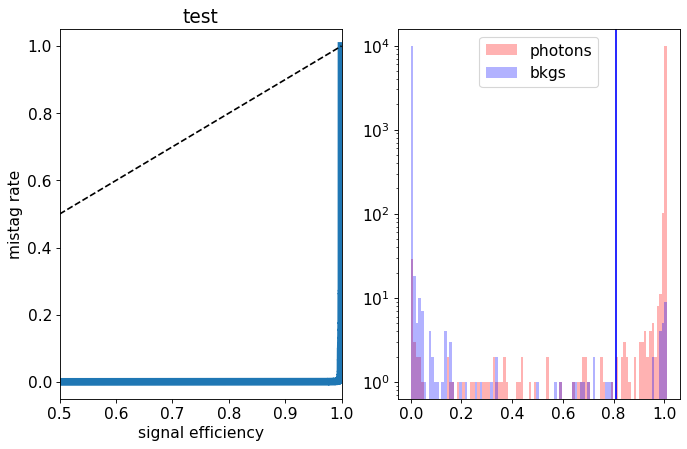

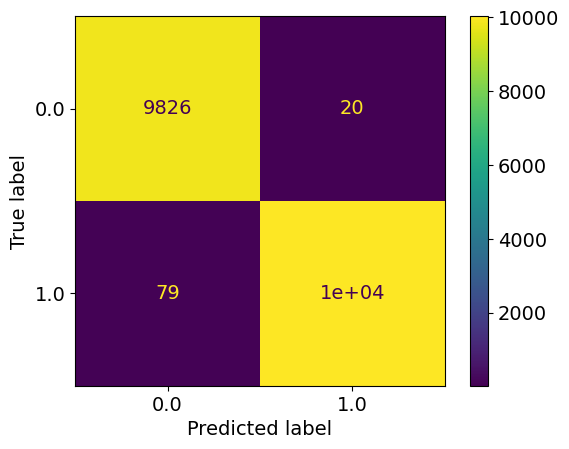

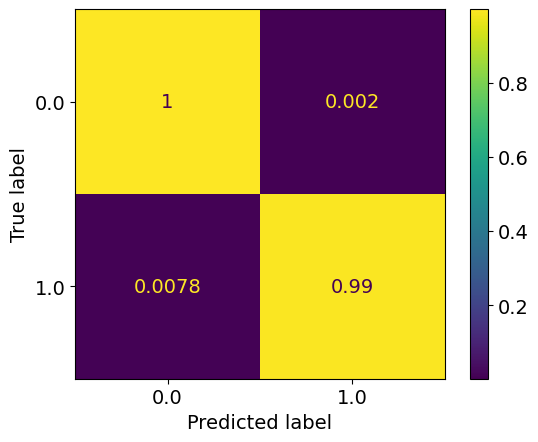

epoch: 450
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.0178685652073855
train acc: 0.9936473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.030386366658871445
test acc: 0.9934847
epoch: 451
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.011790805858552956
train acc: 0.9956771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.018228773645258864
test acc: 0.9962913
epoch: 452
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010672805985477544
train acc: 0.9967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.032148102291530985
test acc: 0.9938355
epoch: 453
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009953833600408885
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.02334197935209993
test acc: 0.9949381
epoch: 454
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.009987865776212803
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.035443290953480755
test acc: 0.993184
epoch: 455
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010325130031587696
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.014106679462951006
test acc: 0.99649173
epoch: 456
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.00940449828709434
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.030144781795088955
test acc: 0.9951887
epoch: 457
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010187994241766604
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.04it/s]


test loss: 0.021060178915778285
test acc: 0.9954894
epoch: 458
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.010188772382193801
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.017358929045525762
test acc: 0.99639153
epoch: 459
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009851873693327462
train acc: 0.9966043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.13it/s]


test loss: 0.022897141396670657
test acc: 0.99533904


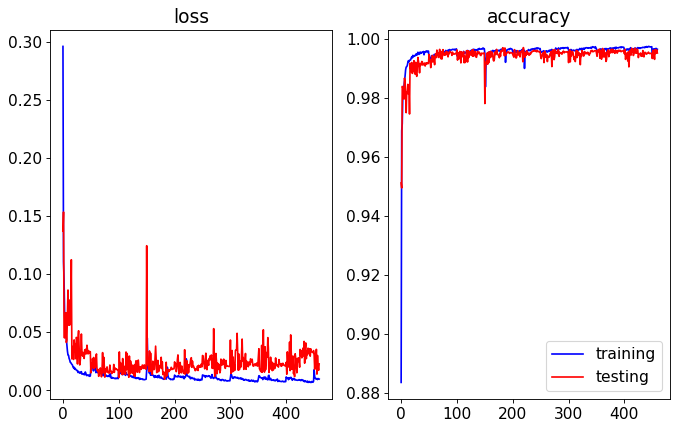

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


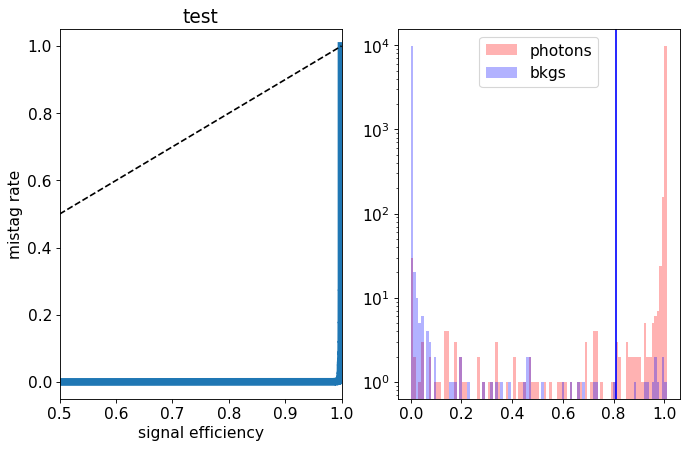

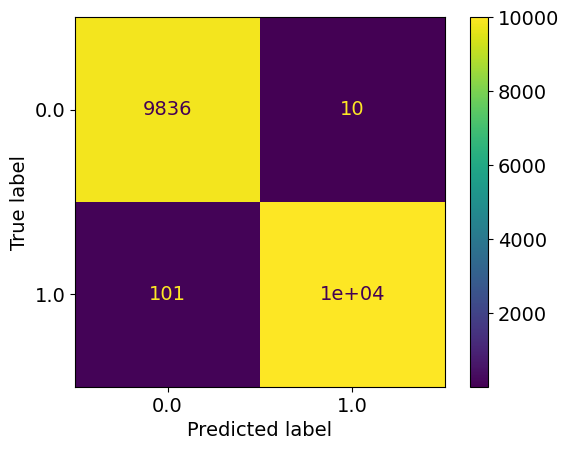

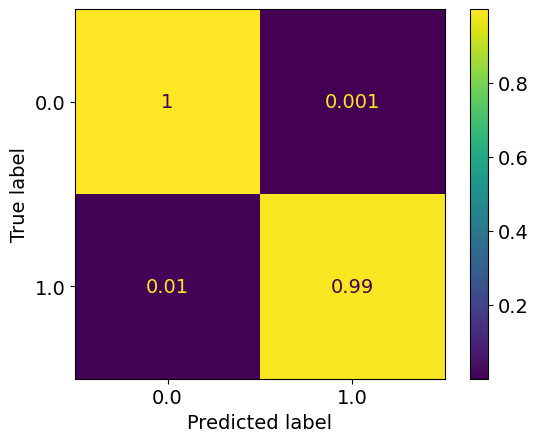

epoch: 460
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.009312227404843183
train acc: 0.9969552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.06549638533375829
test acc: 0.9918308
epoch: 461
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.011579596465966081
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.02571677075962618
test acc: 0.9948379
epoch: 462
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.00966608814318289
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.03757479999330826
test acc: 0.9938355
epoch: 463
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.00954962268023432
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.024921935935066464
test acc: 0.9954894
epoch: 464
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.009147706619353527
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.66it/s]


test loss: 0.02689599699121626
test acc: 0.9954393
epoch: 465
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.23it/s]


train loss: 0.00882976949075932
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.85it/s]


test loss: 0.031763693940935325
test acc: 0.9941362
epoch: 466
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.008743169898758396
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.23it/s]


test loss: 0.022770230853519237
test acc: 0.9955896
epoch: 467
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.27it/s]


train loss: 0.008531769880731312
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.95it/s]


test loss: 0.02615776185206521
test acc: 0.9954393
epoch: 468
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008784547393330665
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.74it/s]


test loss: 0.02515258278874492
test acc: 0.99624115
epoch: 469
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.009371224223938423
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.68it/s]


test loss: 0.03137751005809097
test acc: 0.9937854


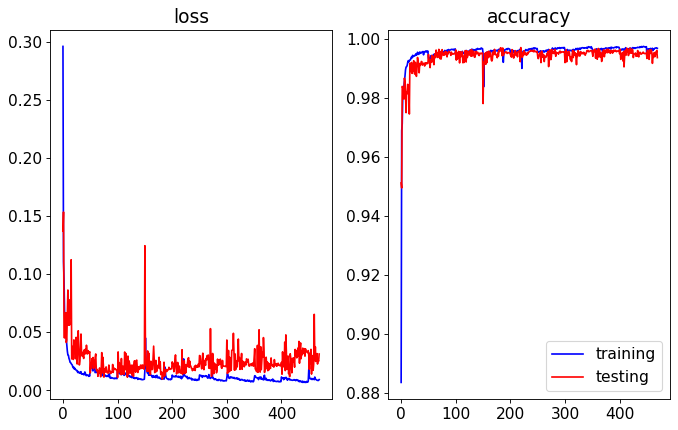

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.94it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


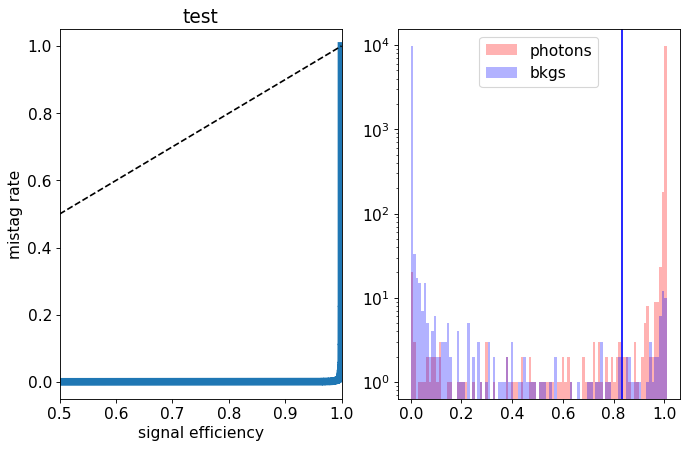

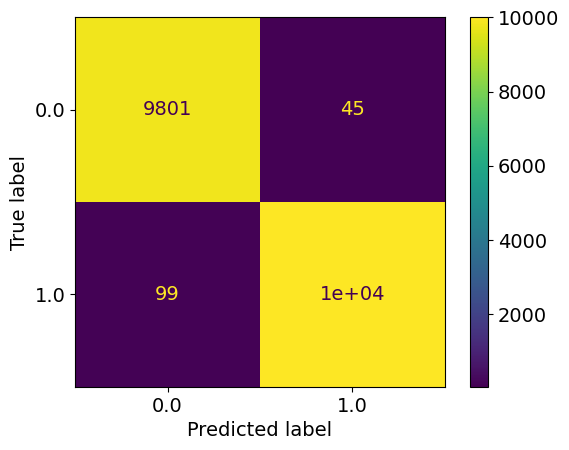

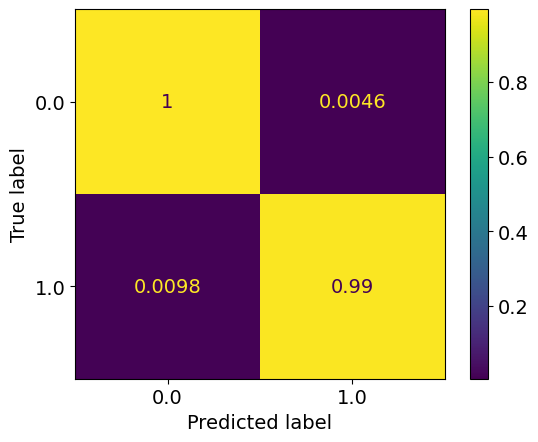

epoch: 470
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009840349821413824
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.023964240655700183
test acc: 0.9958903
epoch: 471
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.008526456505824714
train acc: 0.99685496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.03024073065133801
test acc: 0.9949381
epoch: 472
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009546431090766147
train acc: 0.99698025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.02257256010617472
test acc: 0.99574
epoch: 473
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.009108255181876194
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.07it/s]


test loss: 0.02261406757101855
test acc: 0.9955896
epoch: 474
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009232372100683924
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.01869633852808928
test acc: 0.99574
epoch: 475
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.008587632124436455
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.027530544822665808
test acc: 0.9955896
epoch: 476
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.008492563215176193
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.95it/s]


test loss: 0.02920783807263326
test acc: 0.99508846
epoch: 477
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.008066156346510762
train acc: 0.9972183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.03it/s]


test loss: 0.029015048501177636
test acc: 0.99538916
epoch: 478
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.007928776549985077
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.08it/s]


test loss: 0.018871946717434397
test acc: 0.99644166
epoch: 479
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008081025928745407
train acc: 0.99714315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.037987876673201644
test acc: 0.9941362


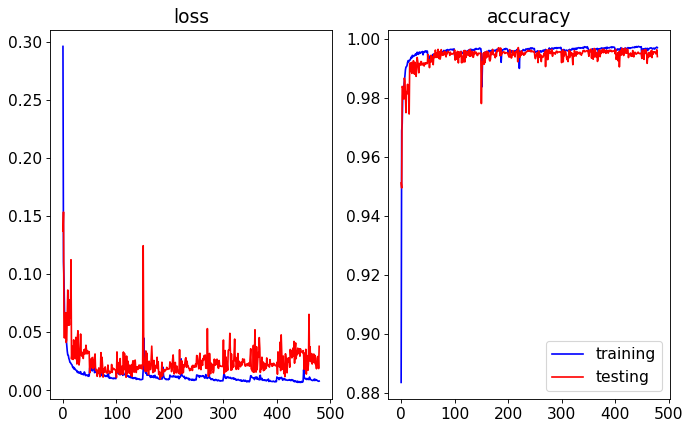

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.12it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


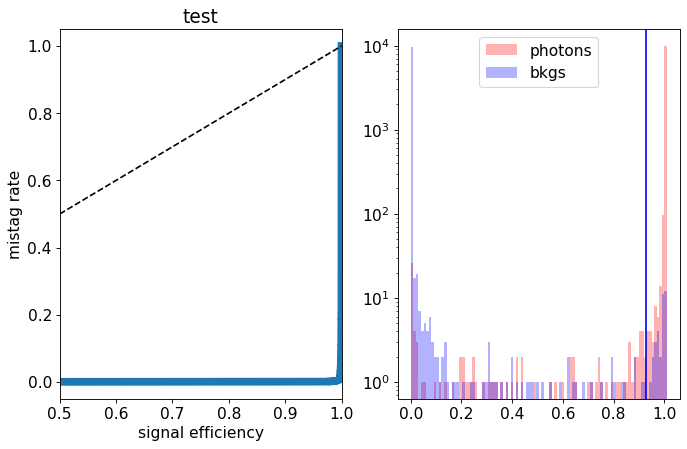

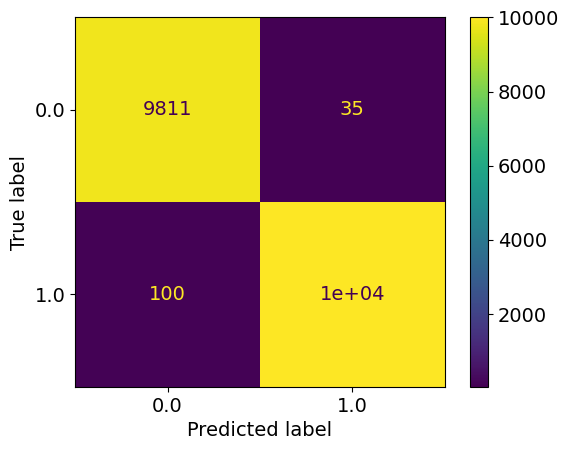

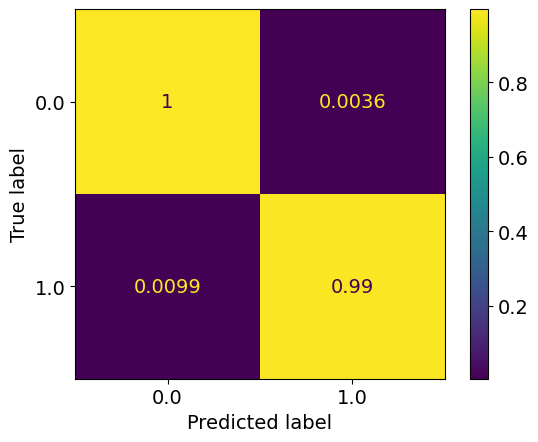

epoch: 480
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.32it/s]


train loss: 0.008975061534994297
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.01645454809305888
test acc: 0.9968927
epoch: 481
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.009046397075046604
train acc: 0.99701786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.09it/s]


test loss: 0.021178082383224082
test acc: 0.9962913
epoch: 482
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.007685414714167075
train acc: 0.99728096


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.02579484264852534
test acc: 0.99574
epoch: 483
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.007636623859315165
train acc: 0.9974063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.028390257772972452
test acc: 0.9952889
epoch: 484
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.007440298068104312
train acc: 0.9973937


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.024756453426936574
test acc: 0.9954894
epoch: 485
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.007363850666336733
train acc: 0.99756914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.67it/s]


test loss: 0.02089205839429804
test acc: 0.996191
epoch: 486
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.007796657760797716
train acc: 0.9972559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.020351336065419567
test acc: 0.99644166
epoch: 487
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.0069947582586615655
train acc: 0.99744385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.02141537212596364
test acc: 0.996191
epoch: 488
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.007445545013517885
train acc: 0.9975441


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.14it/s]


test loss: 0.02402128381008344
test acc: 0.9957901
epoch: 489
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.007534409488321963
train acc: 0.9976569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.02611648415297489
test acc: 0.99584025


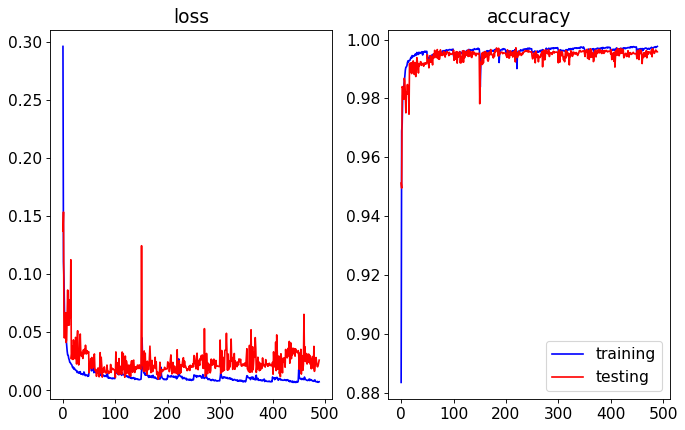

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.51it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


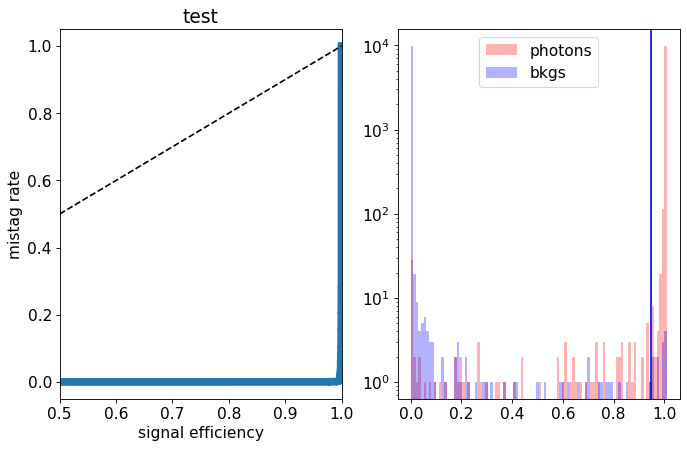

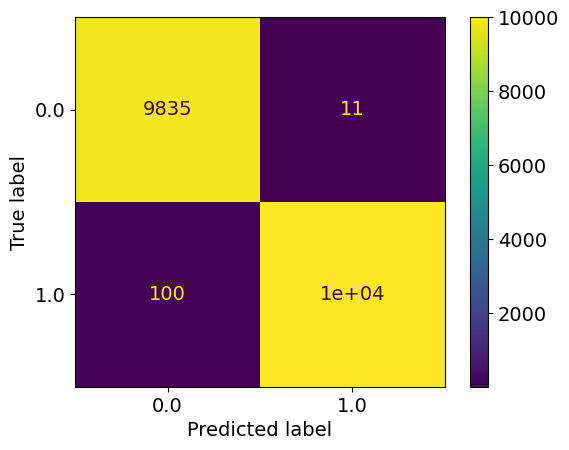

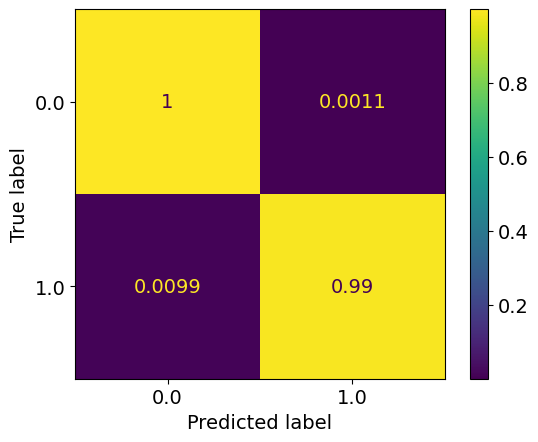

epoch: 490
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.007107705379134188
train acc: 0.99756914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.028901339234674677
test acc: 0.9959906
epoch: 491
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.007475328993976617
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.024781285770158694
test acc: 0.9958903
epoch: 492
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.006720416634617499
train acc: 0.99759424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.025330937763689745
test acc: 0.9960407
epoch: 493
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.006878354436825004
train acc: 0.9975316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.02607288015732432
test acc: 0.9958903
epoch: 494
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.006865261857564658
train acc: 0.99764436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.98it/s]


test loss: 0.02403300047187847
test acc: 0.9960908
epoch: 495
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.0066572699813978444
train acc: 0.99774456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.97it/s]


test loss: 0.0252632928392867
test acc: 0.99614096
epoch: 496
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.00695419940285801
train acc: 0.99746895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.02261890856714351
test acc: 0.9960908
epoch: 497
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.007049124183153565
train acc: 0.997494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.62it/s]


test loss: 0.02314053374133811
test acc: 0.9960908
epoch: 498
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.00665933321144974
train acc: 0.9976945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.16it/s]


test loss: 0.02347438718767508
test acc: 0.9960908
epoch: 499
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.006990316482052318
train acc: 0.9973812


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.15it/s]


test loss: 0.02423568147134895
test acc: 0.9960908


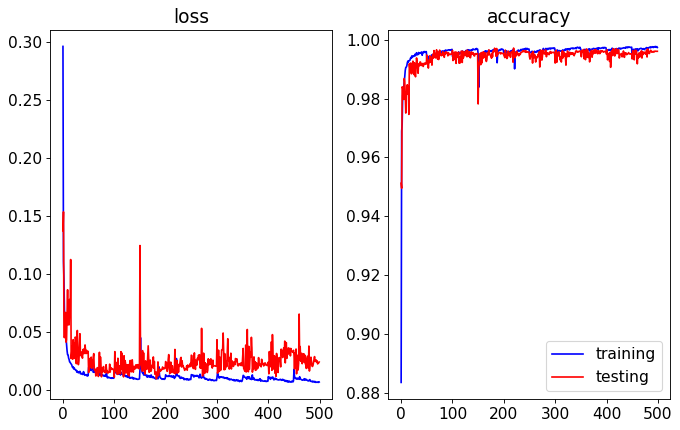

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.79it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


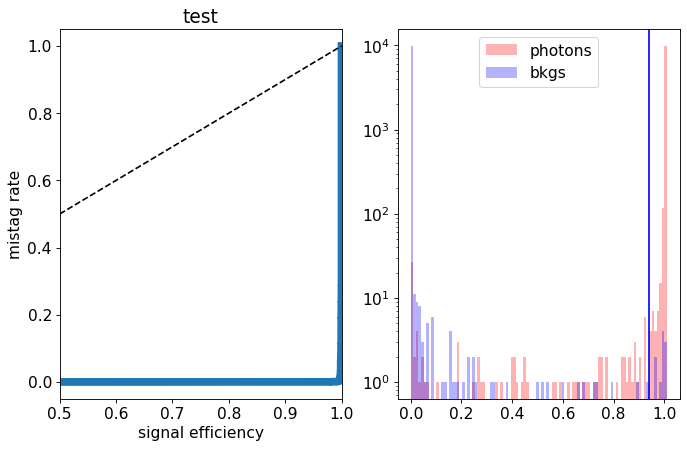

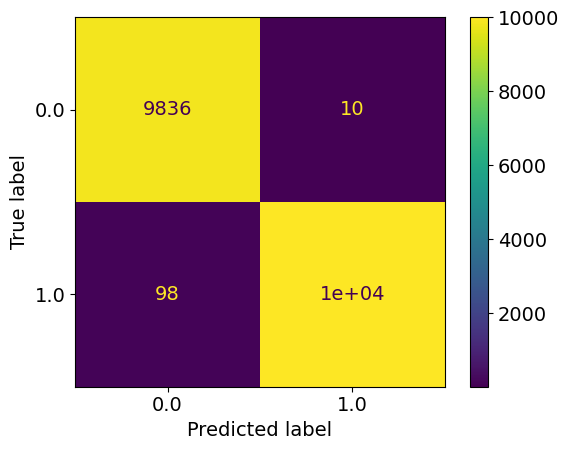

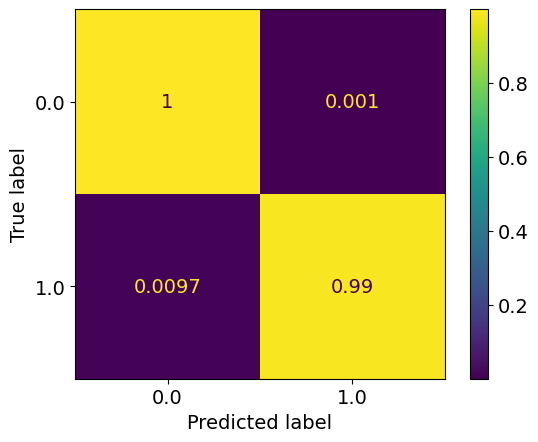

In [32]:
from tqdm import tqdm as tqdm


checkpoint_dir ="/home/llr/cms/cappati/HGC_models/PID_phopi/trainings/outdir_models_50-50"
os.makedirs(checkpoint_dir, exist_ok=True)


nepoch=500
best_loss = 99999999
best_acc = 0.
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    print("Learning rate:", optimizer.param_groups[0]['lr'])
    loss_t, acc_t = train(epoch)
    losst.append(loss_t)
    acct.append(acc_t)
    loss_v, acc_v = test(epoch)
    loss_epoch = loss_v
    lossv.append(loss_epoch)
    accv.append(acc_v)
    epochs.append(epoch)

    
     
    
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    
#     if loss_epoch < best_loss:
#         best_loss = loss_epoch
#         print('new best test loss:',best_loss)
#         torch.save(checkpoint,
#                    os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    
    
    if acc_v > best_acc:
        print('new best acc:',acc_v)
        best_acc = acc_v
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_bestacc.pth.tar' ))
    
    if ((epoch+1)%10 == 0):
        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        
        ax0.plot(np.array(epochs),np.array(losst),c='b',label='training')
        ax0.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        ax0.title.set_text("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.legend()
        #plt.show()
        ax1.plot(np.array(epochs),np.array(acct),c='b',label='training')
        ax1.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        ax1.title.set_text("accuracy")
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        
        
        model.eval()
        scores = []
        trues = []
        true_preds, num_preds = 0., 0.
        for data in tqdm(testloader): ### change to loaderDNN for DNN
                datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                optimizer.zero_grad()
                #label = label.to(torch.long).squeeze()
                result = model(datax, masks, info3d)
                scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
                trues.append(label.detach().cpu().numpy().flatten())
        
        
        truesa = np.hstack(trues)
        scoresa = np.hstack(scores)
        fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
        aucv = metrics.auc(fpr, tpr)

        tpr90,fpr90,threshold90 = 0,0,0
        for i,j,k in zip(tpr,fpr,thresholds):
            if i >0.99:
                tpr90 = i
                fpr90 = j
                threshold90 = k
                break

        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        plt.rcParams['font.size'] = '14'
        ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
        ax0.set_xlabel("signal efficiency")
        ax0.set_ylabel("mistag rate")
        ax0.set_xlim([0.5,1])
        ax0.plot([0.,1], [0.,1], 'k--')
        ax0.title.set_text("test")
        plt.legend()
        #ax.text(0.6,0.6,aucv,)
        #plt.yscale("log")
        
        ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
        ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
        ax1.axvline(threshold90,c="b")
        plt.yscale("log")
        plt.legend()
        plt.show()

        
        
        
        
        
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
        plt.show()
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
        plt.show()
        

In [33]:
#print(epoch_size)

In [34]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
scores = []
trues = []
true_preds, num_preds = 0., 0.
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        optimizer.zero_grad()
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
        trues.append(label.detach().cpu().numpy().flatten())
        #break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


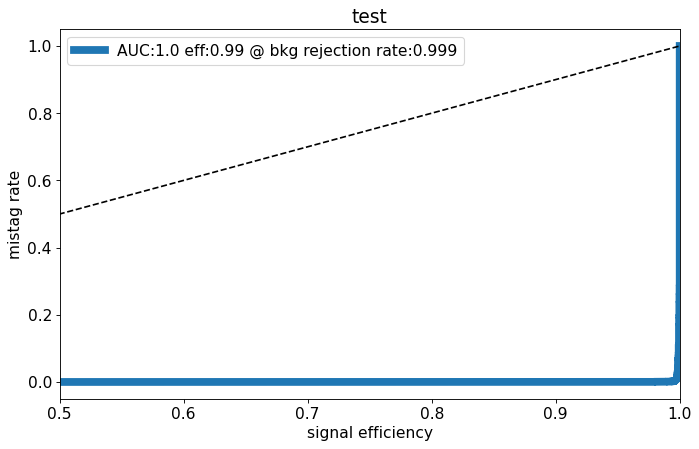

In [35]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.hstack(trues), np.hstack(scores), pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.99:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break

fig, ax = plt.subplots(figsize=(10, 6),dpi=80)
plt.rcParams['font.size'] = '14'
ax.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax.set_xlabel("signal efficiency")
ax.set_ylabel("mistag rate")
ax.set_xlim([0.5,1])
ax.plot([0.,1], [0.,1], 'k--')
ax.title.set_text("test")
#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
plt.legend()
plt.show()

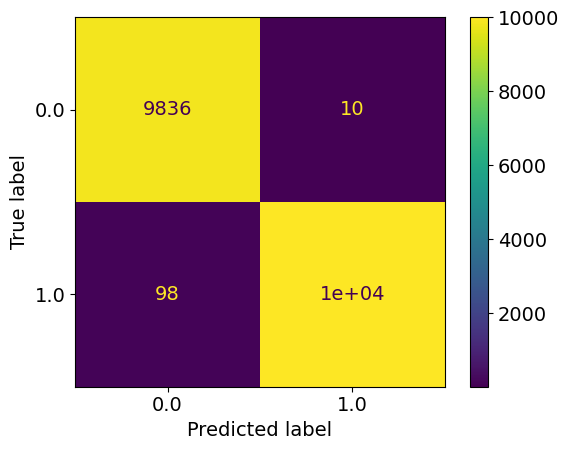

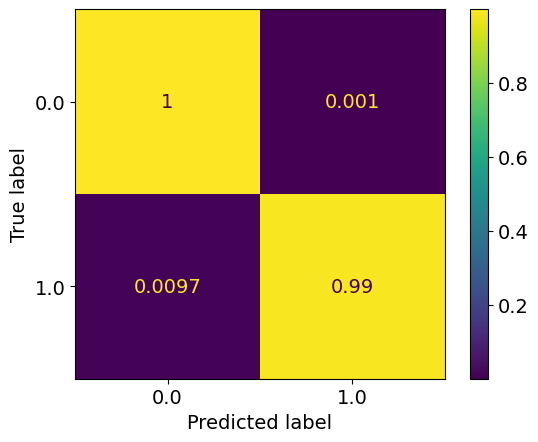

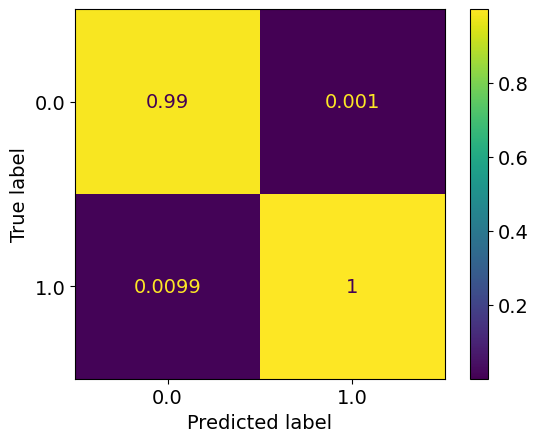

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix(np.hstack(trues), np.where(np.hstack(scores)>0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="pred")
plt.show()